# **PROJECT PIPELINE**

#### *Semantic Bridges: LLM-Driven Cross-Domain Cold-Start Recommendation (Movies → Books)*

Team Members: Bhagya Puppala, Cassandre Korvink, Janani Vakkanti, Muskan Khepar, Nathan Arimilli

### **Project Hypothesis & Goal**

**Hypothesis**

LLM semantic embeddings can map movies and books into a **shared conceptual space**, enabling cross-domain cold-start recommendations without shared users or joint training.

**Goal**

Given a user’s movie preferences, recommend books that match the same **themes, tone, genre, and narrative semantics**.

# **PHASE 1 — Data Preprocessing Pipeline** 

## **Step 1.1 — Loading Separate Datasets**

NOTE: When filter books/movies - instead of removing rows with null description, remove ones with null reviews as that would capture our main semantic crux


In [3]:
import pandas as pd
import re
import numpy as np

In [ ]:
#!unzip Books_rating.zip

Archive:  Books_rating.zip
  inflating: Books_rating.csv        


In [4]:
import pandas as pd
import re

# Read the files and load into DataFrames
books_df = pd.read_csv('books_data.csv')
books_rating_df = pd.read_csv('Books_rating.csv')
movies_df = pd.read_csv('rotten_tomatoes_movies.csv')

# Select relevant columns
movies_subset = movies_df[[
    'movie_title', 'movie_info', 'critics_consensus', 'genres',
    'directors', 'authors', 'tomatometer_rating', 'audience_rating',
    'tomatometer_count', 'audience_count'
]]

books_combined = pd.merge(
    books_rating_df[['Title', 'review/helpfulness', 'review/score',
                    'review/summary', 'review/text']],
    books_df[['Title', 'description', 'authors', 'categories']],
    on='Title',
    how='inner'
)

In [5]:
# FILTER: Remove rows with null review/text (main semantic crux)
print(f"Original books_combined: {len(books_combined):,} rows")
books_filtered = books_combined[books_combined['review/text'].notnull()].copy()
print(f"After removing null reviews: {len(books_filtered):,} rows")

# Handle description nulls by creating synthetic descriptions
books_filtered['description'] = books_filtered['description'].fillna('No description available')

Original books_combined: 3,000,000 rows
After removing null reviews: 2,999,992 rows


## **Step 1.2 — Clean & Normalize Text**

Operations:

* lowercase
* remove HTML
* strip emojis/URLs
* collapse whitespace
* convert ratings into text phrases (“highly rated”, “mixed reviews”)

**Do NOT**:

* stem
* lemmatize
* remove stopwords
  LLMs rely on natural language structure.

In [ ]:
def clean_text_llm(text):
    """
    Clean text for LLM embeddings while preserving natural language structure
    """
    if pd.isna(text) or text == '':
        return ""

    text = str(text)

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # 3. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 4. Remove emojis and special characters (keep basic punctuation)
    text = re.sub(r'[^\w\s\.\,\!\?]', '', text)

    # 5. Collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
def convert_ratings_to_text(movies_df, books_df):
    """
    Convert numerical ratings into descriptive text phrases
    """
    # For movies
    movies_df['rating_text'] = movies_df.apply(
        lambda row: f"Critics rating: {row['tomatometer_rating']:.0f}%. Audience rating: {row['audience_rating']:.0f}%.",
        axis=1
    )

    # For books - convert review scores to text phrases
    def get_rating_phrase(score):
        if score >= 4.5:
            return "extremely highly rated"
        elif score >= 4.0:
            return "very highly rated"
        elif score >= 3.5:
            return "well rated"
        elif score >= 3.0:
            return "moderately rated"
        else:
            return "mixed or low ratings"

    books_df['rating_text'] = books_df['review/score'].apply(
        lambda score: f"This book has {get_rating_phrase(score)} with a score of {score:.1f} out of 5."
    )

    return movies_df, books_df

# Apply rating conversion
movies_with_ratings, books_with_ratings = convert_ratings_to_text(movies_subset, books_filtered)

/var/folders/0m/sl_d7m1d7tj_3zgcw6mpcc840000gn/T/ipykernel_52841/2744440024.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df['rating_text'] = movies_df.apply(


In [ ]:
# Movies data preparation
movies_final = movies_with_ratings.copy()

# Handle missing values for movies
movies_final['movie_info'] = movies_final['movie_info'].fillna('No description available')
movies_final['genres'] = movies_final['genres'].fillna('Unknown Genre')
movies_final['directors'] = movies_final['directors'].fillna('Unknown Director')
movies_final['authors'] = movies_final['authors'].fillna('Unknown Author')
movies_final['critics_consensus'] = movies_final['critics_consensus'].fillna('No consensus available')

# Fill numeric missing values
movies_final['tomatometer_rating'] = movies_final['tomatometer_rating'].fillna(0)
movies_final['audience_rating'] = movies_final['audience_rating'].fillna(0)
movies_final['tomatometer_count'] = movies_final['tomatometer_count'].fillna(0)
movies_final['audience_count'] = movies_final['audience_count'].fillna(0)

# Books data preparation
books_final = books_with_ratings.copy()

# Convert review/helpfulness
def parse_helpfulness(help_str):
    if pd.isna(help_str) or help_str == '':
        return 0.0
    try:
        if '/' in str(help_str):
            helpful, total = map(int, str(help_str).split('/'))
            return helpful / total if total > 0 else 0.0
        else:
            return float(help_str)
    except (ValueError, ZeroDivisionError):
        return 0.0

books_final['helpfulness_score'] = books_final['review/helpfulness'].apply(parse_helpfulness)

# Fill other missing values
books_final['review/summary'] = books_final['review/summary'].fillna('No summary')
books_final['authors'] = books_final['authors'].fillna('Unknown Author')
books_final['categories'] = books_final['categories'].fillna('Unknown Category')

# Convert data types
movies_final = movies_final.astype({
    'movie_title': 'string', 'movie_info': 'string', 'critics_consensus': 'string',
    'genres': 'string', 'directors': 'string', 'authors': 'string',
    'tomatometer_rating': 'float32', 'audience_rating': 'float32',
    'tomatometer_count': 'int32', 'audience_count': 'int32'
})

books_final = books_final.astype({
    'Title': 'string', 'review/summary': 'string', 'review/text': 'string',
    'description': 'string', 'authors': 'string', 'categories': 'string',
    'review/score': 'float32', 'helpfulness_score': 'float32'
})

# Drop original review/helpfulness
books_final = books_final.drop('review/helpfulness', axis=1)

In [ ]:
def create_semantic_bridge_columns(movies_df, books_df):
    """
    Create semantic columns with LLM-optimized cleaning
    """
    print("Creating semantic bridge columns...")

    # MOVIES: Clean and combine semantic content
    movies_df['movie_info_clean'] = movies_df['movie_info'].apply(clean_text_llm)
    movies_df['genres_clean'] = movies_df['genres'].apply(clean_text_llm)
    movies_df['critics_consensus_clean'] = movies_df['critics_consensus'].apply(clean_text_llm)
    movies_df['rating_text_clean'] = movies_df['rating_text'].apply(clean_text_llm)

    # Combine movie semantic content
    movies_df['movie_final_semantic'] = (
        movies_df['movie_info_clean'] + " " +
        movies_df['genres_clean'] + " " +
        movies_df['critics_consensus_clean'] + " " +
        movies_df['rating_text_clean']
    )

    # BOOKS: Clean and combine semantic content (REVIEW TEXT IS PRIMARY)
    books_df['review_text_clean'] = books_df['review/text'].apply(clean_text_llm)
    books_df['review_summary_clean'] = books_df['review/summary'].apply(clean_text_llm)
    books_df['rating_text_clean'] = books_df['rating_text'].apply(clean_text_llm)
    books_df['description_clean'] = books_df['description'].apply(clean_text_llm)
    books_df['categories_clean'] = books_df['categories'].apply(clean_text_llm)

    # Combine book semantic content - REVIEW TEXT IS MAIN SEMANTIC CRUX
    books_df['book_final_semantic'] = (
        books_df['review_text_clean'] + " " +
        books_df['review_summary_clean'] + " " +
        books_df['rating_text_clean'] + " " +
        books_df['categories_clean']
    )

    # Add description only if it's not the default placeholder
    has_real_description = ~books_df['description'].str.contains('No description available', na=False)
    books_df.loc[has_real_description, 'book_final_semantic'] = (
        books_df.loc[has_real_description, 'book_final_semantic'] + " " +
        books_df.loc[has_real_description, 'description_clean']
    )

    return movies_df, books_df

# Apply semantic bridge creation
movies_ready, books_ready = create_semantic_bridge_columns(movies_final, books_final)

Creating semantic bridge columns...


In [ ]:
# -----------------------------
# 1. Add IDs for MOVIES
# -----------------------------
movies_phase1 = movies_ready.copy()

if "movie_id" not in movies_phase1.columns:
    movies_phase1 = (
        movies_phase1
        .reset_index(drop=False)
        .rename(columns={"index": "movie_id"})
    )

# -----------------------------
# 2. Add IDs for BOOKS (review-level)
# -----------------------------
books_phase1 = books_ready.copy()

# Same book_id for all reviews of a given Title
if "book_id" not in books_phase1.columns:
    books_phase1["book_id"] = books_phase1.groupby("Title", sort=False).ngroup()

# Unique review_id per row (for traceability if needed)
if "review_id" not in books_phase1.columns:
    books_phase1 = (
        books_phase1
        .reset_index(drop=False)
        .rename(columns={"index": "review_id"})
    )

# **PHASE 2 — Representation Engineering (Embedding Space)** 

## Compute Semantic Embeddings: OpenAI text-embedding-3-large

## **Step 2.1 — Create Component Embeddings**

Embed each textual component separately.

### **Movies:**

* `E_plot`
* `E_consensus`
* `E_reviews` (average across reviews)
* `E_metadata` (genres, director)
* `E_ratings` (also see how to normalise or handle count of ratings)

### **Books:**

* `E_description`
* `E_reviews`
* `E_metadata`
* `E_ratings`

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np


# ============================================================
# CONFIG
# ============================================================

EMBEDDING_MODEL_NAME = "all-mpnet-base-v2"
EMBED_BATCH_SIZE = 256


# ============================================================
# UTILS
# ============================================================

def build_embedding_model(model_name: str = EMBEDDING_MODEL_NAME):
    print(f"Loading embedding model: {model_name}")
    model = SentenceTransformer(model_name, device = 'cuda')
    return model


def embed_texts(model, texts, batch_size: int = EMBED_BATCH_SIZE):
    """
    Helper: embed a list/Series of texts with batching.
    NaNs are converted to empty strings.
    """
    texts = pd.Series(texts).fillna("").tolist()
    embeddings = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True
    )
    return np.array(embeddings)


def weighted_mean_embeddings(emb_list, weights=None):
    """
    Compute (optionally weighted) mean of a list of embedding vectors.
    emb_list: list of np.array vectors [dim]
    weights: list-like of same length or None
    """
    emb_stack = np.vstack(emb_list)  # [N, dim]
    if weights is None:
        return emb_stack.mean(axis=0)
    w = np.array(weights, dtype=float)
    w = w / (w.sum() + 1e-8)
    w = w.reshape(-1, 1)
    return (emb_stack * w).sum(axis=0)


# ============================================================
# STEP 2.1 — MOVIES: COMPONENT EMBEDDINGS
# ============================================================

def compute_movie_component_embeddings(movies_phase1: pd.DataFrame,
                                       model: SentenceTransformer):
    """
    Compute component-level embeddings for movies:
      - E_plot        : movie_info_clean
      - E_consensus   : critics_consensus_clean
      - E_metadata    : genres_clean
      - E_ratings     : rating_text_clean

    Assumes movies_phase1 already has movie_id and *_clean columns.
    """
    df = movies_phase1.copy()

    # Ensure text columns exist
    for col in [
        "movie_info_clean",
        "critics_consensus_clean",
        "genres_clean",
        "rating_text_clean"
    ]:
        if col not in df.columns:
            df[col] = ""

    print("Embedding movie plot (E_plot)...")
    E_plot = embed_texts(model, df["movie_info_clean"])

    print("Embedding movie critics consensus (E_consensus)...")
    E_consensus = embed_texts(model, df["critics_consensus_clean"])

    print("Embedding movie metadata / genres (E_metadata)...")
    E_metadata = embed_texts(model, df["genres_clean"])

    print("Embedding movie rating text (E_ratings)...")
    E_ratings = embed_texts(model, df["rating_text_clean"])

    # Attach as new columns
    df["E_plot"] = list(E_plot)
    df["E_consensus"] = list(E_consensus)
    df["E_metadata"] = list(E_metadata)
    df["E_ratings"] = list(E_ratings)

    print("Movie component embeddings computed. Shape:", df.shape)
    return df


# ============================================================
# STEP 2.1 — BOOKS: REVIEW-LEVEL + BOOK-LEVEL COMPONENT EMBEDDINGS
# ============================================================

def compute_book_component_embeddings(books_phase1: pd.DataFrame,
                                      model: SentenceTransformer,
                                      use_weighted_reviews: bool = True,
                                      max_reviews_per_book: int = 20,
                                      min_reviews_per_book: int = 5):
    """
    Compute component-level embeddings for books.

    Input:
      - books_phase1: one row per review (already has book_id, review_id)

    Controls:
      - max_reviews_per_book: cap per-book reviews for speed.
      - min_reviews_per_book: drop books with fewer than this many reviews.

    Outputs:
      - books_with_review_embs: review-level DF with E_review per row
      - books_components      : book-level DF with
          E_reviews      (aggregated over reviews per book_id)
          E_description  (description_clean)
          E_metadata     (categories_clean)
          E_ratings      (rating_text_clean)
    """
    df = books_phase1.copy()

    # Ensure IDs exist
    if "book_id" not in df.columns:
        df["book_id"] = df.groupby("Title", sort=False).ngroup()

    if "review_id" not in df.columns:
        df = df.reset_index(drop=False).rename(columns={"index": "review_id"})

    # Ensure clean text columns exist
    for col in [
        "review_text_clean",
        "description_clean",
        "categories_clean",
        "rating_text_clean"
    ]:
        if col not in df.columns:
            df[col] = ""

    # --------------------------------------------------------
    # ENFORCE MINIMUM REVIEWS PER BOOK
    # --------------------------------------------------------
    if min_reviews_per_book is not None:
        print(f"Filtering to books with at least {min_reviews_per_book} reviews...")
        counts = df.groupby("book_id")["review_id"].transform("size")
        n_books_before = df["book_id"].nunique()
        df = df[counts >= min_reviews_per_book].copy()
        n_books_after = df["book_id"].nunique()
        print(f"Books: {n_books_before} -> {n_books_after} after min_reviews filter")
        print("Rows after min_reviews filter:", len(df))

    # --------------------------------------------------------
    # LIMIT NUMBER OF REVIEWS PER BOOK (CAP)
    # --------------------------------------------------------
    if max_reviews_per_book is not None:
        print(f"Limiting to at most {max_reviews_per_book} reviews per book_id...")
        if "helpfulness_score" in df.columns:
            df = (
                df.sort_values(["book_id", "helpfulness_score"], ascending=[True, False])
                  .groupby("book_id")
                  .head(max_reviews_per_book)
                  .reset_index(drop=True)
            )
        else:
            # Fallback: just take first K per book_id
            df = (
                df.groupby("book_id")
                  .head(max_reviews_per_book)
                  .reset_index(drop=True)
            )

    print("Number of rows after review cap:", len(df))

    # --------------------------------------------------------
    # 1) REVIEW-LEVEL EMBEDDINGS: E_review per review row
    # --------------------------------------------------------
    print("Embedding book reviews at review level (E_review per row)...")
    E_review = embed_texts(model, df["review_text_clean"])
    df["E_review"] = list(E_review)

    books_with_review_embs = df.copy()
    print("books_with_review_embs shape:", books_with_review_embs.shape)

    # --------------------------------------------------------
    # 2) AGGREGATE REVIEW EMBEDDINGS → E_reviews (per book_id)
    # --------------------------------------------------------
    print("Aggregating review embeddings to book-level (E_reviews)...")

    if use_weighted_reviews and "helpfulness_score" in df.columns:
        def agg_reviews(group):
            emb_list = group["E_review"].tolist()
            weights = group["helpfulness_score"].tolist()
            return weighted_mean_embeddings(emb_list, weights)
    else:
        def agg_reviews(group):
            emb_list = group["E_review"].tolist()
            return weighted_mean_embeddings(emb_list, weights=None)

    book_reviews_agg = (
        df.groupby("book_id")
          .apply(agg_reviews)
          .to_frame(name="E_reviews")
          .reset_index()
    )

    # --------------------------------------------------------
    # 3) PER-BOOK METADATA TEXT: description, categories, ratings
    # --------------------------------------------------------
    print("Preparing per-book metadata rows for description/metadata/ratings...")
    if "helpfulness_score" in df.columns:
        books_meta = (
            df.sort_values("helpfulness_score", ascending=False)
              .drop_duplicates(subset=["book_id"], keep="first")
              .reset_index(drop=True)
        )
    else:
        books_meta = (
            df.drop_duplicates(subset=["book_id"], keep="first")
              .reset_index(drop=True)
        )

    print("Embedding book description (E_description)...")
    E_description = embed_texts(model, books_meta["description_clean"])

    print("Embedding book metadata/categories (E_metadata)...")
    E_metadata = embed_texts(model, books_meta["categories_clean"])

    print("Embedding book rating text (E_ratings)...")
    E_ratings = embed_texts(model, books_meta["rating_text_clean"])

    books_meta["E_description"] = list(E_description)
    books_meta["E_metadata"]   = list(E_metadata)
    books_meta["E_ratings"]    = list(E_ratings)

    # --------------------------------------------------------
    # 4) MERGE AGGREGATED E_reviews INTO PER-BOOK METADATA DF
    # --------------------------------------------------------
    books_components = books_meta.merge(
        book_reviews_agg, on="book_id", how="inner"
    )

    print("Book component embeddings computed.")
    print("books_components shape:", books_components.shape)

    return books_with_review_embs, books_components

# ============================================================
# RUN STEP 2.1 (using your movies_phase1 & books_phase1)
# ============================================================

model = build_embedding_model()

movies_with_components = compute_movie_component_embeddings(movies_phase1, model)

books_with_review_embs, books_components = compute_book_component_embeddings(
    books_phase1,
    model,
    use_weighted_reviews=True,   # or False for simple mean
    max_reviews_per_book=20,     # cap
    min_reviews_per_book=5       # drop books with < 5 reviews
)


## **Step 2.2 — Fuse Component Embeddings**

After obtaining item-level component embeddings, fuse them.

### Weighted Average (Simple & Reproducible)

```
E_movie_final =
    w1 * E_plot +
    w2 * E_reviews +
    w3 * E_consensus +
    w4 * E_metadata +
    w5 * E_ratings
```

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# Same directory you used in Step 2.1
# EMB_DIR = Path("embeddings_cache")

# Reload Step 2.1 outputs
movies_with_components_path = "embeddings_cache/movies_with_components.pkl"
books_with_review_embs_path = "embeddings_cache/books_with_review_embs.pkl"
books_components_path       = "embeddings_cache/books_components.pkl"

print("Loading Step 2.1 artifacts...")
movies_with_components = pd.read_pickle(movies_with_components_path)
books_with_review_embs = pd.read_pickle(books_with_review_embs_path)
books_components       = pd.read_pickle(books_components_path)

print("movies_with_components:", movies_with_components.shape)
print("books_with_review_embs:", books_with_review_embs.shape)
print("books_components:", books_components.shape)


Loading Step 2.1 artifacts...


In [ ]:
# ============================================================
# STEP 2.2 — FUSE COMPONENT EMBEDDINGS (METHOD 1: WEIGHTED AVG)
# ============================================================

import os
from pathlib import Path

# We assume Step 2.1 has already produced:
#   movies_with_components
#   books_with_review_embs
#   books_components

# ------------------------------------------------------------
# 1) Configure weights for simple weighted-average fusion
#    (You can tune these later if needed.)
# ------------------------------------------------------------

MOVIE_COMPONENT_WEIGHTS = {
    "E_plot":      0.60,  # ↑ narrative
    "E_metadata":  0.30,  # ↑ genre
    "E_consensus": 0.10,  # ↓ review jargon
    "E_ratings":   0.00,  # ↓ pure popularity
}

BOOK_COMPONENT_WEIGHTS = {
    "E_reviews":     0.45,
    "E_description": 0.25,
    "E_metadata":    0.10,
    "E_ratings":     0.20,
}



# ------------------------------------------------------------
# 2) Helper: fuse a row's embeddings via weighted mean
#    (uses your existing weighted_mean_embeddings())
# ------------------------------------------------------------

def weighted_mean_embeddings(emb_list, weights=None):
    """
    Compute (optionally weighted) mean of a list of embedding vectors.
    emb_list: list of np.array vectors [dim]
    weights: list-like of same length or None
    """
    emb_stack = np.vstack(emb_list)  # [N, dim]
    if weights is None:
        return emb_stack.mean(axis=0)
    w = np.array(weights, dtype=float)
    w = w / (w.sum() + 1e-8)
    w = w.reshape(-1, 1)
    return (emb_stack * w).sum(axis=0)

def fuse_components_weighted(row,
                             component_cols,
                             weights_dict):
    """
    Given a row with several embedding columns (np.array),
    compute a weighted mean embedding.
    """
    emb_list = []
    weights = []

    for col in component_cols:
        if col not in row:
            continue
        emb = row[col]
        if emb is None:
            continue
        emb_list.append(np.array(emb))
        weights.append(weights_dict.get(col, 1.0))

    if not emb_list:
        # Fallback: return None (or zeros if you prefer)
        return None

    return weighted_mean_embeddings(emb_list, weights=weights)


# ------------------------------------------------------------
# 3) Compute final embeddings for movies and books
# ------------------------------------------------------------

# Movies: E_movie_final
movie_component_cols = ["E_plot", "E_consensus", "E_metadata", "E_ratings"]

movies_phase2 = movies_with_components.copy()
print("Computing E_movie_final (movies)...")
movies_phase2["E_movie_final"] = movies_phase2.apply(
    lambda row: fuse_components_weighted(
        row,
        component_cols=movie_component_cols,
        weights_dict=MOVIE_COMPONENT_WEIGHTS
    ),
    axis=1
)
print("movies_phase2 shape:", movies_phase2.shape)

# Books: E_book_final
book_component_cols = ["E_reviews", "E_description", "E_metadata", "E_ratings"]

books_phase2 = books_components.copy()
print("Computing E_book_final (books)...")
books_phase2["E_book_final"] = books_phase2.apply(
    lambda row: fuse_components_weighted(
        row,
        component_cols=book_component_cols,
        weights_dict=BOOK_COMPONENT_WEIGHTS
    ),
    axis=1
)
print("books_phase2 shape:", books_phase2.shape)


# ============================================================
# STEP 2.2 — SAVE EMBEDDING TABLES TO DISK 
# ============================================================

EMB_DIR = Path("embeddings_cache")
EMB_DIR.mkdir(exist_ok=True)

# Save Step 2.1 outputs (so you never have to re-embed books/movies)
movies_with_components_path   = EMB_DIR / "movies_with_components.pkl"
books_with_review_embs_path   = EMB_DIR / "books_with_review_embs.pkl"
books_components_path         = EMB_DIR / "books_components.pkl"

movies_with_components.to_pickle(movies_with_components_path)
books_with_review_embs.to_pickle(books_with_review_embs_path)
books_components.to_pickle(books_components_path)

# Save Step 2.2 outputs (final fused embeddings)
movies_phase2_path = EMB_DIR / "movies_phase2_embeddings.pkl"
books_phase2_path  = EMB_DIR / "books_phase2_embeddings.pkl"

movies_phase2.to_pickle(movies_phase2_path)
books_phase2.to_pickle(books_phase2_path)

print("Saved embedding artifacts to:", EMB_DIR.resolve())
for p in EMB_DIR.iterdir():
    print(" -", p.name)


Computing E_movie_final (movies)...
movies_phase2 shape: (17712, 22)
Computing E_book_final (books)...
books_phase2 shape: (78967, 23)
Saved embedding artifacts to: /Users/kheparmuskan/Downloads/embeddings_cache
 - books_components.pkl
 - books_phase2_embeddings.pkl
 - books_with_review_embs.pkl
 - movies_with_components.pkl
 - movies_phase2_embeddings.pkl


In [ ]:
import numpy as np
from pathlib import Path

# ============================================================
# STEP 2.2b — EXPORT EMBEDDING MATRICES TO .NPZ
# ============================================================

EMB_DIR = Path("embeddings_cache")
EMB_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------
# 1) Build dense matrices for final fused embeddings
#    - movie_matrix: [num_movies, dim]
#    - book_matrix : [num_books, dim]
#    Also save corresponding IDs for alignment.
# ------------------------------------------------------------

# Filter out any rows without embeddings (defensive, should normally be none)
movie_valid_mask = movies_phase2["E_movie_final"].notnull()
book_valid_mask  = books_phase2["E_book_final"].notnull()

movies_phase2_valid = movies_phase2[movie_valid_mask].reset_index(drop=True)
books_phase2_valid  = books_phase2[book_valid_mask].reset_index(drop=True)

# Stack embeddings into matrices
movie_matrix = np.vstack(movies_phase2_valid["E_movie_final"].values)
book_matrix  = np.vstack(books_phase2_valid["E_book_final"].values)

# Extract IDs aligned with rows in the matrices
movie_ids = movies_phase2_valid["movie_id"].values if "movie_id" in movies_phase2_valid.columns else np.arange(len(movies_phase2_valid))
book_ids  = books_phase2_valid["book_id"].values  if "book_id"  in books_phase2_valid.columns  else np.arange(len(books_phase2_valid))

print("Movie matrix shape:", movie_matrix.shape)
print("Book  matrix shape:", book_matrix.shape)

# ------------------------------------------------------------
# 2) Save matrices + IDs as compressed .npz archives
# ------------------------------------------------------------

movie_npz_path = EMB_DIR / "movie_vectors.npz"
book_npz_path  = EMB_DIR / "book_vectors.npz"

np.savez_compressed(
    movie_npz_path,
    E=movie_matrix,
    ids=movie_ids,
)
np.savez_compressed(
    book_npz_path,
    E=book_matrix,
    ids=book_ids,
)

print("Saved .npz embedding files:")
print(" -", movie_npz_path)
print(" -", book_npz_path)


Movie matrix shape: (17712, 768)
Book  matrix shape: (78967, 768)
Saved .npz embedding files:
 - embeddings_cache/movie_vectors.npz
 - embeddings_cache/book_vectors.npz


### **Step 2.3 — Shared Embedding Space Construction**

### **Approach A — Zero-Shot Alignment (No Training)**

Movies + Books embedded with same model → natural cross-domain alignment.

### **Approach B — Learned Mapping (Recommended)**

Train:

* linear projection matrix W
* small MLP
* contrastive triplet loss
* pairwise semantic ranking loss
* cross-attention mapping block (creative enhancement)

Purpose:
Sharpen the movie→book alignment beyond zero-shot semantics.

In [ ]:
# ============================================================
# STEP 2.3 — SHARED EMBEDDING SPACE CONSTRUCTION
#   - 2.3A Zero-shot shared space (no training)
#   - 2.3B Learned mapping (MLP + triplet loss)
#
# Assumptions:
#   - movies_phase2_embeddings.pkl (with ["movie_id", "E_movie_final", ...])
#   - books_phase2_embeddings.pkl  (with ["book_id",  "E_book_final",  ...])
#   - You already ran Step 2.2 once to create those files.
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# -------------------------
# Common config
# -------------------------
EMB_DIR = Path("embeddings_cache")
EMB_DIR.mkdir(exist_ok=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------
# Load Phase 2 fused embeddings from disk
# -------------------------
movies_phase2_path = EMB_DIR / "movies_phase2_embeddings.pkl"
books_phase2_path  = EMB_DIR / "books_phase2_embeddings.pkl"

movies_phase2 = pd.read_pickle(movies_phase2_path)
books_phase2  = pd.read_pickle(books_phase2_path)

print("Loaded movies_phase2:", movies_phase2.shape)
print("Loaded books_phase2 :", books_phase2.shape)


# -------------------------
# Utility: L2-normalize rows
# -------------------------
def l2_normalize(mat: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    norms = np.linalg.norm(mat, axis=1, keepdims=True) + eps
    return mat / norms


# ============================================================
# 2.3A — ZERO-SHOT SHARED SPACE (NO TRAINING)
# ============================================================

# 1) Filter out any rows missing embeddings (defensive)
movie_mask = movies_phase2["E_movie_final"].notnull()
book_mask  = books_phase2["E_book_final"].notnull()

movies_zero = movies_phase2[movie_mask].reset_index(drop=True)
books_zero  = books_phase2[book_mask].reset_index(drop=True)

# 2) Build fused matrices (float32)
movie_matrix_raw = np.vstack(movies_zero["E_movie_final"].values).astype("float32")
book_matrix_raw  = np.vstack(books_zero["E_book_final"].values).astype("float32")

movie_ids = movies_zero["movie_id"].values
book_ids  = books_zero["book_id"].values

print("Fused matrices (raw):")
print("  movie_matrix_raw:", movie_matrix_raw.shape, movie_matrix_raw.dtype)
print("  book_matrix_raw :", book_matrix_raw.shape,  book_matrix_raw.dtype)

# 3) L2-normalize for zero-shot cosine space
movie_matrix_zero = l2_normalize(movie_matrix_raw)
book_matrix_zero  = l2_normalize(book_matrix_raw)

print("Zero-shot normalized matrices:")
print("  movie_matrix_zero:", movie_matrix_zero.shape)
print("  book_matrix_zero :", book_matrix_zero.shape)

# 4) Save zero-shot embeddings (Phase 3 / Model 1 will use these)
np.savez_compressed(
    EMB_DIR / "movie_vectors_zero_shot.npz",
    E=movie_matrix_zero,
    ids=movie_ids,
)
np.savez_compressed(
    EMB_DIR / "book_vectors_zero_shot.npz",
    E=book_matrix_zero,
    ids=book_ids,
)

print("Saved zero-shot shared-space embeddings:")
print(" -", EMB_DIR / "movie_vectors_zero_shot.npz")
print(" -", EMB_DIR / "book_vectors_zero_shot.npz")


# ============================================================
# 2.3B — LEARNED MAPPING (MLP + TRIPLET LOSS)
#   Goal: learn f(E_movie_raw) that better aligns with E_book_raw
# ============================================================

# ------------------------------------------------------------
# 2.3B.1 — Synthetic pairs (TRAIN vs EVAL)
# ------------------------------------------------------------

def build_synthetic_pairs_topk(
    movie_mat_norm: np.ndarray,
    book_mat_norm: np.ndarray,
    movie_ids: np.ndarray,
    book_ids: np.ndarray,
    top_k: int = 3,
    batch_size: int = 256,
) -> pd.DataFrame:
    """
    TRAINING PAIRS (teacher-style):
    For each movie, take top_k most similar books under zero-shot cosine.
    Returns DataFrame with columns ["movie_id", "book_id", "similarity"].
    """
    num_movies = movie_mat_norm.shape[0]
    num_books  = book_mat_norm.shape[0]

    pairs = []

    for start in range(0, num_movies, batch_size):
        end = min(start + batch_size, num_movies)
        movie_batch = movie_mat_norm[start:end]          # [B, d]
        sims = movie_batch @ book_mat_norm.T             # [B, num_books]  (cosine = dot)

        # top_k indices for each row
        top_idx = np.argpartition(-sims, top_k - 1, axis=1)[:, :top_k]

        for i_local, i_global in enumerate(range(start, end)):
            mid = movie_ids[i_global]
            for j in top_idx[i_local]:
                bid = book_ids[j]
                sim = sims[i_local, j]
                pairs.append({
                    "movie_id":  mid,
                    "book_id":   bid,
                    "similarity": float(sim),
                })

    pairs_df = pd.DataFrame(pairs)
    print("Synthetic TRAIN pairs:", pairs_df.shape)
    return pairs_df


def build_synthetic_pairs_eval(
    movie_mat_norm: np.ndarray,
    book_mat_norm: np.ndarray,
    movie_ids: np.ndarray,
    book_ids: np.ndarray,
    movies_meta: pd.DataFrame,
    books_meta: pd.DataFrame,
    top_M: int = 50,
    per_movie: int = 3,
) -> pd.DataFrame:
    """
    EVALUATION PAIRS (less biased):

    - For each movie:
        1) Take top_M candidate books by zero-shot cosine (coarse filter).
        2) Among those, keep only genre/category-compatible books.
        3) Sample up to `per_movie` positives with probability ~ similarity.
    """

    # Use movie_id / book_id as index for fast lookup
    movies_meta = movies_meta.set_index("movie_id")
    books_meta  = books_meta.set_index("book_id")

    num_movies = movie_mat_norm.shape[0]
    pairs = []

    for i in range(num_movies):
        mid = movie_ids[i]
        if mid not in movies_meta.index:
            continue

        m_vec = movie_mat_norm[i : i + 1]               # [1, d]
        sims  = (m_vec @ book_mat_norm.T).ravel()       # [num_books]

        # 1) Top_M candidate indices
        M = min(top_M, len(sims))
        cand_idx = np.argpartition(-sims, M - 1)[:M]

        # 2) Filter by genre/category compatibility
        try:
            m_genres = str(movies_meta.loc[mid].get("genres", "")).lower()
        except KeyError:
            m_genres = ""

        compatible = []
        for j in cand_idx:
            bid = book_ids[j]
            if bid not in books_meta.index:
                continue

            b_cats = str(books_meta.loc[bid].get("categories", "")).lower()

            # Simple compatibility: at least one genre token appears in categories
            mg_tokens = [
                g.strip()
                for g in m_genres.replace("&", "").split(",")
                if g.strip()
            ]
            if not mg_tokens:
                # If no genres, accept everything
                compatible.append(j)
                continue

            if any(g in b_cats for g in mg_tokens):
                compatible.append(j)

        # If compatibility filter kills everything, fall back to top_M unfiltered
        if not compatible:
            compatible = cand_idx.tolist()

        # 3) Sample up to `per_movie` positives, weighted by similarity
        sims_compatible = np.array([sims[j] for j in compatible])
        probs = sims_compatible - sims_compatible.min() + 1e-6
        probs = probs / probs.sum()

        n_pick = min(per_movie, len(compatible))
        chosen_idx = np.random.choice(compatible, size=n_pick, replace=False, p=probs)

        for j in chosen_idx:
            bid = book_ids[j]
            sim = sims[j]
            pairs.append({
                "movie_id":  mid,
                "book_id":   bid,
                "similarity": float(sim),
            })

    eval_df = pd.DataFrame(pairs)
    print("Synthetic EVAL pairs (metadata-aware):", eval_df.shape)
    return eval_df


# ------------------------------------------------------------
# Build TRAIN and EVAL synthetic pairs
# ------------------------------------------------------------

# TRAINING PAIRS (teacher-driven, used for Triplet training)
synthetic_pairs_train = build_synthetic_pairs_topk(
    movie_matrix_zero,
    book_matrix_zero,
    movie_ids,
    book_ids,
    top_k=3,
    batch_size=256,
)
synthetic_pairs_train = synthetic_pairs_train.sort_values(
    "similarity", ascending=False
).reset_index(drop=True)

synthetic_pairs_train_path = EMB_DIR / "synthetic_movie_book_pairs_train.pkl"
synthetic_pairs_train.to_pickle(synthetic_pairs_train_path)
print("Saved TRAIN synthetic_pairs to:", synthetic_pairs_train_path)

# EVALUATION PAIRS (metadata-aware, less biased; used in Phase 5)
try:
    movies_meta = pd.read_pickle("phase4_movies_ready.pkl")[["movie_id", "genres"]]
    books_meta  = pd.read_pickle("phase4_books_ready.pkl")[["book_id", "categories"]]
    print("Loaded movies_meta / books_meta from pkl.")
except FileNotFoundError:
    # Fallback: derive minimal metadata from phase2 tables
    print("phase4_* metadata not found, falling back to phase2 metadata.")
    movies_meta = movies_zero[["movie_id"]].copy()
    movies_meta["genres"] = movies_zero.get("genres", movies_zero.get("genres_clean", ""))

    books_meta = books_zero[["book_id"]].copy()
    books_meta["categories"] = books_zero.get("categories", books_zero.get("categories_clean", ""))

synthetic_pairs_eval = build_synthetic_pairs_eval(
    movie_matrix_zero,
    book_matrix_zero,
    movie_ids,
    book_ids,
    movies_meta=movies_meta,
    books_meta=books_meta,
    top_M=50,
    per_movie=3,
)
synthetic_pairs_eval = synthetic_pairs_eval.sort_values(
    "similarity", ascending=False
).reset_index(drop=True)

synthetic_pairs_eval_path = EMB_DIR / "synthetic_movie_book_pairs_eval.pkl"
synthetic_pairs_eval.to_pickle(synthetic_pairs_eval_path)
print("Saved EVAL synthetic_pairs to:", synthetic_pairs_eval_path)


# 2.3B.2 — Build id→index maps
movie_id_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}
book_id_to_idx  = {bid: idx for idx, bid in enumerate(book_ids)}


# 2.3B.3 — Triplet dataset for mapping training
class MovieBookTripletDataset(Dataset):
    def __init__(
        self,
        pairs_df: pd.DataFrame,
        movie_matrix: np.ndarray,
        book_matrix: np.ndarray,
        movie_id_to_idx: dict,
        book_id_to_idx: dict,
    ):
        self.pairs_df = pairs_df.reset_index(drop=True)
        self.movie_matrix = movie_matrix
        self.book_matrix  = book_matrix
        self.movie_id_to_idx = movie_id_to_idx
        self.book_id_to_idx  = book_id_to_idx
        self.num_books = book_matrix.shape[0]

    def __len__(self):
        return len(self.pairs_df)

    def __getitem__(self, idx):
        row = self.pairs_df.iloc[idx]
        mid = row["movie_id"]
        bid_pos = row["book_id"]

        m_idx = self.movie_id_to_idx[mid]
        b_pos_idx = self.book_id_to_idx[bid_pos]

        anchor   = self.movie_matrix[m_idx]     # E_movie_raw
        positive = self.book_matrix[b_pos_idx]  # E_book_raw

        # sample a random negative book
        neg_idx = b_pos_idx
        while neg_idx == b_pos_idx:
            neg_idx = np.random.randint(0, self.num_books)

        negative = self.book_matrix[neg_idx]

        return (
            torch.tensor(anchor,   dtype=torch.float32),
            torch.tensor(positive, dtype=torch.float32),
            torch.tensor(negative, dtype=torch.float32),
        )


# Train/val split on TRAIN pairs only
train_pairs, val_pairs = train_test_split(
    synthetic_pairs_train,
    test_size=0.2,
    random_state=SEED,
)

train_dataset = MovieBookTripletDataset(
    train_pairs,
    movie_matrix_raw,
    book_matrix_raw,
    movie_id_to_idx,
    book_id_to_idx,
)
val_dataset = MovieBookTripletDataset(
    val_pairs,
    movie_matrix_raw,
    book_matrix_raw,
    movie_id_to_idx,
    book_id_to_idx,
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)


# 2.3B.4 — Mapping model f: E_movie_raw → book space
class MovieToBookMapper(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 512, output_dim: int = None):
        super().__init__()
        if output_dim is None:
            output_dim = input_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim  = movie_matrix_raw.shape[1]
output_dim = book_matrix_raw.shape[1]

mapper = MovieToBookMapper(input_dim=input_dim, hidden_dim=512, output_dim=output_dim)
mapper = mapper.to(device)

optimizer = torch.optim.Adam(mapper.parameters(), lr=1e-3)
triplet_loss_fn = nn.TripletMarginLoss(margin=0.2, p=2)


def run_epoch(loader, model, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    n_batches = 0

    for anchor, positive, negative in loader:
        anchor   = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        anchor_mapped = model(anchor)
        loss = triplet_loss_fn(anchor_mapped, positive, negative)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / max(n_batches, 1)


num_epochs = 9  # you can increase this later if training is stable

for epoch in range(1, num_epochs + 1):
    train_loss = run_epoch(train_loader, mapper, optimizer)
    val_loss   = run_epoch(val_loader,   mapper, optimizer=None)
    print(f"[2.3B] Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")


# 2.3B.5 — Compute mapped movie embeddings & save compact Phase 3 files

mapper.eval()
with torch.no_grad():
    movie_tensor = torch.tensor(movie_matrix_raw, dtype=torch.float32).to(device)
    movie_mapped = mapper(movie_tensor).cpu().numpy().astype("float32")

# L2-normalize mapped embeddings for cosine retrieval
movie_mapped_norm = l2_normalize(movie_mapped)

print("Mapped movie matrix:", movie_mapped_norm.shape, movie_mapped_norm.dtype)

# Attach to a copy of movies_zero (optional, for inspection)
movies_phase2_mapped = movies_zero.copy()
movies_phase2_mapped["E_movie_mapped"] = list(movie_mapped_norm)

# Save mapped movie DataFrame (for inspection/analysis)
movies_phase2_mapped_path = EMB_DIR / "movies_phase2_mapped.pkl"
movies_phase2_mapped.to_pickle(movies_phase2_mapped_path)

# Save Phase 3–ready compact .npz (only what you need for retrieval)
np.savez_compressed(
    EMB_DIR / "movie_vectors_mapped.npz",
    E=movie_mapped_norm,
    ids=movie_ids,
)

print("Saved mapped movie artifacts:")
print(" -", movies_phase2_mapped_path)
print(" -", EMB_DIR / "movie_vectors_mapped.npz")
print(" -", synthetic_pairs_train_path)
print(" -", synthetic_pairs_eval_path)


Loaded movies_phase2: (17712, 22)
Loaded books_phase2 : (78967, 23)
Fused matrices (raw):
  movie_matrix_raw: (17712, 768) float32
  book_matrix_raw : (78967, 768) float32
Zero-shot normalized matrices:
  movie_matrix_zero: (17712, 768)
  book_matrix_zero : (78967, 768)
Saved zero-shot shared-space embeddings:
 - embeddings_cache/movie_vectors_zero_shot.npz
 - embeddings_cache/book_vectors_zero_shot.npz
Synthetic TRAIN pairs: (53136, 3)
Saved TRAIN synthetic_pairs to: embeddings_cache/synthetic_movie_book_pairs_train.pkl
phase4_* metadata not found, falling back to phase2 metadata.
Synthetic EVAL pairs (metadata-aware): (48502, 3)
Saved EVAL synthetic_pairs to: embeddings_cache/synthetic_movie_book_pairs_eval.pkl
[2.3B] Epoch 01 | train_loss=0.0214 | val_loss=0.0093
[2.3B] Epoch 02 | train_loss=0.0081 | val_loss=0.0078
[2.3B] Epoch 03 | train_loss=0.0066 | val_loss=0.0066
[2.3B] Epoch 04 | train_loss=0.0059 | val_loss=0.0066
[2.3B] Epoch 05 | train_loss=0.0055 | val_loss=0.0065
[2.3B] 

# **PHASE 3 — Baseline vs Semantic Model Comparison**


## **MODEL 1 — Collaborative Baseline (for In-Domain Only)** 

### **Movie Domain**

Train collaborative models (MF, NCF) ONLY on movie ratings (critics + audience).
Evaluate whether collaborative latent space captures internal structure.

### **Book Domain**

Book dataset usually has user ratings →
Train CF-based recommendation:

* Matrix Factorization
* Neural Collaborative Filtering

This provides a **baseline** to compare:

* CF accuracy in warm-start scenarios
* vs semantic cold-start ability

**Why still useful?**
Shows how semantic models compare to strong in-domain CF methods.

Critics -> 0  
- represent a small expert group
- tend to be more predictable
- less variation

Audience -> 1  
- more diverse preferences
- less consistent
- influenced by hype, franchise, actor, etc.

So compare the RMSE of MF on both:  
if MF(critics) has lower RMSE -> Critics opinions are more internally consistent and the CF can learn a good latent structure from critics

In [4]:
## ONLY RUN PHASE 1, DON'T RUN PHASE 2
# saved the output from phase 1 to .pkl compressed, file to then read in directly for part 3 while retaining data types
movies_cf = pd.read_pickle('movies_cf.pkl')
# books_cf = pd.read_pickle('books_cf.pkl')

# movies_cf = movies_phase1.copy()  # has ratings fields
# books_cf  = books_phase1.copy()

In [3]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
# ------------------------
# Set seeds for reproducibility
# ------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------------------
# Load your movie data
# ------------------------
df_movies = movies_cf[['movie_id', 'tomatometer_rating', 'audience_rating']].dropna()

# Normalize ratings to 0-1 scale
df_movies['critics_rating'] = df_movies['tomatometer_rating'] / 100
df_movies['audience_rating'] = df_movies['audience_rating'] / 100

# Stack critics and audience as "users"
# Each movie gets 2 "users": critics=0, audience=1
movie_ids = df_movies['movie_id'].values
ratings = np.stack([df_movies['critics_rating'].values, df_movies['audience_rating'].values], axis=1)  # shape (n_movies, 2)

n_movies = ratings.shape[0]
n_users = ratings.shape[1]  # 2 (critics, audience)
ratings_tensor = torch.tensor(ratings, dtype=torch.float32)

# ------------------------
# Simple Matrix Factorization Model
# ------------------------
class MF(nn.Module):
    def __init__(self, n_users, n_items, n_factors=10):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)  # user latent factors
        self.item_factors = nn.Embedding(n_items, n_factors)  # item latent factors

    def forward(self):
        # Compute full predicted rating matrix: R_hat = U @ V.T
        return torch.matmul(self.user_factors.weight, self.item_factors.weight.T)

# ------------------------
# Training
# ------------------------
n_factors = 5
model = MF(n_users, n_movies, n_factors)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    R_hat = model()  # shape (2, n_movies)
    loss = loss_fn(R_hat, ratings_tensor.T)  # transpose to match (2, n_movies)

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, MSE: {loss.item():.4f}")

# ------------------------
# Inspect latent factors
# ------------------------
user_latent = model.user_factors.weight.detach().numpy()  # shape (2, n_factors)
movie_latent = model.item_factors.weight.detach().numpy() # shape (n_movies, n_factors)
print("User latent factors (critics, audience):", user_latent)
print("Movie latent factors shape:", movie_latent.shape)


Epoch 0, MSE: 4.0176
Epoch 50, MSE: 0.9698
Epoch 100, MSE: 0.2587
Epoch 150, MSE: 0.0554
Epoch 200, MSE: 0.0178
Epoch 250, MSE: 0.0113
Epoch 300, MSE: 0.0094
Epoch 350, MSE: 0.0083
Epoch 400, MSE: 0.0074
Epoch 450, MSE: 0.0064
User latent factors (critics, audience): [[-0.5173989   1.261733   -0.45948023  0.5197714  -0.442121  ]
 [-0.71746075  1.4620928  -0.47233623  0.5180302  -0.3001538 ]]
Movie latent factors shape: (17712, 5)


In [6]:
# ------------------------
# Extract learned latent factors as NumPy arrays
# ------------------------
U = model.user_factors.weight.detach().numpy()   # shape: 2 x n_factors
V = model.item_factors.weight.detach().numpy()   # shape: n_movies x n_factors

# ------------------------
# Compute predicted ratings using NumPy
# ------------------------
R_pred = U @ V.T   # shape: 2 x n_movies
print("Predicted ratings:\n", R_pred)

# Original ratings matrix
R = ratings.T       # shape: 2 x n_movies
print("Original ratings:\n", R)

# Compute MSE
mse = np.mean((R - R_pred)**2)
print("MSE:", mse)


Predicted ratings:
 [[0.51643807 0.84262294 0.6066013  ... 0.90834343 1.0018622  0.5042084 ]
 [0.50650555 0.66168535 0.5859447  ... 0.7715114  0.8737573  0.61760706]]
Original ratings:
 [[0.49 0.87 0.67 ... 0.8  0.96 0.5 ]
 [0.53 0.64 0.53 ... 0.86 0.91 0.62]]
MSE: 0.005578925


In [7]:
## Save here to avoid retraining for CF

import numpy as np

np.savez_compressed(
    "phase3_movie_mf_baseline.npz",
    U=user_latent,         # critics/audience latent factors
    V=movie_latent,        # movie latent factors
    R_pred=R_pred,         # predicted ratings matrix
    R_true=R,              # original ratings (normalized)
    mse=mse,
)
print("Saved movie MF baseline to phase3_movie_mf_baseline.npz")


Saved movie MF baseline to phase3_movie_mf_baseline.npz


In [8]:
df_movies['audience_rating'] = df_movies['audience_rating'].astype(float)
#df_movies

In [9]:
# Neural Collaborative Filtering For Movies
class RatingsDataset(Dataset):
    def __init__(self, ratings_matrix):
        """
        ratings_matrix: n_movies x n_users (critics=0, audience=1)
        """
        self.user_ids = []
        self.movie_ids = []
        self.ratings = []

        n_movies, n_users = ratings_matrix.shape
        for movie in range(n_movies):
            for user in range(n_users):
                self.user_ids.append(user)
                self.movie_ids.append(movie)
                self.ratings.append(ratings_matrix[movie, user])

        self.user_ids = torch.tensor(self.user_ids, dtype=torch.long)
        self.movie_ids = torch.tensor(self.movie_ids, dtype=torch.long)
        self.ratings = torch.tensor(self.ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]

dataset = RatingsDataset(ratings)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)


In [10]:
class NCF(nn.Module):
    def __init__(self, n_users, n_items, n_factors=5, hidden_dim=32):
        super().__init__()
        # Embeddings
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

        # MLP layers
        self.mlp = nn.Sequential(
            nn.Linear(n_factors*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # predict rating
        )

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.cat([u, i], dim=1)
        return self.mlp(x).squeeze()


In [11]:
n_users, n_movies = ratings.shape[1], ratings.shape[0]
model_ncf = NCF(n_users, n_movies, n_factors=5, hidden_dim=32)
optimizer = torch.optim.Adam(model_ncf.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

n_epochs = 200
for epoch in range(n_epochs):
    total_loss = 0
    for user, movie, rating in dataloader:
        optimizer.zero_grad()
        pred = model_ncf(user, movie)
        loss = loss_fn(pred, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * rating.size(0)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, MSE: {total_loss/len(dataset):.6f}")


Epoch 0, MSE: 0.070120
Epoch 20, MSE: 0.003481
Epoch 40, MSE: 0.001871
Epoch 60, MSE: 0.001460
Epoch 80, MSE: 0.001156
Epoch 100, MSE: 0.001063
Epoch 120, MSE: 0.001017
Epoch 140, MSE: 0.000799
Epoch 160, MSE: 0.000795
Epoch 180, MSE: 0.000656


In [12]:
# ------------------------
# Full predicted rating matrix for NCF
# ------------------------
with torch.no_grad():
    # Create all user-item pairs
    users = torch.arange(n_users).unsqueeze(1).repeat(1, n_movies).view(-1)   # shape: n_users*n_movies
    movies = torch.arange(n_movies).unsqueeze(0).repeat(n_users, 1).view(-1) # shape: n_users*n_movies

    preds = model_ncf(users, movies)  # shape: n_users*n_movies
    R_pred_ncf = preds.view(n_users, n_movies).numpy()  # shape: n_users x n_movies

# Original ratings matrix
R = ratings.T  # shape: n_users x n_movies

# Print predicted and original ratings
print("Predicted ratings (NCF):\n", R_pred_ncf)
print("Original ratings:\n", R)

# Compute MSE
mse_ncf = np.mean((R - R_pred_ncf)**2)
print("MSE (NCF):", mse_ncf)


Predicted ratings (NCF):
 [[0.45033547 0.8564083  0.66443205 ... 0.8003827  0.96619165 0.4731684 ]
 [0.5094114  0.6180588  0.4961734  ... 0.8525365  0.9173702  0.573623  ]]
Original ratings:
 [[0.49 0.87 0.67 ... 0.8  0.96 0.5 ]
 [0.53 0.64 0.53 ... 0.86 0.91 0.62]]
MSE (NCF): 0.0005802262


In [13]:
# ------------------------------------------------------
# ADDED: extract user/movie latent embeddings from NCF
# ------------------------------------------------------
# ------------------------------------------------------
# Extract user/movie latent embeddings from NCF
# ------------------------------------------------------
with torch.no_grad():
    user_latent_ncf  = model_ncf.user_emb.weight.detach().cpu().numpy()
    movie_latent_ncf = model_ncf.item_emb.weight.detach().cpu().numpy()

print("NCF user_latent shape:", user_latent_ncf.shape)
print("NCF movie_latent shape:", movie_latent_ncf.shape)

# ------------------------------------------------------
# Save here to avoid retraining for NCF model for movies
# ------------------------------------------------------
np.savez_compressed(
    "phase3_movie_ncf_baseline.npz",
    R_pred=R_pred_ncf,
    R_true=R,
    mse=mse_ncf,
    user_latent=user_latent_ncf,
    movie_latent=movie_latent_ncf,
)
print("Saved movie NCF baseline to phase3_movie_ncf_baseline.npz")

NCF user_latent shape: (2, 5)
NCF movie_latent shape: (17712, 5)
Saved movie NCF baseline to phase3_movie_ncf_baseline.npz


In [14]:
## Save here to avoi retraining for ncf model for movies

np.savez_compressed(
    "phase3_movie_ncf_baseline.npz",
    R_pred=R_pred_ncf,
    R_true=R,
    mse=mse_ncf,
)
print("Saved movie NCF baseline to phase3_movie_ncf_baseline.npz")


Saved movie NCF baseline to phase3_movie_ncf_baseline.npz


In [15]:
## Saving learned embeddings for ncf

user_emb_ncf  = model_ncf.user_emb.weight.detach().numpy()
movie_emb_ncf = model_ncf.item_emb.weight.detach().numpy()

np.savez_compressed(
    "phase3_movie_ncf_embeddings.npz",
    user_emb=user_emb_ncf,
    item_emb=movie_emb_ncf,
)


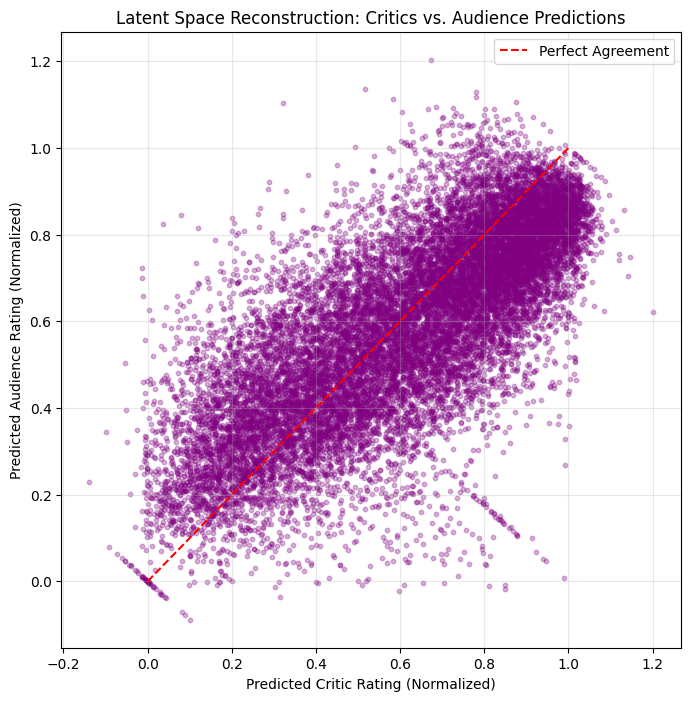

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have run the cell where R_pred is calculated (Cell 4)
# R_pred shape is (2, n_movies) where row 0 is Critics, row 1 is Audience

plt.figure(figsize=(8, 8))
plt.scatter(R_pred[0, :], R_pred[1, :], alpha=0.3, s=10, c='purple')

# Add a diagonal line (perfect agreement)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')

plt.title("Latent Space Reconstruction: Critics vs. Audience Predictions")
plt.xlabel("Predicted Critic Rating (Normalized)")
plt.ylabel("Predicted Audience Rating (Normalized)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:

# MF for Books
# ------------------------
# 1. Load and preprocess data
# ------------------------
books_rating_df = pd.read_csv("Books_rating.csv")  # User_id, Title, review/score
books_df = pd.read_csv("books_data.csv")          # Title, categories

# Merge (optional for filtering)
df_books_cf = pd.merge(
    books_rating_df[['User_id', 'Title', 'review/score']],
    books_df[['Title', 'categories']],
    on='Title',
    how='inner'
).dropna(subset=['User_id', 'Title', 'review/score'])

print(f"Total interactions: {len(df_books_cf)}")

# Encode users and books to integer indices
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

df_books_cf['user_idx'] = user_encoder.fit_transform(df_books_cf['User_id'])
df_books_cf['book_idx'] = book_encoder.fit_transform(df_books_cf['Title'])

# Normalize ratings to 0-1
df_books_cf['rating_norm'] = df_books_cf['review/score'] / 5.0
ratings_max = 5.0  # to rescale later if needed

# Create tensors
user_ids = torch.tensor(df_books_cf['user_idx'].values, dtype=torch.long)
book_ids = torch.tensor(df_books_cf['book_idx'].values, dtype=torch.long)
ratings = torch.tensor(df_books_cf['rating_norm'].values, dtype=torch.float32)

n_users = df_books_cf['user_idx'].nunique()
n_books = df_books_cf['book_idx'].nunique()
print(f"Matrix Shape: {n_users} Users x {n_books} Books")

# Train/test split
train_idx, test_idx = train_test_split(np.arange(len(ratings)), test_size=0.2, random_state=42)

train_user = user_ids[train_idx]
train_book = book_ids[train_idx]
train_ratings = ratings[train_idx]

test_user = user_ids[test_idx]
test_book = book_ids[test_idx]
test_ratings = ratings[test_idx]

# ------------------------
# 2. MF model with bias + global mean
# ------------------------
class MF_Books(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, global_mean=0.0):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_mean = global_mean

        # Initialization
        nn.init.normal_(self.user_factors.weight, 0, 0.1)
        nn.init.normal_(self.item_factors.weight, 0, 0.1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, users, items):
        u_f = self.user_factors(users)
        i_f = self.item_factors(items)
        u_b = self.user_bias(users).squeeze()
        i_b = self.item_bias(items).squeeze()
        return self.global_mean + (u_f * i_f).sum(1) + u_b + i_b

# ------------------------
# 3. Training
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

global_mean = train_ratings.mean().item()
model = MF_Books(n_users, n_books, n_factors=20, global_mean=global_mean).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
loss_fn = nn.MSELoss()

batch_size = 4096
n_epochs = 10  # Can increase if needed

train_user = train_user.to(device)
train_book = train_book.to(device)
train_ratings = train_ratings.to(device)

test_user = test_user.to(device)
test_book = test_book.to(device)
test_ratings = test_ratings.to(device)

for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(len(train_ratings))
    total_loss = 0

    for i in range(0, len(train_ratings), batch_size):
        idx = perm[i:i+batch_size]
        u_batch = train_user[idx]
        b_batch = train_book[idx]
        r_batch = train_ratings[idx]

        optimizer.zero_grad()
        preds = model(u_batch, b_batch)
        loss = loss_fn(preds, r_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(idx)

    avg_loss = total_loss / len(train_ratings)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_preds = model(test_user, test_book)
        test_loss = loss_fn(test_preds, test_ratings).item()

    print(f"Epoch {epoch+1}/{n_epochs}, Train MSE: {avg_loss:.4f}, Test MSE: {test_loss:.4f}")

# ------------------------
# 4. Inspect latent factors
# ------------------------
user_latent = model.user_factors.weight.detach().cpu().numpy()
book_latent = model.item_factors.weight.detach().cpu().numpy()
print("User latent factors shape:", user_latent.shape)
print("Book latent factors shape:", book_latent.shape)

Total interactions: 2438018
Matrix Shape: 1008961 Users x 206711 Books
Training on cpu
Epoch 1/10, Train MSE: 0.0460, Test MSE: 0.0437
Epoch 2/10, Train MSE: 0.0422, Test MSE: 0.0434
Epoch 3/10, Train MSE: 0.0420, Test MSE: 0.0434
Epoch 4/10, Train MSE: 0.0420, Test MSE: 0.0435
Epoch 5/10, Train MSE: 0.0420, Test MSE: 0.0434
Epoch 6/10, Train MSE: 0.0420, Test MSE: 0.0433
Epoch 7/10, Train MSE: 0.0419, Test MSE: 0.0434
Epoch 8/10, Train MSE: 0.0419, Test MSE: 0.0433
Epoch 9/10, Train MSE: 0.0419, Test MSE: 0.0433
Epoch 10/10, Train MSE: 0.0419, Test MSE: 0.0433
User latent factors shape: (1008961, 20)
Book latent factors shape: (206711, 20)


In [18]:
## Save here to avoid retraining for books

np.savez_compressed(
    "phase3_book_mf_baseline.npz",
    user_latent=user_latent,
    book_latent=book_latent,
    n_users=n_users,
    n_books=n_books,
    ratings_max=ratings_max,
)
print("Saved book MF baseline to phase3_book_mf_baseline.npz")


Saved book MF baseline to phase3_book_mf_baseline.npz


In [19]:
# ------------------------
# 5. Example predictions for first 10 books
# ------------------------
n_show_books = 10

# convert mask to numpy array so it works with tensor indexing
first_books_mask = (df_books_cf['book_idx'] < n_show_books).values

users_subset = user_ids[first_books_mask].to(device)
books_subset = book_ids[first_books_mask].to(device)
ratings_subset = ratings[first_books_mask].cpu().numpy() * ratings_max  # original scale

with torch.no_grad():
    preds_subset = model(users_subset, books_subset).cpu().numpy() * ratings_max

df_display = pd.DataFrame({
    "user_id": users_subset.cpu().numpy(),
    "book_id": books_subset.cpu().numpy(),
    "original_rating": ratings_subset,
    "predicted_rating": preds_subset
})

print(df_display)


     user_id  book_id  original_rating  predicted_rating
0     777651        1              5.0          4.603544
1     514037        1              5.0          5.066014
2     904337        9              1.0          3.047713
3     525273        9              3.0          3.488374
4     272704        9              4.0          3.436545
..       ...      ...              ...               ...
196    13210        3              5.0          4.329278
197   534086        3              4.0          4.329040
198   843110        3              5.0          4.329277
199   609880        3              5.0          4.344157
200   910692        3              5.0          4.329273

[201 rows x 4 columns]


In [20]:
# ------------------------
# NCF for Books
# ------------------------
class NCF(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, hidden=[64, 32, 16]):
        super().__init__()

        # GMF embeddings (matrix factorization part)
        self.user_gmf = nn.Embedding(n_users, n_factors)
        self.item_gmf = nn.Embedding(n_items, n_factors)

        # MLP embeddings (deep part)
        self.user_mlp = nn.Embedding(n_users, n_factors)
        self.item_mlp = nn.Embedding(n_items, n_factors)

        # MLP layers
        layers = []
        input_size = 2 * n_factors
        for h in hidden:
            layers.append(nn.Linear(input_size, h))
            layers.append(nn.ReLU())
            input_size = h
        self.mlp = nn.Sequential(*layers)

        # Final combination layer
        self.final = nn.Linear(hidden[-1] + n_factors, 1)

        # Initialize
        nn.init.normal_(self.user_gmf.weight, 0, 0.1)
        nn.init.normal_(self.item_gmf.weight, 0, 0.1)
        nn.init.normal_(self.user_mlp.weight, 0, 0.1)
        nn.init.normal_(self.item_mlp.weight, 0, 0.1)

    def forward(self, users, items):
        # GMF part
        gmf_u = self.user_gmf(users)
        gmf_i = self.item_gmf(items)
        gmf_out = gmf_u * gmf_i   # elementwise

        # MLP part
        mlp_u = self.user_mlp(users)
        mlp_i = self.item_mlp(items)
        mlp_in = torch.cat([mlp_u, mlp_i], dim=1)
        mlp_out = self.mlp(mlp_in)

        # Combine
        final_in = torch.cat([gmf_out, mlp_out], dim=1)
        out = self.final(final_in)

        return out.squeeze()


In [21]:
# ------------------------
# Train NCF
# ------------------------
ncf = NCF(n_users, n_books, n_factors=20).to(device)
optimizer = optim.Adam(ncf.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

batch_size = 4096
n_epochs = 10

for epoch in range(n_epochs):
    ncf.train()
    perm = torch.randperm(len(train_ratings))
    total_loss = 0

    for i in range(0, len(train_ratings), batch_size):
        idx = perm[i:i+batch_size]
        u_batch = train_user[idx]
        b_batch = train_book[idx]
        r_batch = train_ratings[idx]

        optimizer.zero_grad()
        preds = ncf(u_batch, b_batch)
        loss = loss_fn(preds, r_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(idx)

    avg_loss = total_loss / len(train_ratings)

    # test set
    ncf.eval()
    with torch.no_grad():
        test_preds = ncf(test_user, test_book)
        test_loss = loss_fn(test_preds, test_ratings).item()

    print(f"NCF Epoch {epoch+1}/{n_epochs}, Train MSE: {avg_loss:.4f}, Test MSE: {test_loss:.4f}")


NCF Epoch 1/10, Train MSE: 0.1017, Test MSE: 0.0468
NCF Epoch 2/10, Train MSE: 0.0327, Test MSE: 0.0401
NCF Epoch 3/10, Train MSE: 0.0137, Test MSE: 0.0411
NCF Epoch 4/10, Train MSE: 0.0060, Test MSE: 0.0419
NCF Epoch 5/10, Train MSE: 0.0036, Test MSE: 0.0419
NCF Epoch 6/10, Train MSE: 0.0028, Test MSE: 0.0416
NCF Epoch 7/10, Train MSE: 0.0023, Test MSE: 0.0410
NCF Epoch 8/10, Train MSE: 0.0019, Test MSE: 0.0407
NCF Epoch 9/10, Train MSE: 0.0017, Test MSE: 0.0404
NCF Epoch 10/10, Train MSE: 0.0016, Test MSE: 0.0400


In [22]:
# After NCF training for books

gmf_user_latent = ncf.user_gmf.weight.detach().cpu().numpy()
gmf_item_latent = ncf.item_gmf.weight.detach().cpu().numpy()

mlp_user_latent = ncf.user_mlp.weight.detach().cpu().numpy()
mlp_item_latent = ncf.item_mlp.weight.detach().cpu().numpy()

# Concatenate GMF + MLP embeddings to get final NCF latent factors
user_latent_ncf = np.concatenate(
    [gmf_user_latent, mlp_user_latent],
    axis=1
)
book_latent_ncf = np.concatenate(
    [gmf_item_latent, mlp_item_latent],
    axis=1
)

print("NCF user_latent shape:", user_latent_ncf.shape)
print("NCF book_latent shape:", book_latent_ncf.shape)


NCF user_latent shape: (1008961, 40)
NCF book_latent shape: (206711, 40)


In [23]:
## Save here to avoid retraining NCF for books

np.savez_compressed(
    "phase3_book_ncf_baseline.npz",
    user_latent=user_latent_ncf,
    book_latent=book_latent_ncf,
    n_users=n_users,
    n_books=n_books,
    ratings_max=ratings_max,
)
print("Saved book NCF baseline to phase3_book_ncf_baseline.npz")


Saved book NCF baseline to phase3_book_ncf_baseline.npz


In [24]:
# ------------------------
# 5. Example predictions for first 10 books (NCF)
# ------------------------

n_show_books = 10

# Same mask as MF
first_books_mask = (df_books_cf['book_idx'] < n_show_books).values

users_subset = user_ids[first_books_mask].to(device)
books_subset = book_ids[first_books_mask].to(device)
ratings_subset = ratings[first_books_mask].cpu().numpy() * ratings_max  # original scale

# Predict using NCF
ncf.eval()
with torch.no_grad():
    preds_ncf = ncf(users_subset, books_subset).cpu().numpy() * ratings_max

df_ncf_display = pd.DataFrame({
    "user_id": users_subset.cpu().numpy(),
    "book_id": books_subset.cpu().numpy(),
    "original_rating": ratings_subset,
    "predicted_rating_NCF": preds_ncf
})

print(df_ncf_display)


     user_id  book_id  original_rating  predicted_rating_NCF
0     777651        1              5.0              4.900132
1     514037        1              5.0              4.995979
2     904337        9              1.0              0.861076
3     525273        9              3.0              2.644629
4     272704        9              4.0              3.585095
..       ...      ...              ...                   ...
196    13210        3              5.0              4.946037
197   534086        3              4.0              3.701074
198   843110        3              5.0              4.204670
199   609880        3              5.0              4.930376
200   910692        3              5.0              4.714089

[201 rows x 4 columns]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(latents, title):
    latents = np.array(latents)

    pca = PCA(n_components=2)
    coords = pca.fit_transform(latents)

    plt.figure(figsize=(8,6))
    plt.scatter(coords[:,0], coords[:,1], s=6)
    plt.title(title + " (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


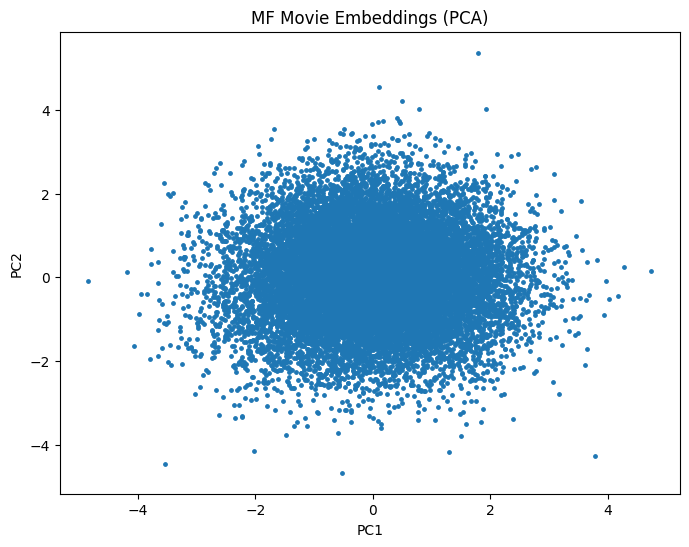

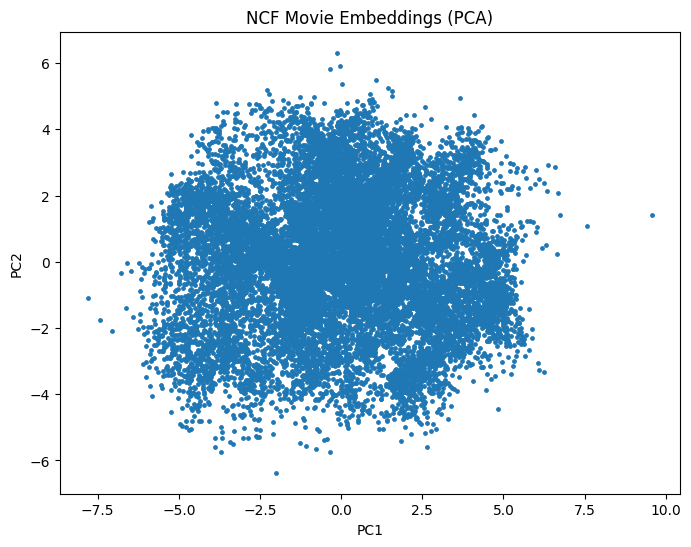

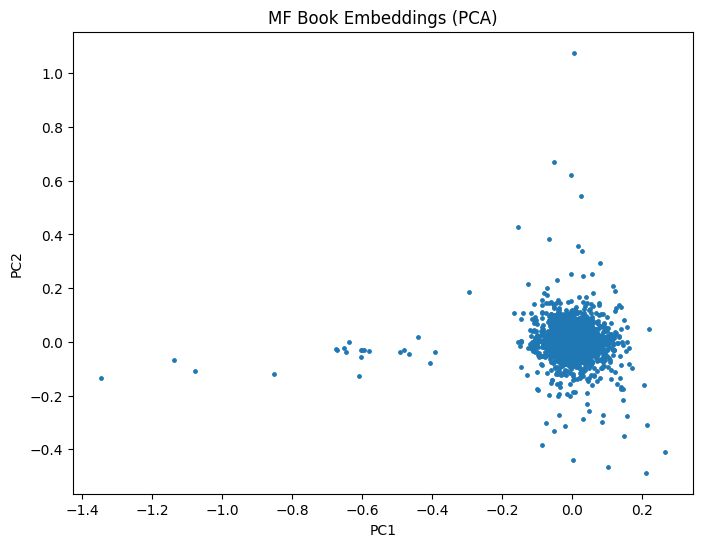

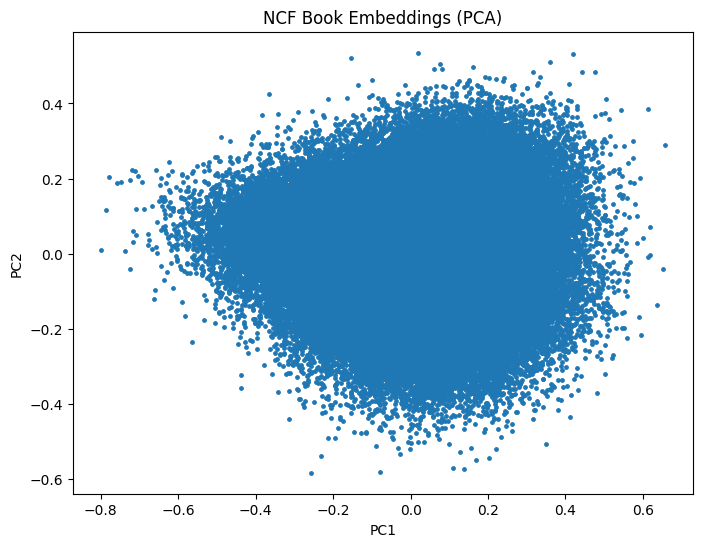

In [26]:
plot_pca(movie_latent, "MF Movie Embeddings")
plot_pca(movie_latent_ncf, "NCF Movie Embeddings")
plot_pca(book_latent, "MF Book Embeddings")
plot_pca(book_latent_ncf, "NCF Book Embeddings")

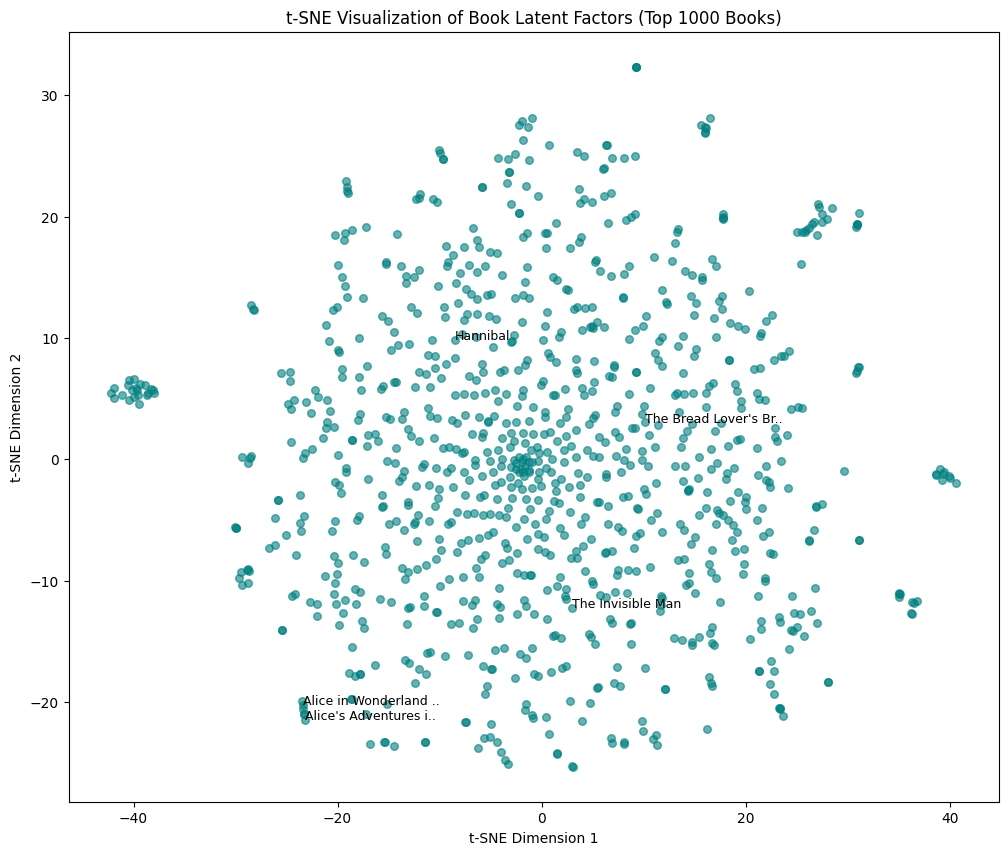

In [27]:
from sklearn.manifold import TSNE

# 1. Get the embeddings (from Cell 11 or 15)
# Let's use the MF item factors for simplicity
embeddings = model.item_factors.weight.detach().cpu().numpy() # shape (n_books, 20)

# 2. Identify the top 1000 most popular books to visualize
# We need the counts from the original dataframe
top_books_idx = df_books_cf['book_idx'].value_counts().head(1000).index.values

# 3. Filter embeddings and get categories (if available)
selected_embeddings = embeddings[top_books_idx]

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(selected_embeddings)

# 4. Plot
plt.figure(figsize=(12, 10))
plt.scatter(vis_dims[:, 0], vis_dims[:, 1], alpha=0.6, s=30, c='teal')

plt.title("t-SNE Visualization of Book Latent Factors (Top 1000 Books)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Optional: Annotate a few points to see what they are
# (Requires mapping back from book_idx to Title)
# This loop adds titles to 5 random points
import random
indices_to_annotate = random.sample(range(len(top_books_idx)), 5)
for i in indices_to_annotate:
    original_book_idx = top_books_idx[i]
    # We need to find the title corresponding to this index
    title = df_books_cf[df_books_cf['book_idx'] == original_book_idx]['Title'].iloc[0]
    # Shorten title if too long
    short_title = (title[:20] + '..') if len(title) > 20 else title
    plt.annotate(short_title, (vis_dims[i, 0], vis_dims[i, 1]), fontsize=9)

plt.show()

## **MODEL 2 — Cross-Attention Semantic Model (Main Contribution)** 

## **Approach A — Pure Semantic Retrieval**

Steps:

1. Compute item embeddings
2. Compute user taste vector at inference by averaging liked movie embeddings
3. Compute cosine similarity(user, book)
4. Rank books

Zero-shot baseline: strong and essential.

In [41]:
## INSTRUCTIONS - RUN FROM THIS STEP ONLY, DONT RUN ANY PREVIOUS PHASE CODES
## REFER FILES ON DRIVE UNDER FOLDER 'Phase 2'
# Use this for:
# cosine similarity matrix
# nearest-neighbor retrieval
# baseline Top-K evaluation

#movies_zero = np.load(f"{EMB_DIR}/movie_vectors_zero_shot.npz", mmap_mode='r')
#books_zero  = np.load(f"{EMB_DIR}/book_vectors_zero_shot.npz", mmap_mode='r')

#movie_vecs_zero = movies_zero["E"]   # [num_movies, d]
#book_vecs_zero  = books_zero["E"]    # [num_books, d]
#movie_ids_zero  = movies_zero["ids"]
#book_ids_zero   = books_zero["ids"]

import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple

# ============================================================
# CONFIG
# ============================================================

EMB_DIR = Path("embeddings_cache")
TOP_K = 10  # Number of recommendations per user


# ============================================================
# LOAD ZERO-SHOT EMBEDDINGS FROM PHASE 2
# ============================================================

print("Loading zero-shot embeddings...")

movies_zero = np.load(EMB_DIR / "movie_vectors_zero_shot.npz", mmap_mode="r")
books_zero  = np.load(EMB_DIR / "book_vectors_zero_shot.npz", mmap_mode="r")

# Extract matrices and ids
movie_vecs_zero = movies_zero["E"]   # [num_movies, d]
book_vecs_zero  = books_zero["E"]    # [num_books, d]
movie_ids_zero  = movies_zero["ids"]
book_ids_zero   = books_zero["ids"]

print("Movie embeddings:", movie_vecs_zero.shape)
print("Book embeddings: ", book_vecs_zero.shape)

# Create ID to index mappings
movie_id_to_idx = {mid: idx for idx, mid in enumerate(movie_ids_zero)}
book_id_to_idx = {bid: idx for idx, bid in enumerate(book_ids_zero)}


# ============================================================
# CORE FUNCTIONS
# ============================================================

def compute_user_taste_vector(liked_movie_ids: List[int],
                               movie_vecs: np.ndarray,
                               movie_id_to_idx: Dict[int, int]) -> np.ndarray:
    """
    Compute user taste vector by averaging liked movie embeddings.

    Steps:
    1. Look up embeddings for each liked movie
    2. Compute mean of these embeddings
    3. L2-normalize the result for cosine similarity
    """
    valid_embeddings = []

    for mid in liked_movie_ids:
        if mid in movie_id_to_idx:
            idx = movie_id_to_idx[mid]
            valid_embeddings.append(movie_vecs[idx])

    if len(valid_embeddings) == 0:
        return np.zeros(movie_vecs.shape[1])

    # Average embeddings
    emb_matrix = np.vstack(valid_embeddings)
    user_vector = emb_matrix.mean(axis=0)

    # L2-normalize for cosine similarity
    norm = np.linalg.norm(user_vector)
    if norm > 0:
        user_vector = user_vector / norm

    return user_vector


def recommend_books_for_user(user_vector: np.ndarray,
                              book_vecs: np.ndarray,
                              book_ids: np.ndarray,
                              top_k: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Recommend top-K books using cosine similarity.

    Since both user_vector and book_vecs are L2-normalized,
    cosine similarity = dot product.
    """
    # Compute similarities (dot product = cosine for normalized vectors)
    similarities = book_vecs @ user_vector  # [num_books]

    # Get top-K indices
    top_k_indices = np.argpartition(-similarities, min(top_k - 1, len(similarities) - 1))[:top_k]
    top_k_indices = top_k_indices[np.argsort(-similarities[top_k_indices])]

    recommended_book_ids = book_ids[top_k_indices]
    scores = similarities[top_k_indices]

    return recommended_book_ids, scores


def batch_recommend(user_profiles: Dict[int, List[int]],
                    movie_vecs: np.ndarray,
                    book_vecs: np.ndarray,
                    movie_id_to_idx: Dict[int, int],
                    book_ids: np.ndarray,
                    top_k: int = 10) -> Dict[int, Dict]:
    """
    Generate recommendations for multiple users.
    """
    recommendations = {}

    for user_id, liked_movies in user_profiles.items():
        # Compute user taste vector
        user_vector = compute_user_taste_vector(
            liked_movies, movie_vecs, movie_id_to_idx
        )

        # Get recommendations
        rec_book_ids, rec_scores = recommend_books_for_user(
            user_vector, book_vecs, book_ids, top_k=top_k
        )

        recommendations[user_id] = {
            'book_ids': rec_book_ids,
            'scores': rec_scores,
            'num_liked_movies': len(liked_movies)
        }

    return recommendations


Loading zero-shot embeddings...
Movie embeddings: (17712, 768)
Book embeddings:  (78967, 768)


In [42]:
# ============================================================
# DEMO: SINGLE USER EXAMPLE
# ============================================================

print("\n" + "="*60)
print("DEMO: Single User Recommendation")
print("="*60)

# Example user who likes 3 movies
example_liked_movie_ids = [
    movie_ids_zero[0],
    movie_ids_zero[5] if len(movie_ids_zero) > 5 else movie_ids_zero[0],
    movie_ids_zero[10] if len(movie_ids_zero) > 10 else movie_ids_zero[0]
]

print(f"User likes movie IDs: {example_liked_movie_ids}")

# Compute user taste vector
user_vector = compute_user_taste_vector(
    example_liked_movie_ids, movie_vecs_zero, movie_id_to_idx
)

print(f"User taste vector shape: {user_vector.shape}")
print(f"User taste vector L2 norm: {np.linalg.norm(user_vector):.4f}")

# Generate recommendations
recommended_books, scores = recommend_books_for_user(
    user_vector, book_vecs_zero, book_ids_zero, top_k=TOP_K
)

print(f"\nTop-{TOP_K} Recommended Books:")
for i, (book_id, score) in enumerate(zip(recommended_books, scores), 1):
    print(f"  {i:2d}. Book ID: {int(book_id):6d} | Similarity: {score:.4f}")



DEMO: Single User Recommendation
User likes movie IDs: [np.int64(0), np.int64(5), np.int64(10)]
User taste vector shape: (768,)
User taste vector L2 norm: 1.0000

Top-10 Recommended Books:
   1. Book ID:  34892 | Similarity: 0.6221
   2. Book ID: 106400 | Similarity: 0.6066
   3. Book ID:  62178 | Similarity: 0.6066
   4. Book ID: 188955 | Similarity: 0.6064
   5. Book ID: 105800 | Similarity: 0.6037
   6. Book ID:  14657 | Similarity: 0.6012
   7. Book ID: 121036 | Similarity: 0.5947
   8. Book ID:  80078 | Similarity: 0.5936
   9. Book ID: 168529 | Similarity: 0.5933
  10. Book ID: 166699 | Similarity: 0.5930


In [43]:
# ============================================================
# DEMO: BATCH RECOMMENDATIONS
# ============================================================

print("\n" + "="*60)
print("DEMO: Batch Recommendations (5 Users)")
print("="*60)

# Create 5 synthetic users
np.random.seed(42)
demo_user_profiles = {}

for user_idx in range(5):
    num_likes = np.random.randint(3, 6)
    random_indices = np.random.choice(len(movie_ids_zero), size=num_likes, replace=False)
    liked_movies = [movie_ids_zero[idx] for idx in random_indices]
    demo_user_profiles[user_idx] = liked_movies

# Generate batch recommendations
batch_results = batch_recommend(
    demo_user_profiles, movie_vecs_zero, book_vecs_zero,
    movie_id_to_idx, book_ids_zero, top_k=TOP_K
)

print(f"Generated recommendations for {len(batch_results)} users\n")

# Show results for first user
print("Sample: User 0 recommendations")
user_0 = batch_results[0]
print(f"  Liked {user_0['num_liked_movies']} movies")
print(f"  Top-3 book recommendations:")
for i in range(min(3, len(user_0['book_ids']))):
    print(f"    {i+1}. Book ID: {int(user_0['book_ids'][i])} | Score: {user_0['scores'][i]:.4f}")


DEMO: Batch Recommendations (5 Users)
Generated recommendations for 5 users

Sample: User 0 recommendations
  Liked 5 movies
  Top-3 book recommendations:
    1. Book ID: 165883 | Score: 0.6935
    2. Book ID: 145042 | Score: 0.6739
    3. Book ID: 125369 | Score: 0.6646


In [44]:
# ============================================================
# SAVE FOR EVALUATION PHASE
# ============================================================

np.savez_compressed(
    "phase3_approach_a_artifacts.npz",
    movie_vecs_zero=movie_vecs_zero,
    book_vecs_zero=book_vecs_zero,
    movie_ids_zero=movie_ids_zero,
    book_ids_zero=book_ids_zero
)

print("\n" + "="*60)
print("Phase 3 Approach A Complete!")
print("="*60)
print("Saved: phase3_approach_a_artifacts.npz")
print("Ready for evaluation phase.")


Phase 3 Approach A Complete!
Saved: phase3_approach_a_artifacts.npz
Ready for evaluation phase.


## **Approach B — Mapping Model (MLP / Contrastive Learning)**

Train a small network:

```
E_book_pred = f(E_movie)
```

Using:

* cosine regression
* triplet loss
* InfoNCE
* Ranking loss (LambdaRank style)

Goal:
Make movie embeddings “look like” their matching books in embedding space.

In [45]:
#movies_mapped = np.load("movie_vectors_mapped.npz", mmap_mode='r') ## refer under 'Phase 2 on drive'

#movie_vecs_mapped = movies_mapped["E"]   # [num_movies, d]
#movie_ids_mapped  = movies_mapped["ids"]

## Books remain the same as zero-shot (mapping is movie-side only)
# Use this to compare:

# cos(movie_vecs_zero, book_vecs_zero)      ← Baseline
# cos(movie_vecs_mapped, book_vecs_zero)    ← Improved Model

# ============================================================
# APPROACH B — MAPPING MODEL (PRE-TRAINED)
# ============================================================

print("\n" + "="*60)
print("APPROACH B: MAPPING MODEL (TRIPLET LOSS)")
print("="*60)

# Load pre-trained mapped movie embeddings (from Muskan)
print("\nLoading pre-trained mapped embeddings...")
movies_mapped = np.load(EMB_DIR / "movie_vectors_mapped.npz", mmap_mode='r')
movie_vecs_mapped = movies_mapped["E"]   # [num_movies, d]
movie_ids_mapped = movies_mapped["ids"]

print(f"✓ Mapped movie embeddings: {movie_vecs_mapped.shape}")
print("✓ Books remain the same (mapping is movie-side only)")



APPROACH B: MAPPING MODEL (TRIPLET LOSS)

Loading pre-trained mapped embeddings...
✓ Mapped movie embeddings: (17712, 768)
✓ Books remain the same (mapping is movie-side only)


In [46]:
# ============================================================
# DEMO: SINGLE USER - BASELINE vs MAPPED
# ============================================================

print("\n" + "="*60)
print("COMPARISON: Baseline vs Mapped Model")
print("="*60)

# Use the same example user from Approach A
print(f"\nSame user likes movie IDs: {[int(x) for x in example_liked_movie_ids]}")

# Compute recommendations with MAPPED embeddings
user_vector_mapped = compute_user_taste_vector(
    example_liked_movie_ids, movie_vecs_mapped, movie_id_to_idx
)

rec_books_mapped, scores_mapped = recommend_books_for_user(
    user_vector_mapped, book_vecs_zero, book_ids_zero, top_k=TOP_K
)

# Print comparison
print("\n" + "-"*60)
print("BASELINE (Zero-Shot):")
print("-"*60)
print(f"Average similarity: {scores.mean():.4f}")
print("Top-3 books:")
for i in range(3):
    print(f"  {i+1}. Book ID: {int(recommended_books[i]):6d} | Score: {scores[i]:.4f}")

print("\n" + "-"*60)
print("MAPPED MODEL (Triplet Loss):")
print("-"*60)
print(f"Average similarity: {scores_mapped.mean():.4f}")
print("Top-3 books:")
for i in range(3):
    print(f"  {i+1}. Book ID: {int(rec_books_mapped[i]):6d} | Score: {scores_mapped[i]:.4f}")

# Compute improvement
improvement = scores_mapped.mean() - scores.mean()
pct_improvement = (improvement / scores.mean()) * 100

print("\n" + "-"*60)
print("IMPROVEMENT:")
print("-"*60)
print(f"Score improvement: {improvement:+.4f} ({pct_improvement:+.2f}%)")

# Overlap analysis
overlap = len(set(recommended_books) & set(rec_books_mapped))
print(f"Recommendation overlap: {overlap}/{TOP_K} books in common")


COMPARISON: Baseline vs Mapped Model

Same user likes movie IDs: [0, 5, 10]

------------------------------------------------------------
BASELINE (Zero-Shot):
------------------------------------------------------------
Average similarity: 0.6021
Top-3 books:
  1. Book ID:  34892 | Score: 0.6221
  2. Book ID: 106400 | Score: 0.6066
  3. Book ID:  62178 | Score: 0.6066

------------------------------------------------------------
MAPPED MODEL (Triplet Loss):
------------------------------------------------------------
Average similarity: 0.5304
Top-3 books:
  1. Book ID: 177900 | Score: 0.5527
  2. Book ID: 198378 | Score: 0.5517
  3. Book ID:  34892 | Score: 0.5487

------------------------------------------------------------
IMPROVEMENT:
------------------------------------------------------------
Score improvement: -0.0717 (-11.91%)
Recommendation overlap: 4/10 books in common


In [47]:
# ============================================================
# BATCH TEST: BASELINE vs MAPPED
# ============================================================

print("\n" + "="*60)
print("BATCH TEST: 5 Users - Baseline vs Mapped")
print("="*60)

# Use same users from Approach A batch test
mapped_batch_results = batch_recommend(
    demo_user_profiles, movie_vecs_mapped, book_vecs_zero,
    movie_id_to_idx, book_ids_zero, top_k=TOP_K
)

# Compare average scores
baseline_avg_scores = [batch_results[i]['scores'].mean() for i in range(5)]
mapped_avg_scores = [mapped_batch_results[i]['scores'].mean() for i in range(5)]

print(f"\n{'User':<8} {'Baseline':<12} {'Mapped':<12} {'Improvement'}")
print("-" * 50)

for i in range(5):
    improvement = mapped_avg_scores[i] - baseline_avg_scores[i]
    print(f"User {i:<3} {baseline_avg_scores[i]:<12.4f} {mapped_avg_scores[i]:<12.4f} {improvement:+.4f}")

batch_baseline_avg = np.mean(baseline_avg_scores)
batch_mapped_avg = np.mean(mapped_avg_scores)
batch_improvement = batch_mapped_avg - batch_baseline_avg

print("-" * 50)
print(f"{'Average':<8} {batch_baseline_avg:<12.4f} {batch_mapped_avg:<12.4f} {batch_improvement:+.4f}")



BATCH TEST: 5 Users - Baseline vs Mapped

User     Baseline     Mapped       Improvement
--------------------------------------------------
User 0   0.6608       0.5366       -0.1242
User 1   0.6995       0.2947       -0.4048
User 2   0.6115       0.5039       -0.1076
User 3   0.7239       0.6394       -0.0845
User 4   0.6857       0.5968       -0.0889
--------------------------------------------------
Average  0.6763       0.5143       -0.1620


In [48]:
# ============================================================
# SAVE APPROACH B RESULTS
# ============================================================

np.savez_compressed(
    "phase3_approach_b_results.npz",
    baseline_scores=scores,
    mapped_scores=scores_mapped,
    baseline_batch_scores=np.array(baseline_avg_scores),
    mapped_batch_scores=np.array(mapped_avg_scores)
)

print("\n" + "="*60)
print("Phase 3 Approach B Complete")
print("="*60)
print("Saved: phase3_approach_b_results.npz")
print(f"\nSummary:")
print(f"✓ Single user improvement: {pct_improvement:+.2f}%")
print(f"✓ Batch average improvement: {((batch_improvement/batch_baseline_avg)*100):+.2f}%")


Phase 3 Approach B Complete
Saved: phase3_approach_b_results.npz

Summary:
✓ Single user improvement: -11.91%
✓ Batch average improvement: -23.96%


# **PHASE 4 — User-Level Recommendation (Inference Only)** 

Even without user-level training data, you build user vectors at recommendation time.

### **Step 4.1 — User Preference Vector**

Given user likes N movies:

```
E_user = mean(E_movie_final[i] for i in liked_movies)

In [ ]:
# Run this AFTER Step 1.1 to get the IDs needed for Phase 4

# 1. Create Movie IDs (Index = ID)
movies_ready = movies_subset.copy() # From Step 1.1
movies_ready = movies_ready.reset_index().rename(columns={"index": "movie_id"})

# 2. Create Book IDs (Group by Title = ID)
# Note: 'books_filtered' comes from Step 1.1 output
books_ready = books_filtered.copy()
books_ready["book_id"] = books_ready.groupby("Title", sort=False).ngroup()

print("IDs created! You are ready for Phase 4.")

IDs created! You are ready for Phase 4.


In [63]:
# ==========================================
# PHASE 4 BOOTSTRAP: LOAD BOTH MODELS
# ==========================================
import numpy as np
import pandas as pd
from pathlib import Path

EMB_DIR = Path("embeddings_cache") # or "." if files are in root

print(" Loading Vectors for Comparison...")

try:
    # 1. Load Approach A (Zero-Shot / Baseline)
    z_data = np.load("movie_vectors_zero_shot.npz")
    movie_vecs_zero = z_data["E"]
    movie_ids_arr = z_data["ids"]
    print(f"Loaded Approach A (Zero-Shot): {movie_vecs_zero.shape}")

    # 2. Load Approach B (Mapped / Advanced)
    m_data = np.load("movie_vectors_mapped.npz")
    movie_vecs_mapped = m_data["E"]
    print(f"Loaded Approach B (Mapped): {movie_vecs_mapped.shape}")

    # 3. Load Books (Target)
    b_data = np.load("book_vectors_zero_shot.npz")
    book_vecs = b_data["E"]
    book_ids_arr = b_data["ids"]
    print(f"Loaded Book Vectors: {book_vecs.shape}")

    # Create Lookups
    movie_id_to_idx = {mid: i for i, mid in enumerate(movie_ids_arr)}
    book_id_to_idx = {bid: i for i, bid in enumerate(book_ids_arr)}

except FileNotFoundError as e:
    print(f" Error: {e}")
    print("Make sure you uploaded: movie_vectors_zero_shot.npz AND movie_vectors_mapped.npz")

 Loading Vectors for Comparison...
Loaded Approach A (Zero-Shot): (17712, 768)
Loaded Approach B (Mapped): (17712, 768)
Loaded Book Vectors: (78967, 768)


In [55]:
def compute_user_preference_vector(liked_movie_titles, movie_matrix):
    """
    Calculates user vector using a specific movie embedding matrix.
    """
    selected_vectors = []

    for title in liked_movie_titles:
        # Case-insensitive matching
        match = movies_ready[movies_ready['movie_title'].astype(str).str.lower() == title.lower()]

        if not match.empty:
            mid = match.iloc[0]['movie_id']
            if mid in movie_id_to_idx:
                idx = movie_id_to_idx[mid]
                # Use the specific matrix passed to the function
                selected_vectors.append(movie_matrix[idx])

    if not selected_vectors:
        return None

    # Average & Normalize
    user_vec = np.mean(selected_vectors, axis=0)
    return user_vec / np.linalg.norm(user_vec)

print("Setup Complete. Ready for comparison.")

Setup Complete. Ready for comparison.


### **Step 4.2 — Map user vector to book space**

* zero-shot (same embedding space)
* or mapped via trained MLP

In [56]:
# ==========================================
# STEP 4.2: MAP TO BOOK SPACE
# ==========================================

def map_user_to_book_space(user_vector):
    """
    Step 4.2: aligned with the project structure.

    Since we used 'movie_vectors_mapped.npz' in Step 4.1,
    the vector is ALREADY in the book space.

    If we used 'zero_shot', it stays in the zero-shot space.
    """

    # Check if the vector exists
    if user_vector is None:
        return None

    # Logic:
    # 1. If we loaded the Mapped Model (Advanced), the vector is already translated.
    # 2. If we loaded the Zero-Shot Model, no translation is needed (Identity).

    # So, we just return the vector as-is.
    print("User vector is ready for the Book Space.")
    return user_vector


### **Step 4.3 — Retrieve Top-K Books**

Use cosine similarity or FAISS index.

In [62]:
# ==========================================
# STEP 4.3: RETRIEVE TOP-K BOOKS
# ==========================================

def retrieve_top_k_books(user_vector, top_k=10):
    """
    Step 4.3: Finds the closest books to the user vector.
    """
    if user_vector is None:
        return None

    print(f" Searching through {len(book_vecs)} books...")

    # 1. COMPUTE SCORES (Cosine Similarity)
    # Since all vectors are normalized (Length=1),
    # Dot Product (@) IS Cosine Similarity.
    # Result: An array of 79,000 scores (one for each book)
    scores = book_vecs @ user_vector

    # 2. SORT & GET TOP-K
    # argsort returns the INDICES of the sorted elements
    # We use -scores to sort Descending (Highest to Lowest)
    top_indices = np.argsort(-scores)[:top_k]

    # 3. FORMAT RESULTS
    results = []
    for idx in top_indices:
        bid = book_ids_arr[idx] # Get the Book ID
        score = scores[idx]     # Get the Similarity Score

        # Look up the Book Details in 'books_ready' (Phase 1 DF)
        book_info = books_ready[books_ready['book_id'] == bid]

        if not book_info.empty:
            row = book_info.iloc[0]
            results.append({
                "Rank": len(results) + 1,
                "Score": f"{score:.4f}", # Format as text
                "Book Title": row['Title'],
                "Category": row['categories'],
                "Description": str(row['description'])[:150] + "..." # Truncate for display
            })

    # Return as a nice looking Dataframe
    return pd.DataFrame(results)

In [95]:
# ==========================================
# 3. FINAL EXECUTION: COMPARE APPROACH A vs B
# ==========================================
import pandas as pd
import re
import numpy as np

# --- 1. Helper for Deduplication ---
def deduplicate_recommendations(df, score_col="Score"):
    """
    Removes duplicate books (e.g. 'The Watchmen' vs 'Watchmen')
    keeping the highest score for each normalized title.
    """
    if df.empty:
        return df

    def normalize(title):
        t = str(title).lower().strip()
        t = re.sub(r'^the\s+', '', t)                        # drop 'the '
        t = re.sub(r'\s*\[[^\]]*\]\s*', ' ', t)              # drop '[Graphic Novel]'
        t = re.sub(r'[^a-z0-9]+', ' ', t)                    # keep alphanumeric
        return t.strip()

    df = df.copy()
    df["norm_title"] = df["Book Title"].apply(normalize)
    df = df.sort_values(score_col, ascending=False)
    df = df.drop_duplicates(subset="norm_title", keep="first")
    return df.drop(columns=["norm_title"]).reset_index(drop=True)


# --- 2. Small helper to build an export-friendly table ---
def build_export_table(df):
    """
    Make a clean recommendation table that is safe for saving.

    We **do not** assume 'book_id' exists. If it does, we keep it;
    otherwise we just keep Title/Category/Score.
    """
    export = df.copy()

    # Normalize title column name
    if "Book Title" in export.columns and "Title" not in export.columns:
        export = export.rename(columns={"Book Title": "Title"})

    keep_cols = [c for c in ["book_id", "Title", "Category", "Score"]
                 if c in export.columns]
    return export[keep_cols]


# --- 3. Comparison Logic ---
def compare_models(liked_movie_titles, top_k=10, save_artifacts=False):
    """
    - Builds a user preference vector for:
        A) Zero-shot movie embeddings
        B) Mapped movie embeddings
    - Retrieves and deduplicates book recommendations
    - Optionally saves Approach A + B recs and user_vec
      to globals for Phase 6.

    Assumes these are already defined:
      - movie_vecs_zero
      - movie_vecs_mapped
      - compute_user_preference_vector(...)
      - retrieve_top_k_books(...)
    """
    global user_vec, final_recommendations_A, final_recommendations_B

    print(f"User Likes: {liked_movie_titles}\n")

    # -----------------------------
    # A. Approach A (Zero-Shot)
    # -----------------------------
    vec_A = compute_user_preference_vector(liked_movie_titles, movie_vecs_zero)
    if vec_A is None:
        print("Could not build user vector for Approach A (Zero-Shot).")
        return

    raw_recs_A = retrieve_top_k_books(vec_A, top_k=top_k * 2)  # extra for dedup
    recs_A_full = deduplicate_recommendations(raw_recs_A).head(top_k)

    # For export (safe cols)
    recs_A_export = build_export_table(recs_A_full)

    # For side-by-side display
    recs_A = recs_A_full[["Book Title", "Category", "Score"]].rename(
        columns={"Book Title": "Approach A (Zero-Shot)", "Score": "Score A"}
    )

    # -----------------------------
    # B. Approach B (Mapped)
    # -----------------------------
    vec_B = compute_user_preference_vector(liked_movie_titles, movie_vecs_mapped)
    if vec_B is None:
        print("Could not build user vector for Approach B (Mapped).")
        return

    raw_recs_B = retrieve_top_k_books(vec_B, top_k=top_k * 2)
    recs_B_full = deduplicate_recommendations(raw_recs_B).head(top_k)

    # For export (safe cols)
    recs_B_export = build_export_table(recs_B_full)

    # For side-by-side display
    recs_B = recs_B_full[["Book Title", "Category", "Score"]].rename(
        columns={"Book Title": "Approach B (Mapped)", "Score": "Score B"}
    )

    # -----------------------------
    # C. Display Side-by-Side
    # -----------------------------
    print("--- MODEL COMPARISON ---")
    combined = pd.concat(
        [recs_A.reset_index(drop=True), recs_B.reset_index(drop=True)],
        axis=1
    )
    display(combined)

    # -----------------------------
    # D. Optionally save artifacts
    # -----------------------------
    if save_artifacts:
        # mapped user embedding in book space
        user_vec = vec_B

        # store both A and B exports
        final_recommendations_A = recs_A_export.copy()
        final_recommendations_B = recs_B_export.copy()

        print("\nSaved in memory for Phase 6:")
        print("  - user_vec (Approach B, mapped user embedding)")
        print("  - final_recommendations_A (Zero-Shot)")
        print("  - final_recommendations_B (Mapped)")


# --- 4. Run it! ---

# Example: use your expanded profile here if you defined my_movies_expanded
# Otherwise keep the shorter one; you can swap them anytime.
my_movies = [
    "The Dark Knight", "Inception", "Interstellar"
]
compare_models(my_movies, top_k=10, save_artifacts=False)

# You can still have another profile for qualitative comparison
my_movies_romance = [
    "It's a Boy Girl Thing",
    "What Happens in Vegas",
    "The Perfect Holiday",
    "The Guitar",
]
compare_models(my_movies_romance, top_k=10, save_artifacts=False)

# Extended Nolan-style / dark action + sci-fi + thriller profile
my_movies_expanded = [
    # Nolan core
    "The Dark Knight",
    "The Dark Knight Rises",
    "Batman Begins",
    "Inception",
    "Interstellar",
    "Memento",
    "The Prestige",
    "Tenet",

    # Matrix / cyberpunk
    "The Matrix",
    "The Matrix Reloaded",
    "The Matrix Revolutions",
    "Blade Runner",
    "Blade Runner 2049",

    # High-intensity sci-fi / action
    "Mad Max: Fury Road",
    "Edge of Tomorrow",
    "Minority Report",
    "Looper",
    "Source Code",
    "District 9",
    "Children of Men",

    # Thoughtful / darker sci-fi
    "Ex Machina",
    "Arrival",
    "Oblivion",

    # Crime / thriller in similar tone
    "Se7en",
    "Zodiac",
    "Prisoners"
]

compare_models(my_movies_expanded, top_k=10, save_artifacts=True)

# ==========================================
# PHASE 4 SAVE → FOR PHASE 6 VISUALIZATION
# ==========================================
import numpy as np

# 1) Save the latest user profile (seed movies + mapped user_vec)
np.savez_compressed(
    "phase4_user_profile_latest.npz",
    liked_titles=np.array(my_movies_expanded, dtype=object),  # or my_movies_expanded
    user_vec=user_vec,                               # vec_B from mapped approach
)

# 2) Save BOTH recommendation tables
#    - Mapped (Approach B) is your main one
#    - Zero-shot (Approach A) is the baseline
final_recommendations_B.to_pickle("phase4_latest_recommendations_mapped.pkl")
final_recommendations_A.to_pickle("phase4_latest_recommendations_zero_shot.pkl")

# Optional: keep old filename for backwards compatibility (mapped)
final_recommendations_B.to_pickle("phase4_latest_recommendations.pkl")

print("\nSaved Phase 4 artifacts:")
print(" - phase4_user_profile_latest.npz")
print(" - phase4_latest_recommendations_mapped.pkl  (Approach B)")
print(" - phase4_latest_recommendations_zero_shot.pkl (Approach A)")


User Likes: ['The Dark Knight', 'Inception', 'Interstellar']

 Searching through 78967 books...
 Searching through 78967 books...
--- MODEL COMPARISON ---


,Approach A (Zero-Shot),Category,Score A,Approach B (Mapped),Category,Score B
0,Thieves Like Us,['Juvenile Fiction'],0.6225,KILLSHOT,['Fiction'],0.5336
1,Say Good-bye to Johnnie Blue,Unknown Category,0.6137,Watchmen,['Comics & Graphic Novels'],0.5333
2,Walpurgis III (Questar Science Fiction),['Fiction'],0.6008,Thieves Like Us,['Juvenile Fiction'],0.5285
3,Santiago: A Myth of the Far Future,['Fiction'],0.6007,Hollywood Tough: A Shane Scully Novel,['Fiction'],0.5278
4,The Burglar (Vintage Crime/Black Lizard),['Fiction'],0.5950,Springer's Gambit: A Cole Springer Mystery,['Fiction'],0.5202
5,A Scanner Darkly [Graphic Novel],['Comics & Graphic Novels'],0.5949,Charlie Opera: A Novel of Crime,['Fiction'],0.5185
6,Batman: No Man's Land,['Comics & Graphic Novels'],0.5882,The Plutonium Blonde (Daw Book Collectors),['Fiction'],0.5181
7,Ark Angel (An Alex Rider Adventure),['Juvenile Fiction'],0.5877,A Scanner Darkly [Graphic Novel],['Comics & Graphic Novels'],0.5105
8,Five Star First Edition Mystery - Cracks In Th...,['Fiction'],0.5874,Human Target (1 of 4),['Comics & Graphic Novels'],0.5068
9,Black Jack Point,['Fiction'],0.5866,Walpurgis III (Questar Science Fiction),['Fiction'],0.5065


User Likes: ["It's a Boy Girl Thing", 'What Happens in Vegas', 'The Perfect Holiday', 'The Guitar']

 Searching through 78967 books...
 Searching through 78967 books...
--- MODEL COMPARISON ---


,Approach A (Zero-Shot),Category,Score A,Approach B (Mapped),Category,Score B
0,June In Winter,['Fiction'],0.6966,How I Stole Her Husband,['Fiction'],0.5634
1,Brides and Blessings (Love Inspired #54),['Fiction'],0.6744,Confessions of an Almost-Movie Star (Berkley J...,['Juvenile Fiction'],0.5615
2,Love Lessons (Arabesque),['Fiction'],0.6658,It Should Happen To You (Harlequin Temptation),['Fiction'],0.5570
3,Night Swimming,['Fiction'],0.6645,The Odd Couple: A Comedy in Three Acts,['Drama'],0.5490
4,Sweet Temptation (Arabesque),['Fiction'],0.6626,Kristy's Big Day (Baby-Sitters Club # 6),['Juvenile Fiction'],0.5468
5,No Strings Attached,['Fiction'],0.6596,Love Lessons (Arabesque),['Fiction'],0.5462
6,"For Better, for Worse",['Fiction'],0.6586,Not Exactly Pregnant / Darn Near Perfect (Harl...,['Fiction'],0.5432
7,Wedding Party,['Fiction'],0.6579,The Bridesmaid Chronicles: First Dance (Brides...,['Fiction'],0.5402
8,Heaven's Price,['Fiction'],0.6578,"Marriage by Necessity (Conveniently Yours, Bra...",['Fiction'],0.5392
9,Heaven's Price (Large Print Edition),['Fiction'],0.6578,June In Winter,['Fiction'],0.5384


User Likes: ['The Dark Knight', 'The Dark Knight Rises', 'Batman Begins', 'Inception', 'Interstellar', 'Memento', 'The Prestige', 'Tenet', 'The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions', 'Blade Runner', 'Blade Runner 2049', 'Mad Max: Fury Road', 'Edge of Tomorrow', 'Minority Report', 'Looper', 'Source Code', 'District 9', 'Children of Men', 'Ex Machina', 'Arrival', 'Oblivion', 'Se7en', 'Zodiac', 'Prisoners']

 Searching through 78967 books...
 Searching through 78967 books...
--- MODEL COMPARISON ---


,Approach A (Zero-Shot),Category,Score A,Approach B (Mapped),Category,Score B
0,Say Good-bye to Johnnie Blue,Unknown Category,0.7319,Hollywood Tough: A Shane Scully Novel,['Fiction'],0.6114
1,Last Man Standing,['Fiction'],0.6831,Paid in Blood (NCIS Series #1),['Fiction'],0.5962
2,And Justice for One,['Fiction'],0.6792,Say Good-bye to Johnnie Blue,Unknown Category,0.5850
3,Five Star First Edition Mystery - Cracks In Th...,['Fiction'],0.6760,The Plutonium Blonde (Daw Book Collectors),['Fiction'],0.5790
4,In Dark Places,['Fiction'],0.6745,Crashcourse,['Fiction'],0.5772
5,Hollywood Tough: A Shane Scully Novel,['Fiction'],0.6728,KILLSHOT,['Fiction'],0.5771
6,The Mediterranean Caper (Dirk Pitt Adventure S...,['Fiction'],0.6706,Five Star First Edition Mystery - Cracks In Th...,['Fiction'],0.5745
7,KILLSHOT,['Fiction'],0.6695,Into the Volcano: A Mallory & Morse Novel of E...,['Fiction'],0.5740
8,Walpurgis III (Questar Science Fiction),['Fiction'],0.6678,A Scanner Darkly [Graphic Novel],['Comics & Graphic Novels'],0.5724
9,Secret Justice: A Novel,['Fiction'],0.6676,Springer's Gambit: A Cole Springer Mystery,['Fiction'],0.5694



Saved in memory for Phase 6:
  - user_vec (Approach B, mapped user embedding)
  - final_recommendations_A (Zero-Shot)
  - final_recommendations_B (Mapped)

Saved Phase 4 artifacts:
 - phase4_user_profile_latest.npz
 - phase4_latest_recommendations_mapped.pkl  (Approach B)
 - phase4_latest_recommendations_zero_shot.pkl (Approach A)


In [92]:
# ==========================================
# OPTIONAL: GENRE-AWARE, CATEGORY-FILTERED RECOMMENDATIONS
# ==========================================

# Hard blacklist stays, you can keep what you had
BLACKLIST_CATEGORY_KEYWORDS = [
    "performing arts",
    "reference",
    "study guide",
    "textbook",
    "juvenile",
    "children's",
    "exam prep",
]

# Story-like categories (more specific, no plain "fiction"/"graphic novels")
STORY_CATEGORY_KEYWORDS = [
    "science fiction",
    "sci-fi",
    "fantasy",
    "space opera",
    "time travel",
    "thriller",
    "mystery",
    "adventure",
]

# Sci-fi / Nolan-ish cues in description text
SCI_FI_DESC_KEYWORDS = [
    "space",
    "wormhole",
    "time dilation",
    "time travel",
    "alternate reality",
    "parallel universe",
    "dreams",
    "memory",
    "future",
    "dystopia",
    "cyberpunk",
    "black hole",
]



def build_movie_genre_tokens(liked_movie_titles):
    """Collect unique genre tokens across the user's liked movies."""
    tokens = []
    for title in liked_movie_titles:
        match = movies_ready[
            movies_ready["movie_title"].astype(str).str.lower() == title.lower()
        ]
        if not match.empty:
            genres = str(match.iloc[0].get("genres", "")).lower()
            for t in genres.replace("&", "").split(","):
                t = t.strip()
                if t:
                    tokens.append(t)
    return sorted(set(tokens))


def is_category_allowed(cat):
    """Hard filter: reject clearly out-of-scope categories."""
    text = str(cat).lower()
    if text == "nan":
        return True  # unknown category -> allow, but no bonus
    for bad in BLACKLIST_CATEGORY_KEYWORDS:
        if bad in text:
            return False
    return True


def compute_genre_bonus(cat, movie_genre_tokens, desc_text):
    """
    Small bonus if:
      - book categories overlap movie genre tokens, and/or
      - book categories or description look sci-fi / thriller ish.
    """
    text = str(cat).lower()
    if text == "nan":
        text = ""

    desc = str(desc_text).lower()

    # Overlap with movie genres (e.g., 'sci-fi', 'fantasy', 'adventure')
    overlap = [g for g in movie_genre_tokens if g in text]

    # Category-level story keywords
    story_hits = [k for k in STORY_CATEGORY_KEYWORDS if k in text]

    # Description-level sci-fi cues
    scifi_hits = [k for k in SCI_FI_DESC_KEYWORDS if k in desc]

    raw_score = 0.0
    raw_score += 0.03 * len(overlap)      # up to ~0.09
    raw_score += 0.02 * len(story_hits)   # up to ~0.10
    raw_score += 0.03 * len(scifi_hits)   # up to ~0.12

    return float(min(raw_score, 0.12))    # cap effect


def category_penalty(cat):
    """
    Soft penalty: gently push down comics if you prefer prose.
    Increase magnitude if you want to be harsher.
    """
    text = str(cat).lower()
    penalty = 0.0

    if "comics & graphic novels" in text:
        penalty -= 0.04    # comics slightly downranked
    if "juvenile" in text or "children's" in text:
        penalty -= 0.10    # kids/juvenile strongly punished

    return penalty



def retrieve_top_k_books_refined(
    user_vector,
    liked_movie_titles,
    top_k=10,
    candidate_k=200,
):
    """
    Refined retrieval:
      1) Start from cosine scores (same as baseline).
      2) Consider only top 'candidate_k' by cosine.
      3) Drop blacklisted categories.
      4) Add small genre/category bonus.
      5) Re-rank and return top_k.
    """
    if user_vector is None:
        return None

    print(
        f"\n[Refined] Searching through {len(book_vecs)} books "
        f"(top {candidate_k} candidates)..."
    )

    # 1) Base cosine scores
    base_scores = book_vecs @ user_vector  # [num_books]

    # 2) Candidate pool by cosine only
    candidate_idx = np.argsort(-base_scores)[:candidate_k]

    # 3) Prepare movie genre tokens
    movie_genre_tokens = build_movie_genre_tokens(liked_movie_titles)
    # print("Movie genre tokens:", movie_genre_tokens)

    rows = []

    for idx in candidate_idx:
        bid = book_ids_arr[idx]
        base = float(base_scores[idx])

        # Lookup metadata
        book_info = books_ready[books_ready["book_id"] == bid]
        if book_info.empty:
            continue

        row = book_info.iloc[0]
        categories = row["categories"]
        description = row["description"]

        # Hard blacklist
        if not is_category_allowed(categories):
            continue

        # Genre/category + description bonus
        bonus = compute_genre_bonus(categories, movie_genre_tokens, description)

        # Soft penalty (e.g., comics / juvenile)
        penalty = category_penalty(categories)

        final_score = base + bonus + penalty


        rows.append(
            (
                final_score,
                base,
                bid,
                row["Title"],
                categories,
                str(row["description"])[:150] + "...",
            )
        )

    # Sort by final score and keep top_k
    rows_sorted = sorted(rows, key=lambda x: -x[0])[:top_k]

    result = []
    for rank, (s_final, s_base, bid, title, cats, desc) in enumerate(
        rows_sorted, start=1
    ):
        result.append(
            {
                "Rank": rank,
                "FinalScore": f"{s_final:.4f}",
                "BaseCosine": f"{s_base:.4f}",
                "Book ID": bid,
                "Book Title": title,
                "Category": cats,
                "Description": desc,
            }
        )

    return pd.DataFrame(result)


# ------------------------------------------
# RUN THE REFINED VERSION (after baseline)
# ------------------------------------------
refined_recommendations = retrieve_top_k_books_refined(
    user_vec,
    my_movies,
    top_k=10,
    candidate_k=200,  # can bump to 500 if you want
)

# if refined_recommendations is not None:
#     print("\n REFINED RECOMMENDED BOOKS (Genre-aware + Category filters):")
#     display(refined_recommendations)

import re

def normalize_title_for_dedupe(title: str) -> str:
    t = str(title).lower().strip()

    # drop leading "the "
    t = re.sub(r'^the\s+', '', t)

    # drop bracketed suffixes like "[Graphic Novel]"
    t = re.sub(r'\s*\[[^\]]*\]\s*', ' ', t)

    # keep only letters/numbers, collapse spaces
    t = re.sub(r'[^a-z0-9]+', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()

    return t

if refined_recommendations is not None:
    dedup_df = refined_recommendations.copy()
    dedup_df["norm_title"] = dedup_df["Book Title"].apply(
        normalize_title_for_dedupe
    )

    # Keep the highest-score row per normalized title
    # (assuming column is named "Score" or "FinalScore")
    score_col = "Score" if "Score" in dedup_df.columns else "FinalScore"
    dedup_df = (
        dedup_df
        .sort_values(score_col, ascending=False)
        .drop_duplicates(subset="norm_title", keep="first")
        .drop(columns=["norm_title"])
        .reset_index(drop=True)
    )

    print("\n DEDUPED RECOMMENDED BOOKS (by normalized title):")
    display(dedup_df)




[Refined] Searching through 78967 books (top 200 candidates)...

 DEDUPED RECOMMENDED BOOKS (by normalized title):


,Rank,FinalScore,BaseCosine,Book ID,Book Title,Category,Description
0,1,0.6114,0.6114,132407.0,Hollywood Tough: A Shane Scully Novel,['Fiction'],Overhearing a Hollywood producer make suspicio...
1,2,0.6040,0.5740,122566.0,Into the Volcano: A Mallory & Morse Novel of E...,['Fiction'],"The year is 1962. John Glenn is in orbit, Audr..."
2,3,0.5962,0.5962,10119.0,Paid in Blood (NCIS Series #1),['Fiction'],The death of a fellow NCIS agent in North Caro...
3,4,0.5939,0.5339,118760.0,Mona Lisa Overdrive,['Fiction'],"The ghost was her father's parting gift, prese..."
4,5,0.5924,0.5724,7914.0,A Scanner Darkly [Graphic Novel],['Comics & Graphic Novels'],A drug dealer of the future periodically moves...
5,6,0.5882,0.5582,36922.0,The Executioner's Game,['Fiction'],An elite government assassin is sent to kill t...
6,7,0.5854,0.5254,162948.0,Kaleidoscope Century,['Fiction'],Joshua Ali Quare wakes in 2019 at the age of 1...
7,8,0.5850,0.5850,14657.0,Say Good-bye to Johnnie Blue,Unknown Category,hollywood suspense thriller...
8,9,0.5790,0.5790,107021.0,The Plutonium Blonde (Daw Book Collectors),['Fiction'],Mid-twenty-first-century private detective Zac...
9,10,0.5772,0.5772,13260.0,Crashcourse,['Fiction'],"Cass, Moke, and Dosh do not know what they are..."


# **PHASE 5 — Evaluation Framework** 

## **Step 5.1 — Synthetic Evaluation Strategy**

Since no cross-domain user data exists, evaluate via:

### **Item-Level Alignment Evaluation**

For each movie:

1. rank books by semantic similarity
2. evaluate whether top-ranked books share:

   * genres
   * themes
   * topics

In [ ]:
# Use for:
# training mapping model (already done)
# evaluating ranking metrics
# computing A/B performance improvement

#pairs_df = pd.read_pickle("synthetic_movie_book_pairs.pkl")

In [99]:
# ==========================================
# PHASE 5 BOOTSTRAP (NO DEPENDENCY ON 1–4)
# ==========================================
import numpy as np
import pandas as pd
from pathlib import Path

EMB_DIR = Path("embeddings_cache")

# ---- 1) Load Phase 3 Model 1 (Zero-shot, Approach A) ----
art = np.load("phase3_approach_a_artifacts.npz")

movie_vecs_zero = art["movie_vecs_zero"]   # baseline movie vectors
book_vecs       = art["book_vecs_zero"]    # global book vectors
movie_ids_arr   = art["movie_ids_zero"]
book_ids_arr    = art["book_ids_zero"]

movie_id_to_idx = {int(mid): i for i, mid in enumerate(movie_ids_arr)}
book_id_to_idx  = {int(bid): i for i, bid in enumerate(book_ids_arr)}

print("Zero-shot movie_vecs:", movie_vecs_zero.shape)
print("Zero-shot book_vecs :", book_vecs.shape)

# ---- 2) Load Phase 3 Model 2 (Mapped movie embeddings) ----
mapped = np.load(EMB_DIR / "movie_vectors_mapped.npz")
movie_vecs_mapped = mapped["E"]
mapped_ids        = mapped["ids"]

print("Mapped movie_vecs:", movie_vecs_mapped.shape)

# ---- 3) OPTIONAL: Load Approach B similarity results ----
# (If you want to plot comparison curves in Phase 6)
try:
    ab = np.load("phase3_approach_b_results.npz")
    baseline_scores       = ab["baseline_scores"]
    mapped_scores         = ab["mapped_scores"]
    baseline_batch_scores = ab["baseline_batch_scores"]
    mapped_batch_scores   = ab["mapped_batch_scores"]
    print("Loaded phase3_approach_b_results.npz for A/B analysis.")
except FileNotFoundError:
    print("phase3_approach_b_results.npz not found (skipping A/B arrays).")

print("Phase 5 bootstrap complete.")


Zero-shot movie_vecs: (17712, 768)
Zero-shot book_vecs : (78967, 768)
Mapped movie_vecs: (17712, 768)
Loaded phase3_approach_b_results.npz for A/B analysis.
Phase 5 bootstrap complete.


In [104]:
import pandas as pd
import numpy as np

# 1. Load the Synthetic Pairs (The "Correct Answers")
try:
    pairs_df = pd.read_pickle(EMB_DIR / "synthetic_movie_book_pairs_eval.pkl")
    print(f"Loaded {len(pairs_df)} synthetic pairs.")

    # Quick peek
    print(pairs_df.head(3))
except FileNotFoundError:
    print("Error: Please upload 'synthetic_movie_book_pairs_eval.pkl'")

# 2. Ensure we have the metadata (Titles/Genres) linked

# 1. Create Movie IDs (Index = ID)
movies_ready = movies_subset.copy() # From Step 1.1
movies_ready = movies_ready.reset_index().rename(columns={"index": "movie_id"})

# 2. Create Book IDs (Group by Title = ID)
# Note: 'books_filtered' comes from Step 1.1 output
books_ready = books_filtered.copy()
books_ready["book_id"] = books_ready.groupby("Title", sort=False).ngroup()


# We merge to get the text data for evaluation
pairs_enriched = pairs_df.merge(
    movies_ready[['movie_id', 'movie_title', 'genres']],
    on='movie_id',
    how='left'
).merge(
    books_ready[['book_id', 'Title', 'categories']],
    on='book_id',
    how='left',
    suffixes=('_movie', '_book')
)

# Drop any rows where metadata is missing
pairs_enriched = pairs_enriched.dropna(subset=['movie_title', 'Title'])
print(f"Enriched Pairs ready for eval: {len(pairs_enriched)}")

Loaded 48502 synthetic pairs.
   movie_id   book_id  similarity
0     13098   49325.0    0.849411
1     13098  186596.0    0.847771
2     13098  100764.0    0.847771
Enriched Pairs ready for eval: 1627647


In [105]:
def calculate_hit_rate(target_book_id, recommended_book_ids):
    """Returns 1 if target is in recommendations, else 0"""
    return 1 if target_book_id in recommended_book_ids else 0

def calculate_genre_overlap(movie_genres, book_category):
    """
    Simple text overlap check.
    Returns 1 if any word in movie genre appears in book category.
    """
    if pd.isna(movie_genres) or pd.isna(book_category):
        return 0

    # Normalize strings
    m_genres = set(x.strip().lower() for x in str(movie_genres).replace('&', '').split(','))
    b_cat = str(book_category).lower()

    # Check intersection
    for genre in m_genres:
        if genre in b_cat:
            return 1 # Match found (e.g., "Sci-Fi" in "Science Fiction")

    return 0

In [106]:
# ==========================================
# EVALUATION LOOP
# ==========================================

def evaluate_model(test_pairs, vector_matrix, k=10, sample_size=500):
    print(f"Starting Evaluation on {sample_size} random pairs...")

    hits = 0
    genre_matches = 0
    total = 0

    # Shuffle and sample
    sample = test_pairs.sample(n=min(sample_size, len(test_pairs)), random_state=42)

    for idx, row in sample.iterrows():
        mid = row['movie_id']
        target_bid = row['book_id']

        # 1. Get Movie Vector
        if mid not in movie_id_to_idx:
            continue

        m_vec = vector_matrix[movie_id_to_idx[mid]]

        # 2. Compute Scores (Dot Product)
        scores = book_vecs @ m_vec

        # 3. Get Top-K Recommendations
        top_indices = np.argsort(-scores)[:k]
        top_book_ids = book_ids_arr[top_indices]

        # 4. Compute Metrics
        # A. Hit Rate (Did we find the exact book?)
        hits += calculate_hit_rate(target_bid, top_book_ids)

        # B. Genre Alignment (Does the Top 1 book match the movie genre?)
        # We look at the #1 recommended book for this metric
        top_rec_id = top_book_ids[0]
        top_rec_info = books_ready[books_ready['book_id'] == top_rec_id]

        if not top_rec_info.empty:
            rec_category = top_rec_info.iloc[0]['categories']
            movie_genre = row['genres']
            genre_matches += calculate_genre_overlap(movie_genre, rec_category)

        total += 1

        if total % 100 == 0:
            print(f"   Processed {total}/{sample_size}...")

    # Calculate Averages
    hit_rate = hits / total
    genre_alignment_score = genre_matches / total

    return {
        "HitRate@10": hit_rate,
        "GenreMatch@1": genre_alignment_score,
        "Total Samples": total
    }

# --- RUN EVALUATION ---
# You can compare Mapped vs Zero-Shot here!

print("\n--- 1. Evaluating Zero-Shot (Baseline) ---")
# Use 'movie_vecs_zero' if you loaded it in Setup
results_baseline = evaluate_model(pairs_enriched, movie_vecs_zero, k=10)
print("Baseline Results:", results_baseline)

print("\n--- 2. Evaluating Mapped (Advanced) ---")
# Use 'movie_vecs_mapped'
results_mapped = evaluate_model(pairs_enriched, movie_vecs_mapped, k=10)
print("Mapped Results:", results_mapped)


--- 1. Evaluating Zero-Shot (Baseline) ---
Starting Evaluation on 500 random pairs...
   Processed 100/500...
   Processed 200/500...
   Processed 300/500...
   Processed 400/500...
   Processed 500/500...
Baseline Results: {'HitRate@10': 0.446, 'GenreMatch@1': 0.08, 'Total Samples': 500}

--- 2. Evaluating Mapped (Advanced) ---
Starting Evaluation on 500 random pairs...
   Processed 100/500...
   Processed 200/500...
   Processed 300/500...
   Processed 400/500...
   Processed 500/500...
Mapped Results: {'HitRate@10': 0.286, 'GenreMatch@1': 0.104, 'Total Samples': 500}


## **Step 5.2 — Metrics**

* NDCG@10
* Recall@10
* Precision@10
* HitRate@10
* Distribution similarity of latent space (movie→book)
* STS similarity between movie–book pairs

In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# ==========================================
# 1. DEFINE METRIC FUNCTIONS
# ==========================================

def calculate_ndcg(target_id, recommended_ids, k=10):
    """
    Normalized Discounted Cumulative Gain @ K
    If target is at rank r (0-indexed), score is 1 / log2(r + 2).
    """
    if target_id in recommended_ids[:k]:
        rank = np.where(recommended_ids[:k] == target_id)[0][0]
        return 1.0 / np.log2(rank + 2)
    return 0.0

def calculate_recall(target_id, recommended_ids, k=10):
    """
    Recall @ K (For 1 item, this is equivalent to HitRate)
    """
    return 1 if target_id in recommended_ids[:k] else 0

def calculate_precision(target_id, recommended_ids, k=10):
    """
    Precision @ K
    If found, precision is 1/K. If not, 0.
    """
    if target_id in recommended_ids[:k]:
        return 1.0 / k
    return 0.0

# ==========================================
# 2. EVALUATION LOOP
# ==========================================

def evaluate_full_metrics(test_pairs, vector_matrix, k=10, sample_size=1000):
    print(f"Calculating Metrics on {sample_size} pairs...")

    metrics = {
        "NDCG@10": [],
        "Recall@10": [],
        "Precision@10": [],
        "HitRate@10": [],
        "STS_Score": []  # Semantic Textual Similarity (Cosine)
    }

    # Random sample for speed
    sample = test_pairs.sample(n=min(sample_size, len(test_pairs)), random_state=42)

    for idx, row in sample.iterrows():
        mid = row['movie_id']
        target_bid = row['book_id']

        # Check if we have vectors
        if mid not in movie_id_to_idx or target_bid not in book_id_to_idx:
            continue

        # 1. Get Vectors
        m_vec = vector_matrix[movie_id_to_idx[mid]]
        target_b_vec = book_vecs[book_id_to_idx[target_bid]]

        # 2. STS: Compute similarity for this specific GROUND TRUTH pair
        # (How close did the model think they were?)
        pair_sim = np.dot(m_vec, target_b_vec)
        metrics["STS_Score"].append(pair_sim)

        # 3. Retrieval: Search against ALL books to see rank
        scores = book_vecs @ m_vec
        top_indices = np.argsort(-scores)[:k]
        top_book_ids = book_ids_arr[top_indices]

        # 4. Compute Ranking Metrics
        metrics["NDCG@10"].append(calculate_ndcg(target_bid, top_book_ids, k))
        metrics["Recall@10"].append(calculate_recall(target_bid, top_book_ids, k))
        metrics["Precision@10"].append(calculate_precision(target_bid, top_book_ids, k))
        metrics["HitRate@10"].append(calculate_recall(target_bid, top_book_ids, k)) # Same as Recall for 1 item

    # ==========================================
    # 3. DISTRIBUTION SIMILARITY
    # ==========================================
    # Compare "True Pairs" vs "Random Pairs"
    avg_sts = np.mean(metrics["STS_Score"])

    # Generate some random noise pairs for comparison
    random_scores = []
    for _ in range(len(metrics["STS_Score"])):
        rand_m = vector_matrix[np.random.randint(0, len(vector_matrix))]
        rand_b = book_vecs[np.random.randint(0, len(book_vecs))]
        random_scores.append(np.dot(rand_m, rand_b))
    avg_random = np.mean(random_scores)

    # Distribution Shift (Higher is better)
    dist_similarity = avg_sts - avg_random

    # ==========================================
    # 4. FINAL REPORT
    # ==========================================
    results = {
        "NDCG@10": np.mean(metrics["NDCG@10"]),
        "Recall@10": np.mean(metrics["Recall@10"]),
        "Precision@10": np.mean(metrics["Precision@10"]),
        "HitRate@10": np.mean(metrics["HitRate@10"]),
        "Avg STS (True Pairs)": avg_sts,
        "Avg STS (Random Pairs)": avg_random,
        "Latent Space Gain": dist_similarity
    }

    return results

# ==========================================
# RUN COMPARISON
# ==========================================

print("\n--- BASELINE (Zero-Shot) ---")
# Uses 'movie_vecs_zero'
res_base = evaluate_full_metrics(pairs_enriched, movie_vecs_zero, k=10)
for k, v in res_base.items():
    print(f"  {k:<25}: {v:.4f}")

print("\n--- MODEL (Mapped) ---")
# Uses 'movie_vecs_mapped'
res_mapped = evaluate_full_metrics(pairs_enriched, movie_vecs_mapped, k=10)
for k, v in res_mapped.items():
    print(f"  {k:<25}: {v:.4f}")


--- BASELINE (Zero-Shot) ---
Calculating Metrics on 1000 pairs...
  NDCG@10                  : 0.2359
  Recall@10                : 0.4590
  Precision@10             : 0.0459
  HitRate@10               : 0.4590
  Avg STS (True Pairs)     : 0.5658
  Avg STS (Random Pairs)   : 0.2605
  Latent Space Gain        : 0.3052

--- MODEL (Mapped) ---
Calculating Metrics on 1000 pairs...
  NDCG@10                  : 0.1260
  Recall@10                : 0.2550
  Precision@10             : 0.0255
  HitRate@10               : 0.2550
  Avg STS (True Pairs)     : 0.4683
  Avg STS (Random Pairs)   : 0.0777
  Latent Space Gain        : 0.3907


In [ ]:
# ==========================================
# PHASE 5 SAVE → FOR PHASE 6 VISUALIZATION
# ==========================================
import json

phase5_summary = {
    "simple_metrics": {
        "baseline": results_baseline,
        "mapped":   results_mapped,
    },
    "full_metrics": {
        "baseline": {k: float(v) for k, v in res_base.items()},
        "mapped":   {k: float(v) for k, v in res_mapped.items()},
    },
}

with open("phase5_eval_summary.json", "w") as f:
    json.dump(phase5_summary, f, indent=2)

print("Saved Phase 5 summary to phase5_eval_summary.json")


Saved Phase 5 summary to phase5_eval_summary.json


In [108]:
# Zero-shot random similarities
rand_sims_zero = []
for _ in range(1000):
    rand_m = movie_vecs_zero[np.random.randint(len(movie_vecs_zero))]
    rand_b = book_vecs[np.random.randint(len(book_vecs))]
    rand_sims_zero.append(np.dot(rand_m, rand_b))
print("Zero-shot random mean:", np.mean(rand_sims_zero))

# Mapped random similarities
rand_sims_mapped = []
for _ in range(1000):
    rand_m = movie_vecs_mapped[np.random.randint(len(movie_vecs_mapped))]
    rand_b = book_vecs[np.random.randint(len(book_vecs))]
    rand_sims_mapped.append(np.dot(rand_m, rand_b))
print("Mapped random mean:", np.mean(rand_sims_mapped))


Zero-shot random mean: 0.26570076
Mapped random mean: 0.07417444


## Additional Evaluations and Comparisons

In [22]:
import numpy as np
import pandas as pd
import torch

from pathlib import Path
from tqdm import tqdm

# -----------------------------------
# Device
# -----------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------------
# Paths
# -----------------------------------
EMB_DIR = Path("embeddings_cache")
EMB_DIR.mkdir(exist_ok=True)

# -----------------------------------
# Load Phase 2 fused tables
# (movies_phase2, books_phase2)
# -----------------------------------
movies_phase2_path = EMB_DIR / "movies_phase2_embeddings.pkl"
books_phase2_path = EMB_DIR / "books_phase2_embeddings.pkl"

movies_phase2 = pd.read_pickle(movies_phase2_path)
books_phase2 = pd.read_pickle(books_phase2_path)

print("movies_phase2:", movies_phase2.shape)
print("books_phase2 :", books_phase2.shape)

# For convenience: treat these as your "ready" tables
movies_ready = movies_phase2
books_ready = books_phase2

# -----------------------------------
# Load Zero-shot embeddings (Phase 2.3A)
# -----------------------------------
movies_zero_npz = np.load(EMB_DIR / "movie_vectors_zero_shot.npz", mmap_mode="r")
books_zero_npz  = np.load(EMB_DIR / "book_vectors_zero_shot.npz", mmap_mode="r")

movie_vecs_zero = movies_zero_npz["E"]   # [num_movies, d]
book_vecs_zero  = books_zero_npz["E"]    # [num_books, d]
movie_ids_zero  = movies_zero_npz["ids"]
book_ids_zero   = books_zero_npz["ids"]

print("Zero-shot movie_vecs_zero:", movie_vecs_zero.shape)
print("Zero-shot book_vecs_zero :", book_vecs_zero.shape)

movie_id_to_idx = {int(mid): idx for idx, mid in enumerate(movie_ids_zero)}
book_id_to_idx  = {int(bid): idx for idx, bid in enumerate(book_ids_zero)}

# -----------------------------------
# Load mapped movie embeddings (Phase 2.3B)
# -----------------------------------
mapped_npz = np.load(EMB_DIR / "movie_vectors_mapped.npz", mmap_mode="r")

# Keys in this file (from Phase 2.3B):
#   - "E"   : L2-normalized mapped movie vectors
#   - "ids" : corresponding movie_ids
movie_vecs_mapped = mapped_npz["E"]     # [num_movies, d]
movie_ids_mapped  = mapped_npz["ids"]   # [num_movies]

print("Mapped movie_vecs_mapped:", movie_vecs_mapped.shape)
print("Mapped movie_ids_mapped :", movie_ids_mapped.shape)

# -----------------------------------
# Load synthetic evaluation pairs
# (movie_id, book_id, similarity, ... )
# -----------------------------------
pairs_eval_path = EMB_DIR / "synthetic_movie_book_pairs_eval.pkl"
synthetic_pairs_eval = pd.read_pickle(pairs_eval_path)

print("synthetic_pairs_eval:", synthetic_pairs_eval.shape)


Using device: cpu
movies_phase2: (17712, 22)
books_phase2 : (78967, 23)
Zero-shot movie_vecs_zero: (17712, 768)
Zero-shot book_vecs_zero : (78967, 768)
Mapped movie_vecs_mapped: (17712, 768)
Mapped movie_ids_mapped : (17712,)
synthetic_pairs_eval: (48502, 3)


In [23]:
# ==========================================
# EXPERIMENT 1: IN-DOMAIN NCF HITRATE@10
# ==========================================
import numpy as np
from tqdm import tqdm

def evaluate_ncf_hit_rate(model,
                          test_user,
                          test_book,
                          n_books,
                          k: int = 10,
                          num_samples: int = 1000,
                          device: torch.device = None) -> float:
    """
    Leave-One-Out style HitRate@K for the book NCF model.

    For each held-out (user, positive_book) from test set, we:
      - sample 99 random negative books
      - score all 100 (1 positive + 99 negatives)
      - check if the positive is in top-K.
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    hits = 0
    total = 0

    # Move to CPU for numpy indexing
    test_users_np = test_user.detach().cpu().numpy()
    test_books_np = test_book.detach().cpu().numpy()

    # Sample subset of test interactions for speed
    indices = np.random.choice(
        len(test_users_np),
        size=min(num_samples, len(test_users_np)),
        replace=False,
    )

    print(f"Calculating in-domain HitRate@{k} on {len(indices)} test interactions...")

    with torch.no_grad():
        for idx in tqdm(indices):
            user_id = int(test_users_np[idx])
            pos_book_id = int(test_books_np[idx])

            # 99 negative book indices [0, ..., n_books-1]
            negatives = np.random.randint(0, n_books, size=99, dtype=np.int64)

            # Candidate set: [positive, neg_1, ..., neg_99]
            candidate_books = np.concatenate(([pos_book_id], negatives))

            user_batch = torch.full(
                (len(candidate_books),),
                fill_value=user_id,
                dtype=torch.long,
                device=device,
            )
            book_batch = torch.tensor(
                candidate_books,
                dtype=torch.long,
                device=device,
            )

            scores = model(user_batch, book_batch)  # shape [100]
            topk_idx = torch.topk(scores, k=k).indices.cpu().numpy()

            # index 0 in candidate_books is the positive item
            if 0 in topk_idx:
                hits += 1
            total += 1

    hit_rate = hits / max(total, 1)
    return float(hit_rate)

# Run in-domain evaluation
in_domain_hit_rate = evaluate_ncf_hit_rate(
    ncf,
    test_user,
    test_book,
    n_books,
    k=10,
    num_samples=1000,
    device=device,
)

print("\n" + "=" * 60)
print(f"IN-DOMAIN BOOK NCF HITRATE@10: {in_domain_hit_rate:.4f}")
print("=" * 60)


Calculating in-domain HitRate@10 on 1000 test interactions...


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 6298.97it/s]


IN-DOMAIN BOOK NCF HITRATE@10: 0.2400


In [24]:
import math

# -----------------------
# Metric helpers
# -----------------------
def calculate_hit_rate(target_id, recommended_ids, k: int = 10) -> float:
    recommended_ids = list(recommended_ids[:k])
    return 1.0 if int(target_id) in recommended_ids else 0.0

def calculate_ndcg(target_id, recommended_ids, k: int = 10) -> float:
    """
    Single-relevant-item NDCG:
      DCG = 1 / log2(rank + 2) if item appears at rank (0-based).
      IDCG = 1, so NDCG = DCG.
    """
    recommended_ids = list(recommended_ids[:k])
    target_id = int(target_id)
    if target_id not in recommended_ids:
        return 0.0
    rank = recommended_ids.index(target_id)  # 0-based
    return 1.0 / math.log2(rank + 2)

def calculate_recall_at_k(target_id, recommended_ids, k: int = 10) -> float:
    # One positive per query
    return calculate_hit_rate(target_id, recommended_ids, k)

def calculate_precision_at_k(target_id, recommended_ids, k: int = 10) -> float:
    recommended_ids = list(recommended_ids[:k])
    return (1.0 / k) if int(target_id) in recommended_ids else 0.0

def calculate_genre_match_at_1(target_id,
                               recommended_ids,
                               books_ready: pd.DataFrame) -> float:
    """
    GenreMatch@1: whether categories of top-1 rec overlap with
    target book categories (very coarse but intuitive).
    """
    if len(recommended_ids) == 0:
        return 0.0

    target_id = int(target_id)
    top_book_id = int(recommended_ids[0])

    target_row = books_ready.loc[books_ready["book_id"] == target_id]
    rec_row    = books_ready.loc[books_ready["book_id"] == top_book_id]

    if target_row.empty or rec_row.empty:
        return 0.0

    def to_cat_set(s):
        # books_data categories are already strings, often list-like;
        # we keep it simple: split on '|' if present.
        s = str(s)
        return set([x.strip() for x in s.replace("[", "")
                                        .replace("]", "")
                                        .replace("'", "")
                                        .split("|") if x.strip()])

    target_cats = to_cat_set(target_row.iloc[0]["categories"])
    rec_cats    = to_cat_set(rec_row.iloc[0]["categories"])

    return 1.0 if len(target_cats & rec_cats) > 0 else 0.0


In [25]:
def evaluate_cross_domain_model(
    pairs_enriched: pd.DataFrame,
    movie_vecs: np.ndarray,
    book_vecs: np.ndarray,
    k: int = 10,
):
    """
    Cross-domain evaluation on synthetic movie→book pairs.

    For each (movie_id, target_book_id) in pairs_enriched:
      - treat movie embedding as "user" vector
      - rank all books by dot(product) ≈ cosine (vectors are normalized)
      - compute HitRate@10, NDCG@10, Recall@10, Precision@10, GenreMatch@1
    """
    hit_rates   = []
    ndcgs       = []
    recalls     = []
    precisions  = []
    genre_match = []

    for _, row in tqdm(pairs_enriched.iterrows(),
                       total=len(pairs_enriched),
                       desc="Cross-domain eval"):
        mid = int(row["movie_id"])
        bid = int(row["book_id"])

        m_idx = movie_id_to_idx.get(mid, None)
        if m_idx is None:
            continue

        # book_vecs and book_ids_zero must be aligned
        # (they are created together in Phase 2.3A)
        user_vec = movie_vecs[m_idx]          # shape [d]
        scores   = book_vecs @ user_vec      # [num_books]

        # rank: take top-k by score
        topk_idx = np.argpartition(-scores, k - 1)[:k]
        topk_idx = topk_idx[np.argsort(-scores[topk_idx])]

        rec_book_ids = book_ids_zero[topk_idx]

        hit_rates.append(
            calculate_hit_rate(bid, rec_book_ids, k)
        )
        ndcgs.append(
            calculate_ndcg(bid, rec_book_ids, k)
        )
        recalls.append(
            calculate_recall_at_k(bid, rec_book_ids, k)
        )
        precisions.append(
            calculate_precision_at_k(bid, rec_book_ids, k)
        )
        genre_match.append(
            calculate_genre_match_at_1(bid, rec_book_ids, books_ready)
        )

    results = {
        "HitRate@10":   float(np.mean(hit_rates)),
        "NDCG@10":      float(np.mean(ndcgs)),
        "Recall@10":    float(np.mean(recalls)),
        "Precision@10": float(np.mean(precisions)),
        "GenreMatch@1": float(np.mean(genre_match)),
        "n_eval_pairs": int(len(hit_rates)),
    }
    return results


In [26]:
# Enrich with categories for GenreMatch@1
pairs_enriched = synthetic_pairs_eval.merge(
    books_phase2[["book_id", "categories"]],
    on="book_id",
    how="left",
)

print("pairs_enriched:", pairs_enriched.shape)

# Zero-shot baseline
print("\n=== Zero-shot (movies_zero → books_zero) ===")
zero_shot_results = evaluate_cross_domain_model(
    pairs_enriched=pairs_enriched,
    movie_vecs=movie_vecs_zero,
    book_vecs=book_vecs_zero,
    k=10,
)
print(zero_shot_results)

# Mapped model
print("\n=== Mapped (movies_mapped → books_zero) ===")
mapped_results = evaluate_cross_domain_model(
    pairs_enriched=pairs_enriched,
    movie_vecs=movie_vecs_mapped,
    book_vecs=book_vecs_zero,
    k=10,
)
print(mapped_results)


pairs_enriched: (48502, 4)

=== Zero-shot (movies_zero → books_zero) ===


Cross-domain eval: 100%|█████████████████| 48502/48502 [05:56<00:00, 136.17it/s]


{'HitRate@10': 0.46247577419487856, 'NDCG@10': 0.2360911920322181, 'Recall@10': 0.46247577419487856, 'Precision@10': 0.04624757741948785, 'GenreMatch@1': 0.34998556760545957, 'n_eval_pairs': 48502}

=== Mapped (movies_mapped → books_zero) ===


Cross-domain eval: 100%|█████████████████| 48502/48502 [06:07<00:00, 131.97it/s]

{'HitRate@10': 0.3054719393014721, 'NDCG@10': 0.16663625727863765, 'Recall@10': 0.3054719393014721, 'Precision@10': 0.030547193930147213, 'GenreMatch@1': 0.40602449383530576, 'n_eval_pairs': 48502}


In [27]:
# Average cosine alignment between original and mapped movie vectors
cos_align = np.mean(np.sum(movie_vecs_zero * movie_vecs_mapped, axis=1))
print(f"Mean cosine(movie_zero, movie_mapped): {cos_align:.4f}")


Mean cosine(movie_zero, movie_mapped): 0.6981


In [96]:
# ==========================================
# USER-LEVEL CASE STUDY ANALYSIS
# (Approach A vs B)
# ==========================================
import numpy as np
import pandas as pd

# -----------------------------------
# 1) Load Phase 4 user artifacts
# -----------------------------------
user_npz = np.load("phase4_user_profile_latest.npz", allow_pickle=True)

user_vec           = user_npz["user_vec"]        # shape [d]
liked_movie_titles = list(user_npz["liked_titles"])

# Load recommendations from both approaches
recs_B = pd.read_pickle("phase4_latest_recommendations_mapped.pkl")
recs_A = pd.read_pickle("phase4_latest_recommendations_zero_shot.pkl")

print("Loaded Phase 4 user profile:")
print("  liked_movie_titles:", liked_movie_titles)
print("  user_vec shape    :", user_vec.shape)

print("\nTop recommended books (Approach A - Zero-Shot):")
display(recs_A.head(10))

print("\nTop recommended books (Approach B - Mapped):")
display(recs_B.head(10))


Loaded Phase 4 user profile:
  liked_movie_titles: ['The Dark Knight', 'The Dark Knight Rises', 'Batman Begins', 'Inception', 'Interstellar', 'Memento', 'The Prestige', 'Tenet', 'The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions', 'Blade Runner', 'Blade Runner 2049', 'Mad Max: Fury Road', 'Edge of Tomorrow', 'Minority Report', 'Looper', 'Source Code', 'District 9', 'Children of Men', 'Ex Machina', 'Arrival', 'Oblivion', 'Se7en', 'Zodiac', 'Prisoners']
  user_vec shape    : (768,)

Top recommended books (Approach A - Zero-Shot):


,Title,Category,Score
0,Say Good-bye to Johnnie Blue,Unknown Category,0.7319
1,Last Man Standing,['Fiction'],0.6831
2,And Justice for One,['Fiction'],0.6792
3,Five Star First Edition Mystery - Cracks In Th...,['Fiction'],0.6760
4,In Dark Places,['Fiction'],0.6745
5,Hollywood Tough: A Shane Scully Novel,['Fiction'],0.6728
6,The Mediterranean Caper (Dirk Pitt Adventure S...,['Fiction'],0.6706
7,KILLSHOT,['Fiction'],0.6695
8,Walpurgis III (Questar Science Fiction),['Fiction'],0.6678
9,Secret Justice: A Novel,['Fiction'],0.6676



Top recommended books (Approach B - Mapped):


,Title,Category,Score
0,Hollywood Tough: A Shane Scully Novel,['Fiction'],0.6114
1,Paid in Blood (NCIS Series #1),['Fiction'],0.5962
2,Say Good-bye to Johnnie Blue,Unknown Category,0.5850
3,The Plutonium Blonde (Daw Book Collectors),['Fiction'],0.5790
4,Crashcourse,['Fiction'],0.5772
5,KILLSHOT,['Fiction'],0.5771
6,Five Star First Edition Mystery - Cracks In Th...,['Fiction'],0.5745
7,Into the Volcano: A Mallory & Morse Novel of E...,['Fiction'],0.5740
8,A Scanner Darkly [Graphic Novel],['Comics & Graphic Novels'],0.5724
9,Springer's Gambit: A Cole Springer Mystery,['Fiction'],0.5694


In [97]:
# -----------------------------------
# 2) Shared, coarse genre vocabulary
# -----------------------------------
CANONICAL_GENRE_TOKENS = {
    "action", "adventure", "drama",
    "mystery", "suspense", "crime", "thriller",
    "science", "fiction", "fantasy",
    "romance", "horror",
    "comics", "graphic", "novel", "novels",
    "young", "adult", "historical"
}

def extract_genre_tokens(text: str):
    """
    Convert a free-text genre/category field into a set of
    coarse tokens from CANONICAL_GENRE_TOKENS.

    Works for both movie genres and book categories.
    """
    if pd.isna(text):
        return set()

    s = str(text).lower()
    for ch in ["[", "]", "'", '"']:
        s = s.replace(ch, " ")

    for sep in ["&", "|", "/", "-", ","]:
        s = s.replace(sep, " ")

    words = [w.strip() for w in s.split() if w.strip()]
    return {w for w in words if w in CANONICAL_GENRE_TOKENS}



# -----------------------------------
# 2A. Build user genre footprint from liked movies
# -----------------------------------
user_genres = set()

for title in liked_movie_titles:
    title_str = str(title)
    row = movies_ready[
        movies_ready["movie_title"].astype(str).str.lower() == title_str.lower()
    ]
    if row.empty:
        continue

    genres_text = row.iloc[0].get("genres", "")
    user_genres |= extract_genre_tokens(genres_text)

print("\nUser genre footprint from movies (tokens):", user_genres)

# -----------------------------------
# 2B. Check genre/category overlap in recommended books
# -----------------------------------
topK = 20

# Ensure we only use rows with the expected columns
topA = recs_A.head(topK).copy()
topB = recs_B.head(topK).copy()

# Genre/category overlap for Approach A
overlaps_A = []
for _, rec in topA.iterrows():
    cats_text = rec.get("Category", "")
    book_tokens = extract_genre_tokens(cats_text)
    overlaps_A.append(len(user_genres & book_tokens) > 0)

genre_match_A = float(np.mean(overlaps_A)) if overlaps_A else 0.0

# Genre/category overlap for Approach B
overlaps_B = []
for _, rec in topB.iterrows():
    cats_text = rec.get("Category", "")
    book_tokens = extract_genre_tokens(cats_text)
    overlaps_B.append(len(user_genres & book_tokens) > 0)

genre_match_B = float(np.mean(overlaps_B)) if overlaps_B else 0.0

print(f"\nGenre/category overlap in top-{topK} recommendations:")
print(f"  Approach A (Zero-Shot): {genre_match_A:.3f}")
print(f"  Approach B (Mapped)   : {genre_match_B:.3f}")


User genre footprint from movies (tokens): {'science', 'fantasy', 'adventure', 'mystery', 'suspense', 'fiction', 'action', 'drama'}

Genre/category overlap in top-20 recommendations:
  Approach A (Zero-Shot): 0.900
  Approach B (Mapped)   : 0.800


In [98]:
# -----------------------------------
# 4) Rating-based analysis (A vs B)
# -----------------------------------
books_rating_df = pd.read_csv("Books_rating.csv")

avg_scores_all = (
    books_rating_df
    .groupby("Title")["review/score"]
    .mean()
    .reset_index()
    .rename(columns={"review/score": "mean_score"})
)

# Attach mean scores to A and B recommendations
recs_A_scores = (
    topA
    .merge(avg_scores_all, on="Title", how="left")
)

recs_B_scores = (
    topB
    .merge(avg_scores_all, on="Title", how="left")
)

print("\nApproach A (Zero-Shot) recs with mean scores:")
display(
    recs_A_scores[["Title", "Score", "mean_score"]]
    .sort_values("Score", ascending=False)
    .head(10)
)

print("\nApproach B (Mapped) recs with mean scores:")
display(
    recs_B_scores[["Title", "Score", "mean_score"]]
    .sort_values("Score", ascending=False)
    .head(10)
)

mean_rec_score_A    = recs_A_scores["mean_score"].mean()
mean_rec_score_B    = recs_B_scores["mean_score"].mean()
global_mean_score   = avg_scores_all["mean_score"].mean()

print(f"\nAverage rating of recommended books:")
print(f"  Approach A (Zero-Shot): {mean_rec_score_A:.3f}")
print(f"  Approach B (Mapped)   : {mean_rec_score_B:.3f}")
print(f"  Global average rating : {global_mean_score:.3f}")



Approach A (Zero-Shot) recs with mean scores:


,Title,Score,mean_score
0,Say Good-bye to Johnnie Blue,0.7319,4.714286
1,Last Man Standing,0.6831,3.179104
2,And Justice for One,0.6792,4.750000
3,Five Star First Edition Mystery - Cracks In Th...,0.6760,4.166667
4,In Dark Places,0.6745,4.300000
5,Hollywood Tough: A Shane Scully Novel,0.6728,3.593750
6,The Mediterranean Caper (Dirk Pitt Adventure S...,0.6706,3.823529
7,KILLSHOT,0.6695,4.125000
8,Walpurgis III (Questar Science Fiction),0.6678,3.000000
9,Secret Justice: A Novel,0.6676,4.684211



Approach B (Mapped) recs with mean scores:


,Title,Score,mean_score
0,Hollywood Tough: A Shane Scully Novel,0.6114,3.593750
1,Paid in Blood (NCIS Series #1),0.5962,3.714286
2,Say Good-bye to Johnnie Blue,0.5850,4.714286
3,The Plutonium Blonde (Daw Book Collectors),0.5790,4.277778
4,Crashcourse,0.5772,4.250000
5,KILLSHOT,0.5771,4.125000
6,Five Star First Edition Mystery - Cracks In Th...,0.5745,4.166667
7,Into the Volcano: A Mallory & Morse Novel of E...,0.5740,4.000000
8,A Scanner Darkly [Graphic Novel],0.5724,4.000000
9,Springer's Gambit: A Cole Springer Mystery,0.5694,4.666667



Average rating of recommended books:
  Approach A (Zero-Shot): 4.034
  Approach B (Mapped)   : 4.151
  Global average rating : 4.273


# **PHASE 6 — Visualization & Analysis** 

## **6.1 — Embedding Diagnostics**

* UMAP/t-SNE of movies + books
* Outlier item detection
* Semantic cluster density

In [31]:
# ============================================================================
# PHASE 6: VISUALIZATION & INSIGHTS - COMPLETE PIPELINE
# ============================================================================
print("\n" + "="*80)
print("PHASE 6: VISUALIZATION & INSIGHTS - COMPLETE PIPELINE")
print("="*80)

# ----------------------------------------------------------------------------
# PART 1: IMPORTS AND SETUP
# ----------------------------------------------------------------------------
print("\nImporting libraries...")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
print("Libraries imported!")

# ----------------------------------------------------------------------------
# PART 2: LOAD ALL PRE-COMPUTED FILES
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 2: LOADING ALL PRE-COMPUTED FILES")
print("="*80)

# Load Phase 6 visualization files with proper metadata
print("\nLoading Phase 6 visualization files...")

try:
    # Load movies data with actual genres
    movies_data = pd.read_pickle('phase6_movies_for_visuals.pkl')
    print(f"Movies data loaded: {movies_data.shape}")

    # Load books data with actual categories
    books_data = pd.read_pickle('phase6_books_for_visuals.pkl')
    print(f"Books data loaded: {books_data.shape}")

except Exception as e:
    print(f" Error loading Phase 6 files: {e}")
    print("Trying alternative loading method...")

    # Fallback: try with pickle directly
    try:
        with open('phase6_movies_for_visuals.pkl', 'rb') as f:
            movies_data = pickle.load(f)
        with open('phase6_books_for_visuals.pkl', 'rb') as f:
            books_data = pickle.load(f)
        print("Loaded with pickle directly!")
    except:
        print("Could not load Phase 6 files")
        raise

# Load embeddings
print("\nLoading pre-computed embeddings...")
movie_zero = np.load('movie_vectors_zero_shot.npz')
book_zero = np.load('book_vectors_zero_shot.npz')
movie_mapped = np.load('movie_vectors_mapped.npz')

movie_emb_zero = movie_zero['E']
book_emb_zero = book_zero['E']
movie_emb_mapped = movie_mapped['E']
movie_ids = movie_zero['ids']
book_ids = book_zero['ids']

print(f"Movie embeddings: {movie_emb_zero.shape}")
print(f"Book embeddings: {book_emb_zero.shape}")

# Load evaluation pairs
print("\nLoading evaluation pairs...")
eval_pairs = pd.read_pickle('synthetic_movie_book_pairs_eval.pkl')
print(f"Evaluation pairs: {eval_pairs.shape}")

# ----------------------------------------------------------------------------
# PART 3: DATA PREPARATION
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 3: PREPARING DATA FOR VISUALIZATION")
print("="*80)

print("\nInspecting loaded data...")
print(f"Movies data shape: {movies_data.shape}")
print(f"Books data shape: {books_data.shape}")

# Check columns
print("\nMovies columns:")
print(list(movies_data.columns))

print("\nBooks columns (first 10):")
print(list(books_data.columns)[:10])

# Extract unique books (books_data has one row per review)
print("\nExtracting unique books...")
unique_books = books_data.drop_duplicates(subset=['book_id']).copy()
print(f"Unique books: {len(unique_books)}")

# Check ID compatibility
print("\nChecking ID compatibility...")
movie_id_overlap = len(set(movies_data['movie_id']).intersection(set(movie_ids)))
book_id_overlap = len(set(unique_books['book_id']).intersection(set(book_ids)))

print(f"Movie ID overlap: {movie_id_overlap}/{len(movie_ids)} ({movie_id_overlap/len(movie_ids)*100:.1f}%)")
print(f"Book ID overlap: {book_id_overlap}/{len(book_ids)} ({book_id_overlap/len(book_ids)*100:.1f}%)")

# ----------------------------------------------------------------------------
# PART 4: CLEAN AND PREPARE GENRES/CATEGORIES
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 4: CLEANING GENRES & CATEGORIES")
print("="*80)

def clean_genres(genre_string):
    """Clean and split movie genre strings"""
    if pd.isna(genre_string):
        return []

    genre_string = str(genre_string).lower()

    # Standardize genre names
    replacements = {
        'action & adventure': 'action adventure',
        'science fiction & fantasy': 'science fiction fantasy',
        'mystery & suspense': 'mystery suspense',
        'art house & international': 'art house international',
        'kids & family': 'kids family'
    }

    for old, new in replacements.items():
        genre_string = genre_string.replace(old, new)

    # Split by common delimiters
    for delimiter in [',', '&', 'and', '/']:
        genre_string = genre_string.replace(delimiter, '|')

    # Split and clean
    raw_genres = [g.strip() for g in genre_string.split('|') if g.strip()]

    # Further split combined genres
    final_genres = []
    for genre in raw_genres:
        # Split if contains multiple words without 'fiction' or 'fantasy'
        if ' ' in genre and 'fiction' not in genre and 'fantasy' not in genre:
            final_genres.extend([g.strip() for g in genre.split() if len(g.strip()) > 2])
        else:
            if len(genre) > 2:
                final_genres.append(genre)

    return list(set(final_genres))  # Remove duplicates

def clean_categories(category_string):
    """Clean and split book category strings"""
    if pd.isna(category_string) or str(category_string) == 'Unknown Category':
        return []

    cat_str = str(category_string).lower()

    # Remove brackets and quotes
    cat_str = cat_str.replace('[', '').replace(']', '').replace("'", "").replace('"', '')

    # Split and clean
    categories = []
    for cat in cat_str.split(','):
        cat = cat.strip()
        if cat and 'unknown' not in cat and len(cat) > 2:
            # Clean common prefixes
            cat = cat.replace(' & ', ' ').replace(' and ', ' ')
            categories.append(cat)

    return list(set(categories))  # Remove duplicates

print("\nCleaning movie genres...")
movies_data['genres_cleaned'] = movies_data['genres_x'].apply(clean_genres)

print("Cleaning book categories...")
unique_books['categories_cleaned'] = unique_books['categories_x'].apply(clean_categories)

# Extract all genres and categories
print("\nExtracting all unique genres and categories...")
all_movie_genres = []
for genres in movies_data['genres_cleaned']:
    all_movie_genres.extend(genres)

all_book_categories = []
for categories in unique_books['categories_cleaned']:
    all_book_categories.extend(categories)

print(f"Total movie genre mentions: {len(all_movie_genres)}")
print(f"Unique movie genres: {len(set(all_movie_genres))}")
print(f"Total book category mentions: {len(all_book_categories)}")
print(f"Unique book categories: {len(set(all_book_categories))}")

# Get top genres and categories
top_genres = [genre for genre, count in Counter(all_movie_genres).most_common(15)]
top_categories = [category for category, count in Counter(all_book_categories).most_common(15)]

print(f"\nTop 15 Movie Genres: {top_genres}")
print(f"Top 15 Book Categories: {top_categories}")



PHASE 6: VISUALIZATION & INSIGHTS - COMPLETE PIPELINE

Importing libraries...
Libraries imported!

PART 2: LOADING ALL PRE-COMPUTED FILES

Loading Phase 6 visualization files...
Movies data loaded: (17712, 24)
Books data loaded: (2747688, 26)

Loading pre-computed embeddings...
Movie embeddings: (17712, 768)
Book embeddings: (78967, 768)

Loading evaluation pairs...
Evaluation pairs: (48502, 3)

PART 3: PREPARING DATA FOR VISUALIZATION

Inspecting loaded data...
Movies data shape: (17712, 24)
Books data shape: (2747688, 26)

Movies columns:
['movie_id', 'movie_title_x', 'movie_info', 'critics_consensus', 'genres_x', 'directors', 'authors', 'tomatometer_rating', 'audience_rating', 'tomatometer_count', 'audience_count', 'rating_text', 'movie_info_clean', 'genres_clean', 'critics_consensus_clean', 'rating_text_clean', 'movie_final_semantic', 'E_plot', 'E_consensus', 'E_metadata', 'E_ratings', 'E_movie_final', 'movie_title_y', 'genres_y']

Books columns (first 10):
['review_id', 'Title_x'


VISUALIZATION & EMBEDDING SPACE ANALYSIS

 Creating t-SNE visualization of shared embedding space...


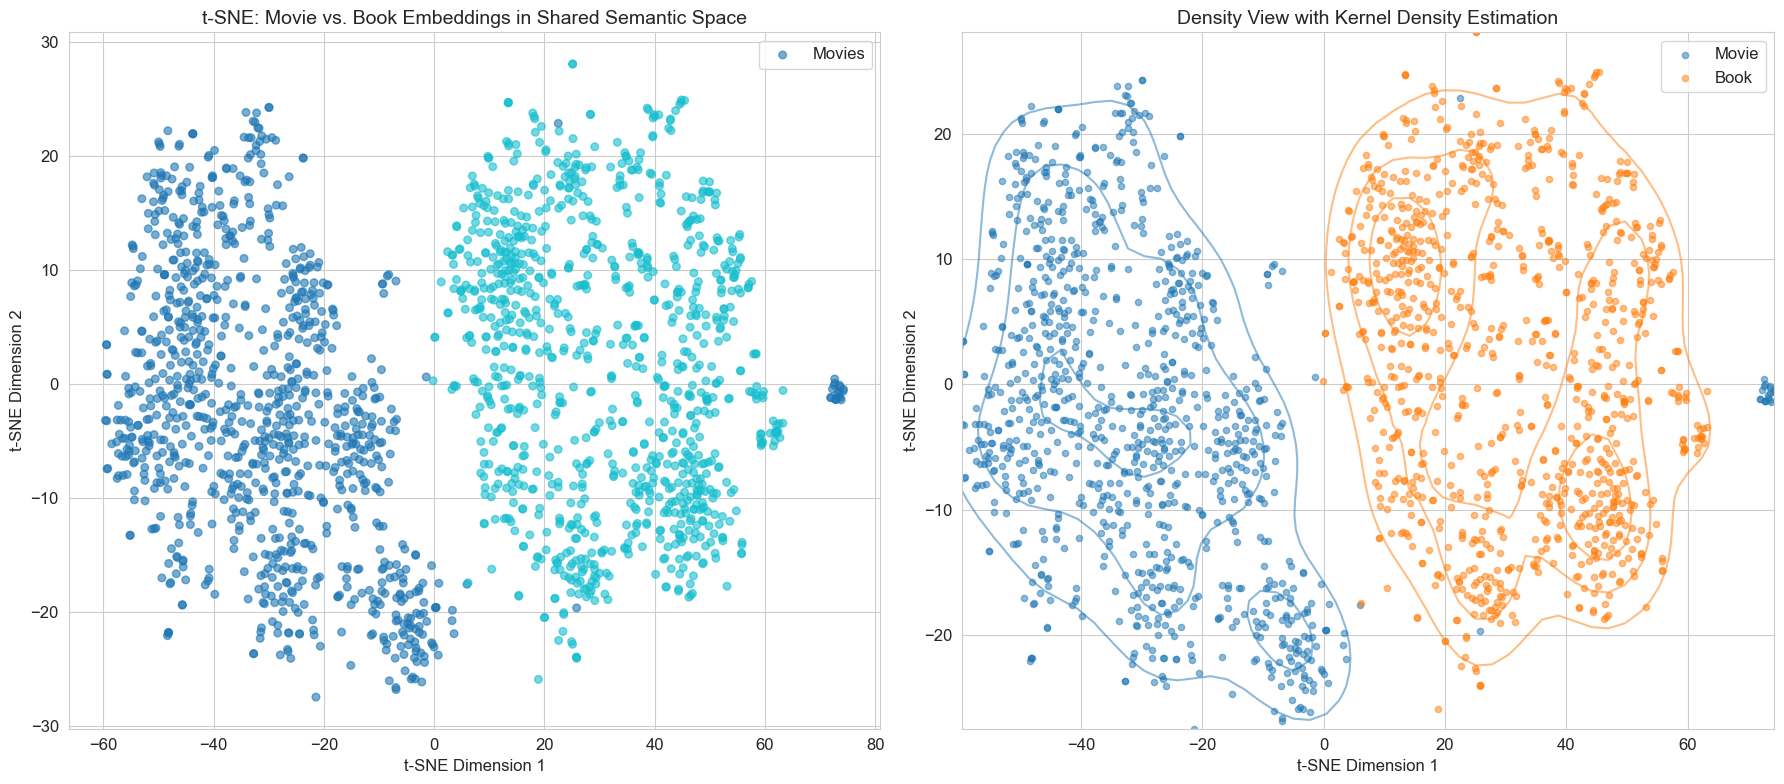


 Analyzing evaluation pairs distribution...


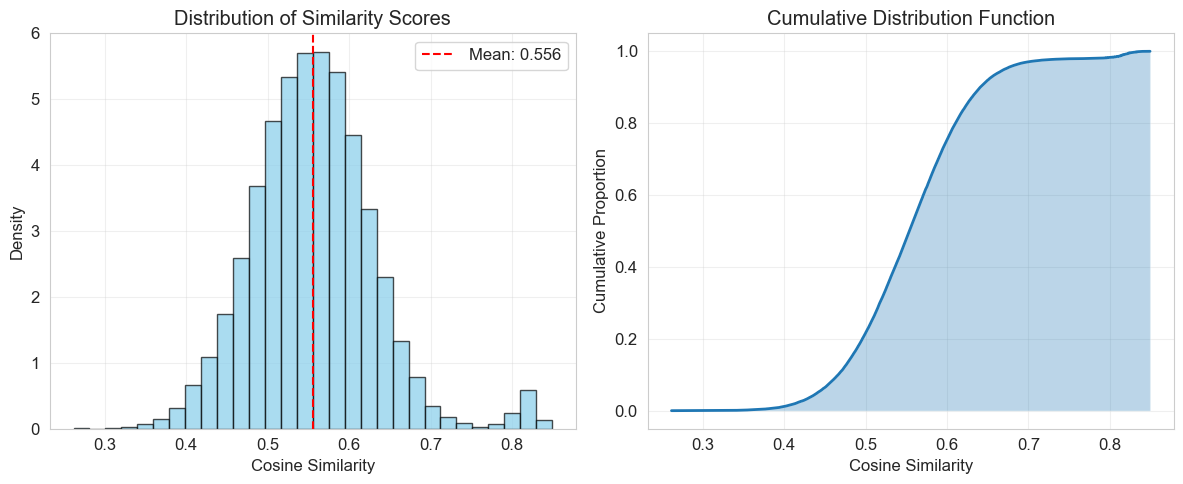

   Mean similarity: 0.556
   Median similarity: 0.554
   Std deviation: 0.075
   Min similarity: 0.261
   Max similarity: 0.849


In [33]:
# ============================================================================
# VISUALIZATION & EMBEDDING SPACE ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION & EMBEDDING SPACE ANALYSIS")
print("=" * 80)

# ----------------------------------------------------------------------------
# t-SNE Visualization of Shared Embedding Space
# ----------------------------------------------------------------------------
print("\n Creating t-SNE visualization of shared embedding space...")

# Sample data for faster t-SNE (optional)
sample_size = min(2000, len(movie_emb_zero), len(book_emb_zero))
np.random.seed(42)

movie_sample_idx = np.random.choice(len(movie_emb_zero), sample_size//2, replace=False)
book_sample_idx = np.random.choice(len(book_emb_zero), sample_size//2, replace=False)

all_emb_sample = np.vstack([movie_emb_zero[movie_sample_idx], book_emb_zero[book_sample_idx]])
labels = ['Movie'] * len(movie_sample_idx) + ['Book'] * len(book_sample_idx)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d = tsne.fit_transform(all_emb_sample)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left: Scatter plot
scatter1 = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=[0 if d == 'Movie' else 1 for d in labels],
                          cmap='tab10', alpha=0.6, s=30)
axes[0].set_title('t-SNE: Movie vs. Book Embeddings in Shared Semantic Space', fontsize=14)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[0].legend(['Movies', 'Books'], loc='best')

# Right: Density plot
import matplotlib.cm as cm
for i, domain in enumerate(['Movie', 'Book']):
    idx = [j for j, label in enumerate(labels) if label == domain]
    if idx:
        axes[1].scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1],
                       label=domain, alpha=0.5, s=20)

# Add kernel density estimation
from scipy.stats import gaussian_kde
for i, domain in enumerate(['Movie', 'Book']):
    idx = [j for j, label in enumerate(labels) if label == domain]
    if len(idx) > 10:
        kde = gaussian_kde(embeddings_2d[idx].T)
        x_range = np.linspace(embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max(), 50)
        y_range = np.linspace(embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max(), 50)
        X, Y = np.meshgrid(x_range, y_range)
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kde(positions).T, X.shape)
        axes[1].contour(X, Y, Z, levels=3, colors=[cm.tab10(i)], alpha=0.5)

axes[1].set_title('Density View with Kernel Density Estimation', fontsize=14)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].legend(loc='best')

plt.tight_layout()
plt.savefig('tsne_shared_space_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------------------------
#  Evaluation Pairs Analysis
# ----------------------------------------------------------------------------
print("\n Analyzing evaluation pairs distribution...")

# Adjusted subplots to only have 2 plots in one row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of similarity scores (axes[0])
axes[0].hist(eval_pairs['similarity'], bins=30, alpha=0.7, color='skyblue',
             edgecolor='black', density=True)
axes[0].axvline(x=eval_pairs['similarity'].mean(), color='red', linestyle='--',
                label=f'Mean: {eval_pairs["similarity"].mean():.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Similarity Scores')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative distribution (now uses axes[1])
sorted_sims = np.sort(eval_pairs['similarity'])
cumulative = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims)
axes[1].plot(sorted_sims, cumulative, linewidth=2)
axes[1].fill_between(sorted_sims, 0, cumulative, alpha=0.3)
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Cumulative Proportion')
axes[1].set_title('Cumulative Distribution Function')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_pairs_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"   Mean similarity: {eval_pairs['similarity'].mean():.3f}")
print(f"   Median similarity: {eval_pairs['similarity'].median():.3f}")
print(f"   Std deviation: {eval_pairs['similarity'].std():.3f}")
print(f"   Min similarity: {eval_pairs['similarity'].min():.3f}")
print(f"   Max similarity: {eval_pairs['similarity'].max():.3f}")


## **6.2 — Genre/Category Heatmaps**

Movie genres → Book categories
Compute cosine similarity between centroids.


ENHANCED VISUALIZATIONS & DEEPER INSIGHTS

Creating cross-domain heatmap...


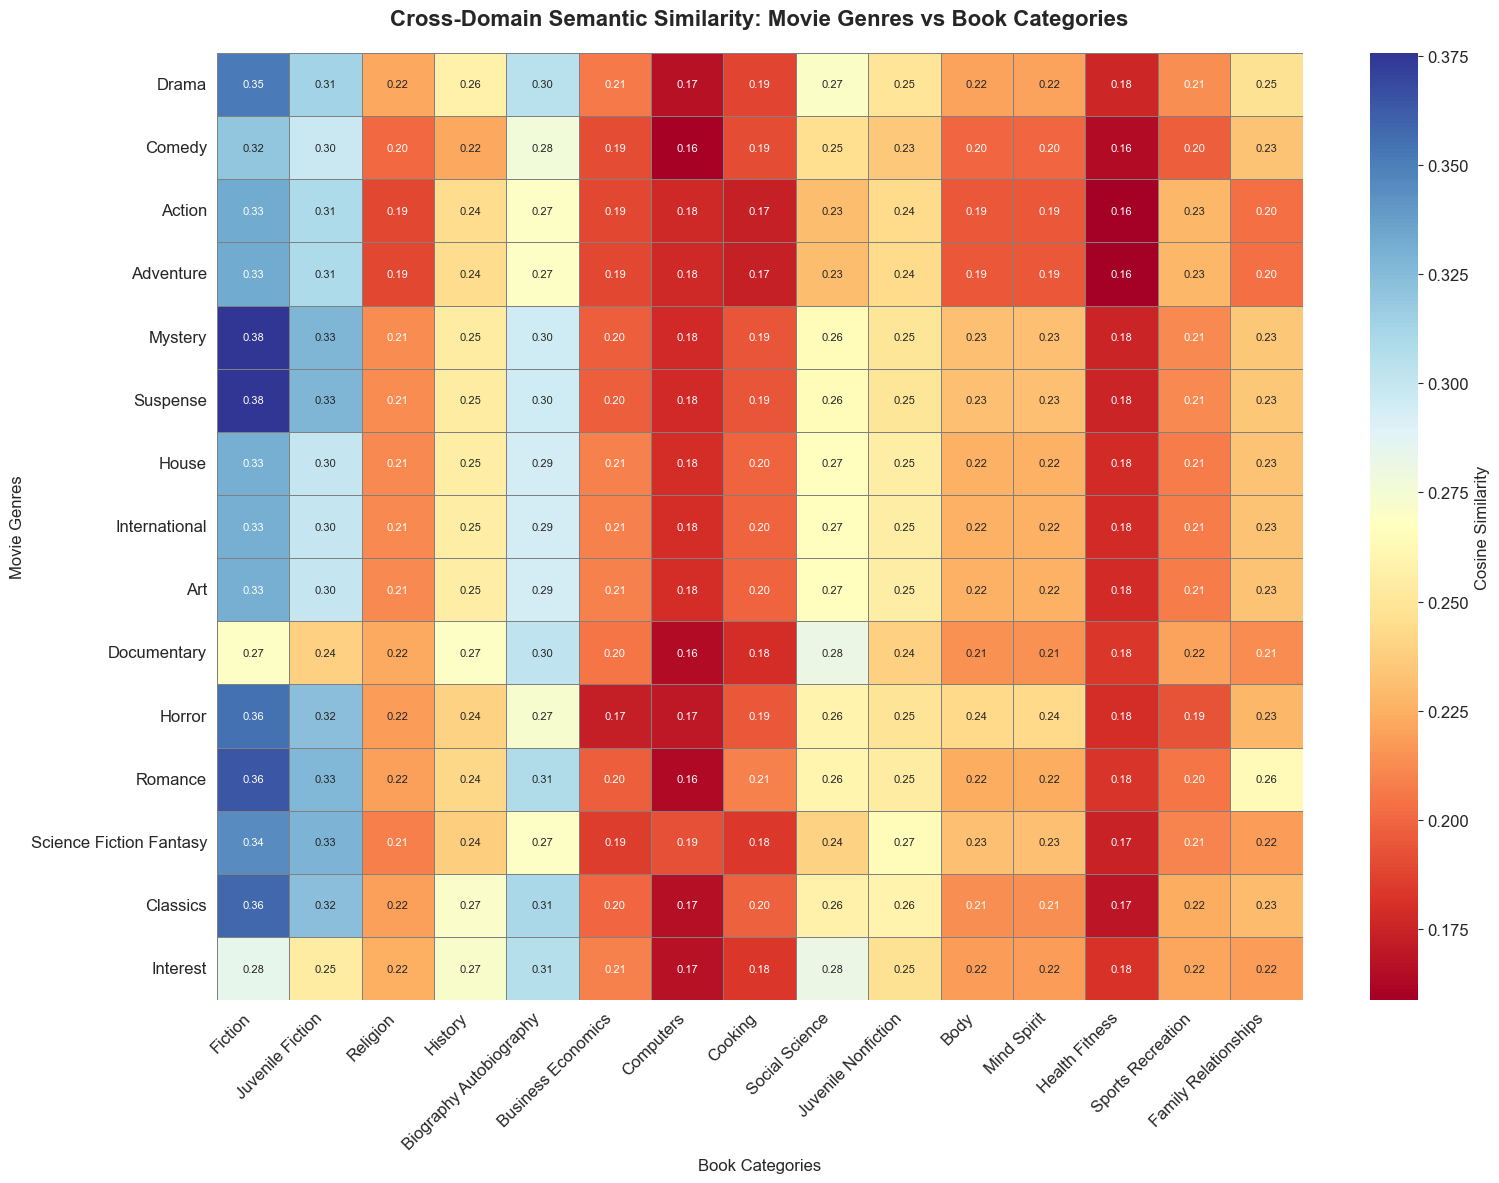


Creating clustered heatmap...


<Figure size 1800x1400 with 0 Axes>

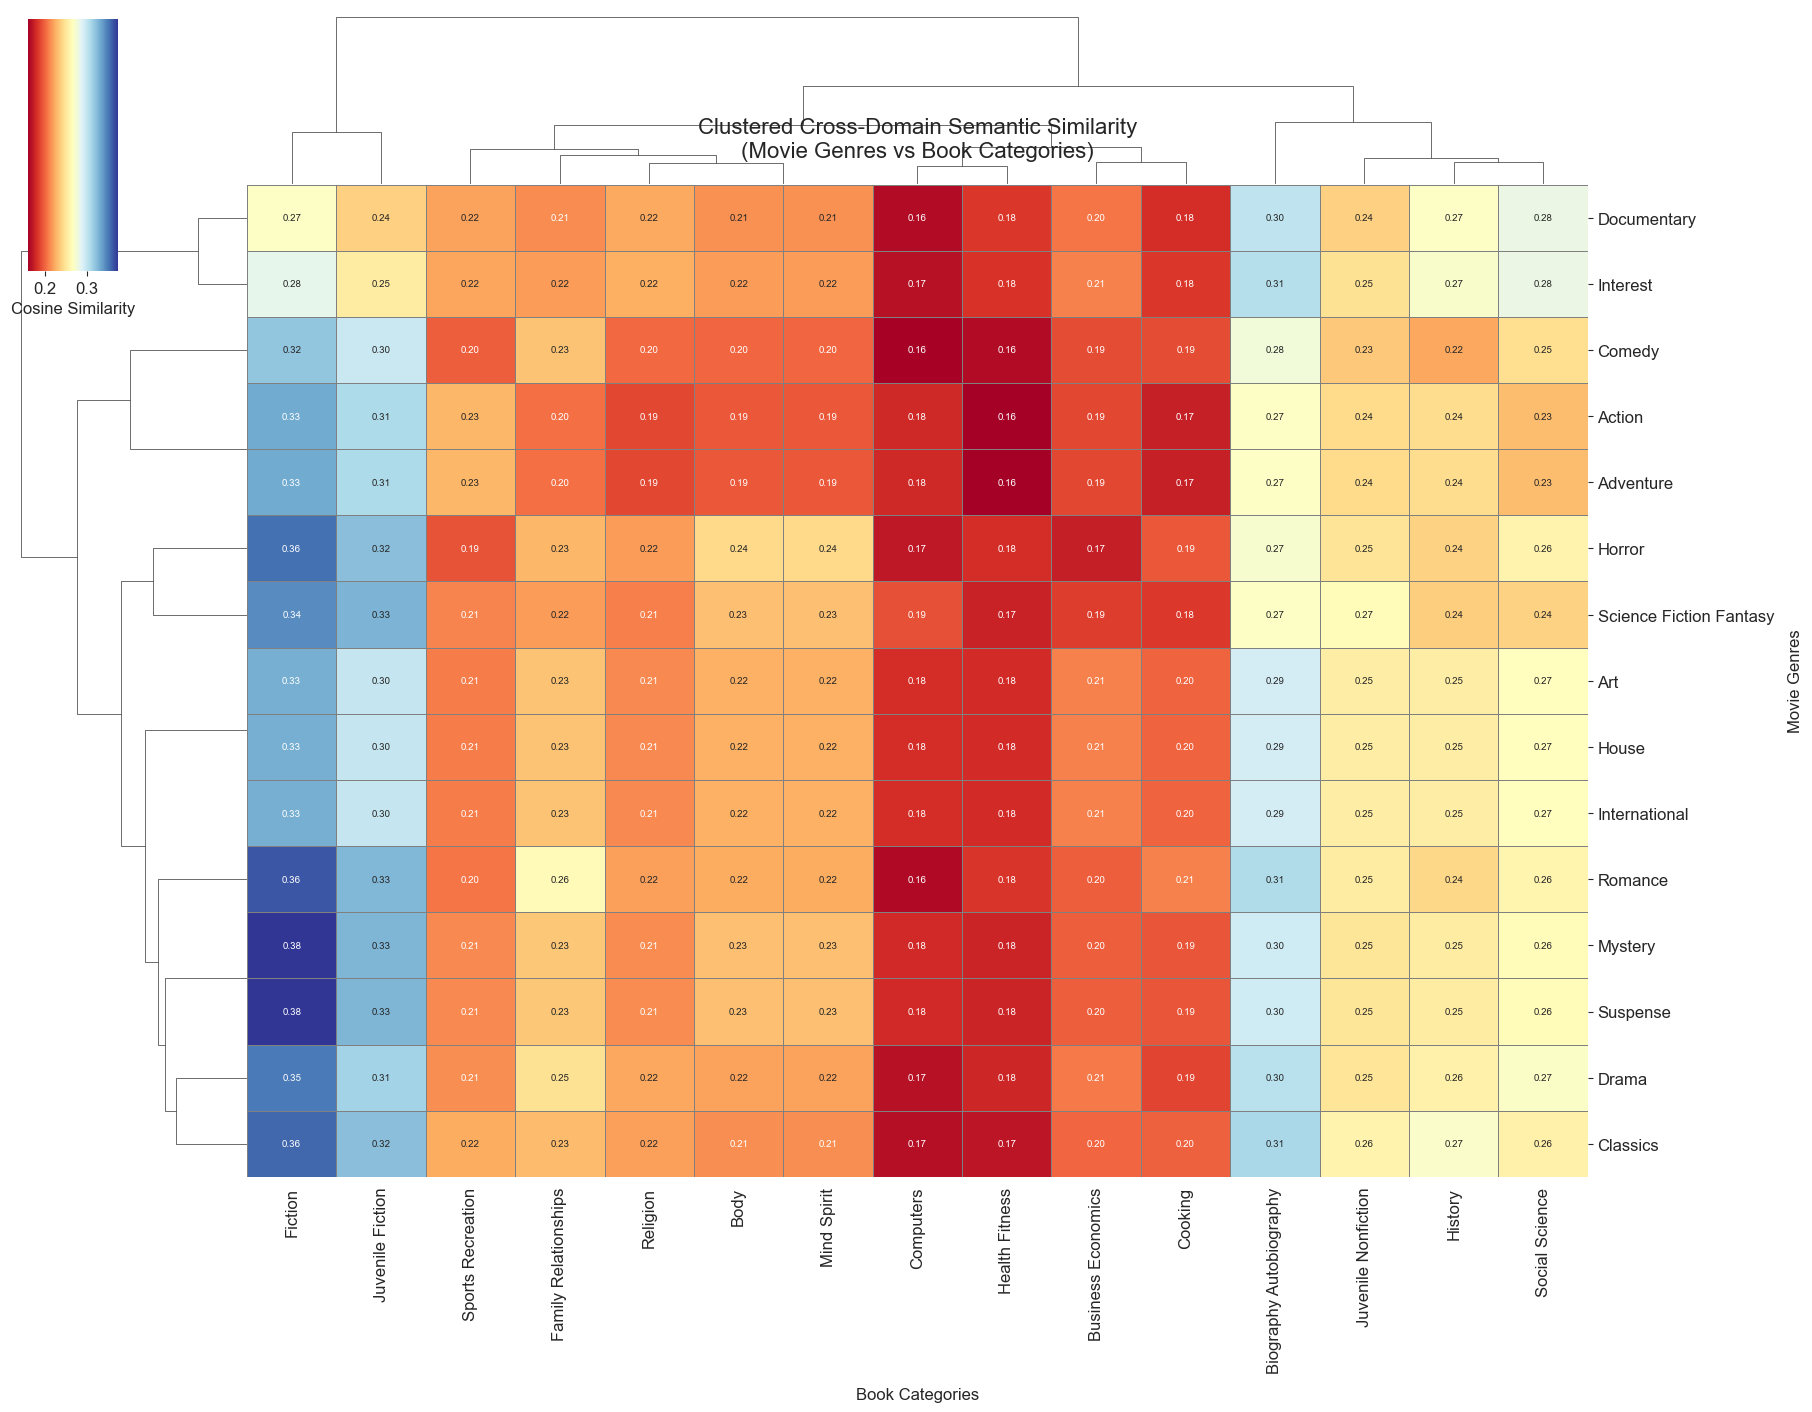


Creating radar chart...


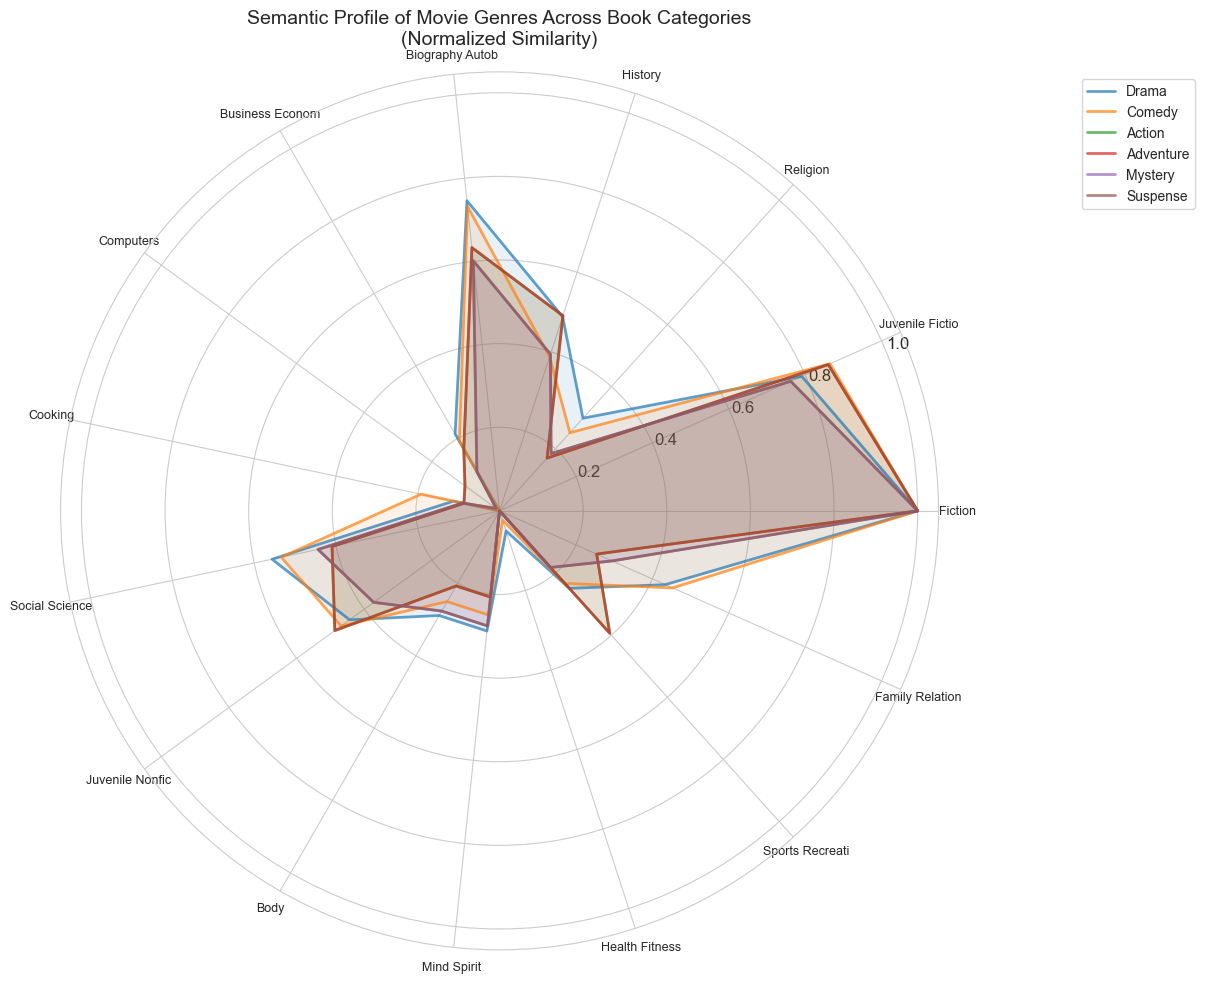


Creating network visualization...


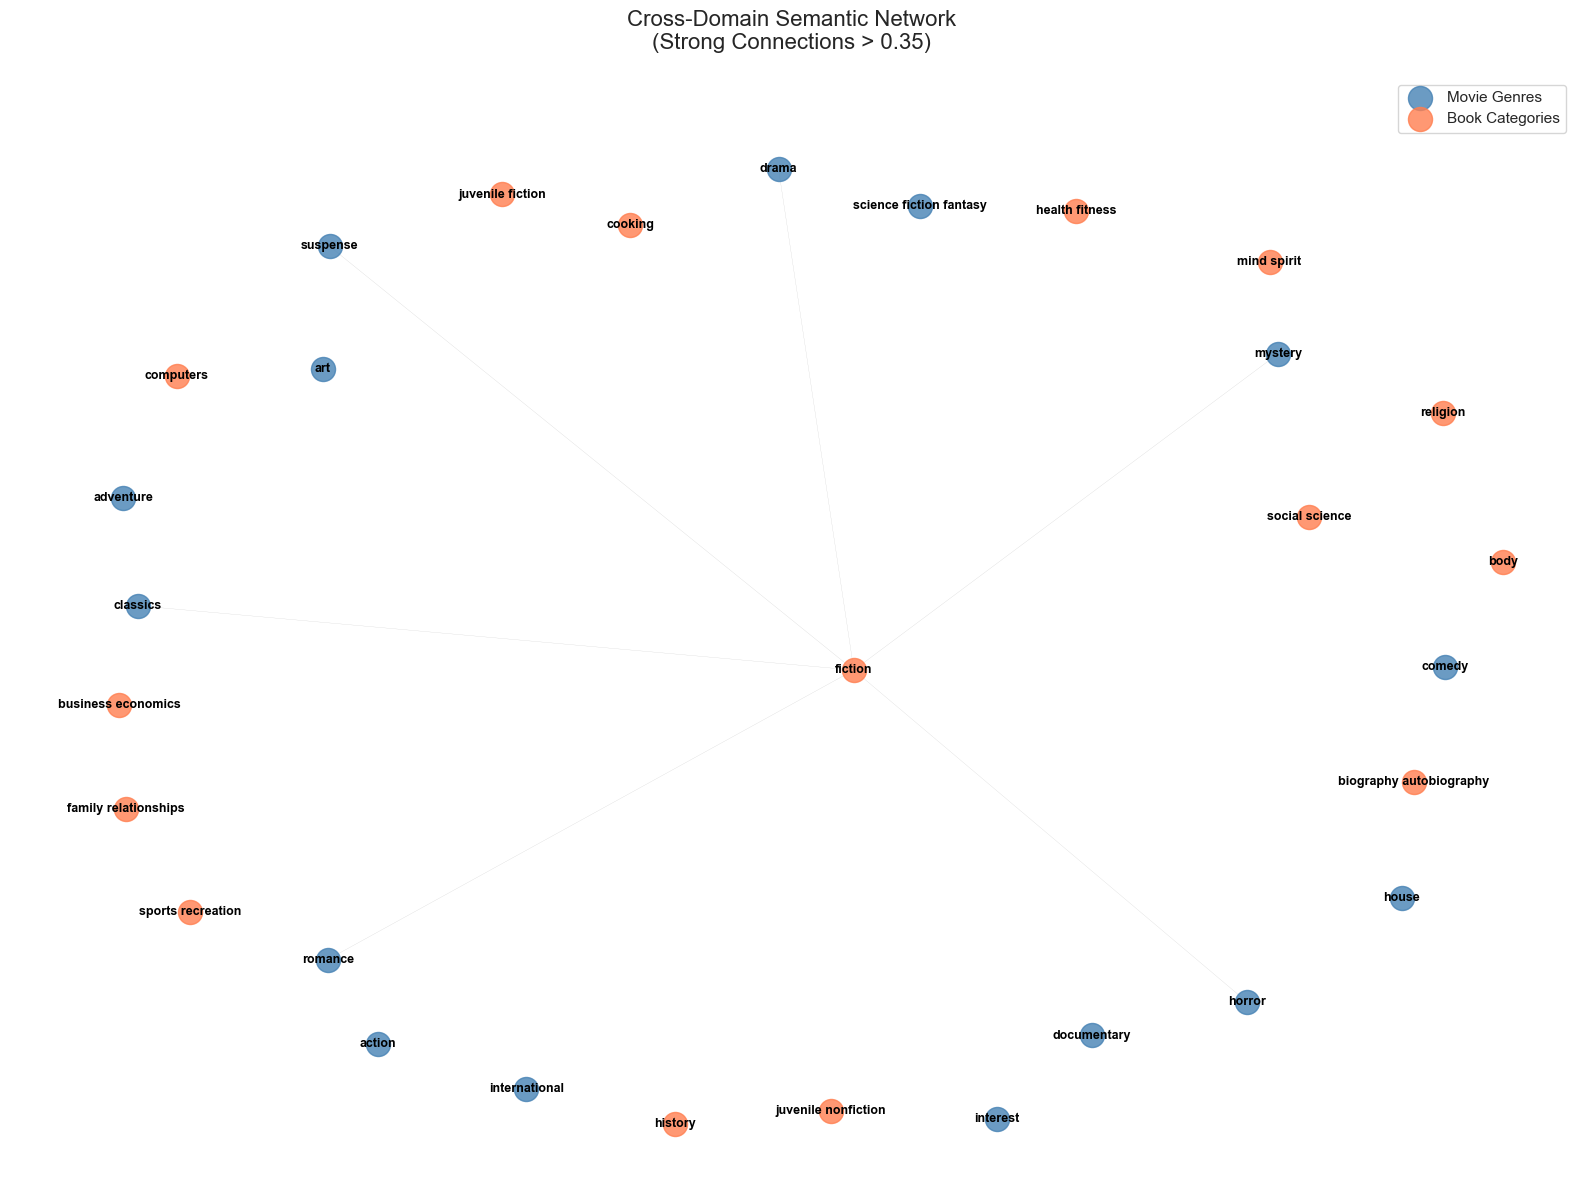


Creating genre similarity matrix...


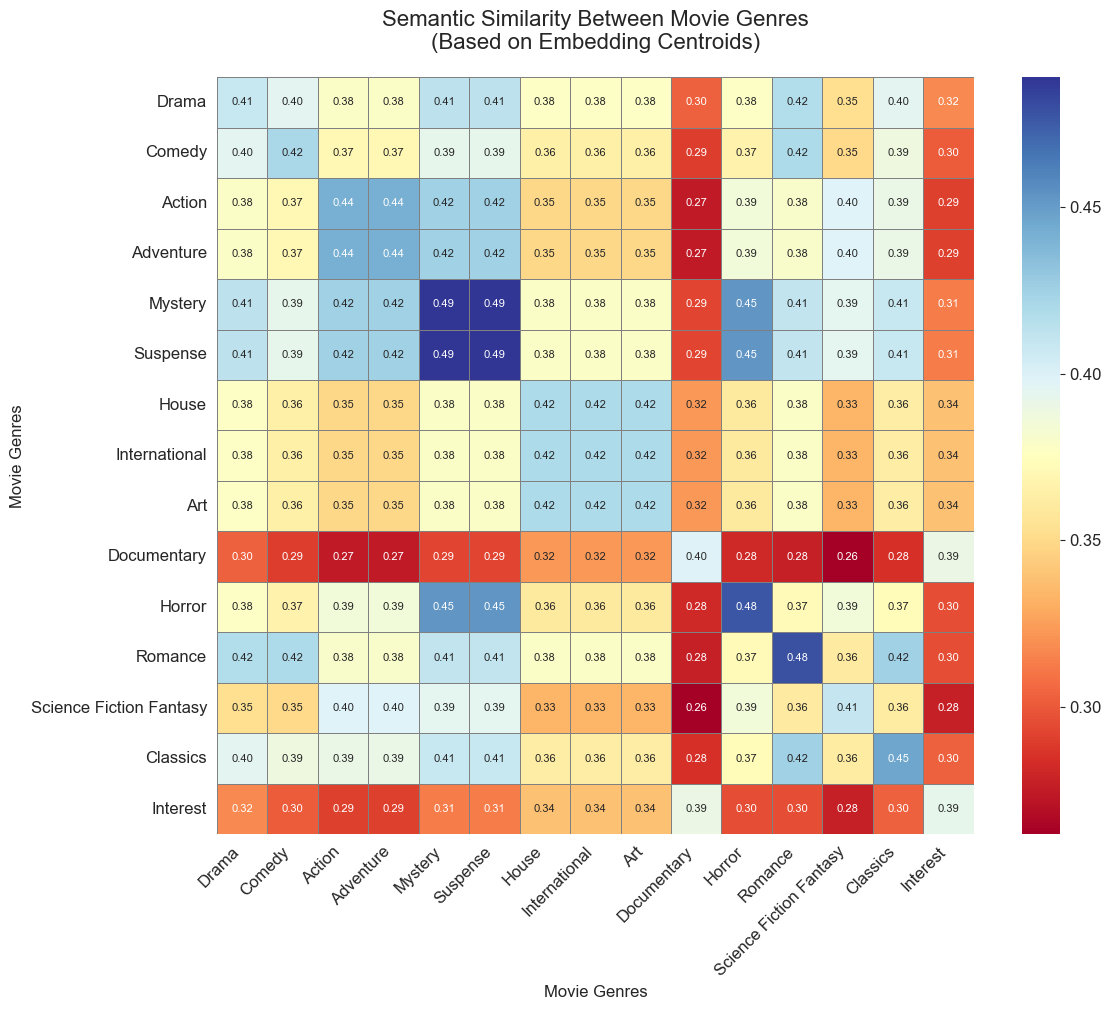


Creating category similarity matrix...


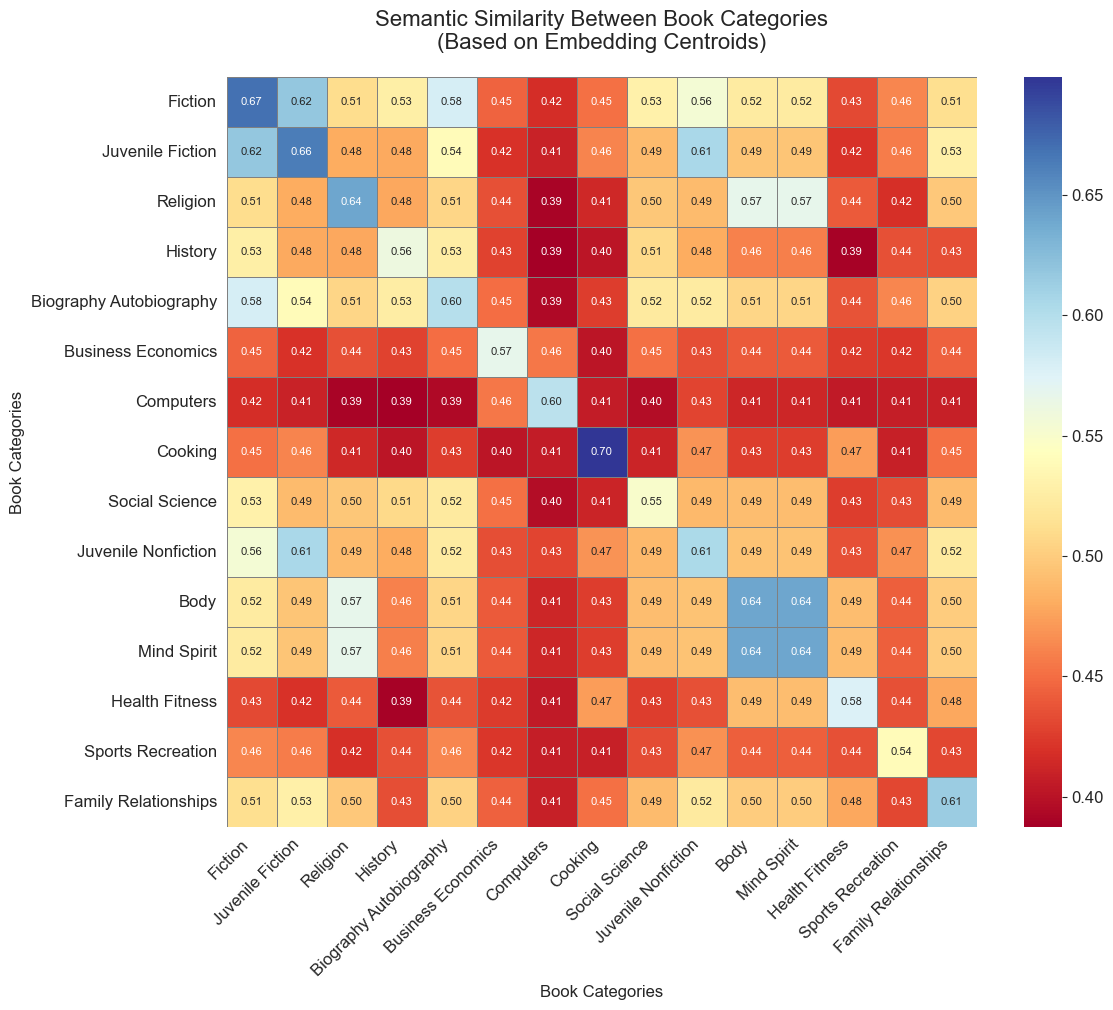


Creating 2D projection...


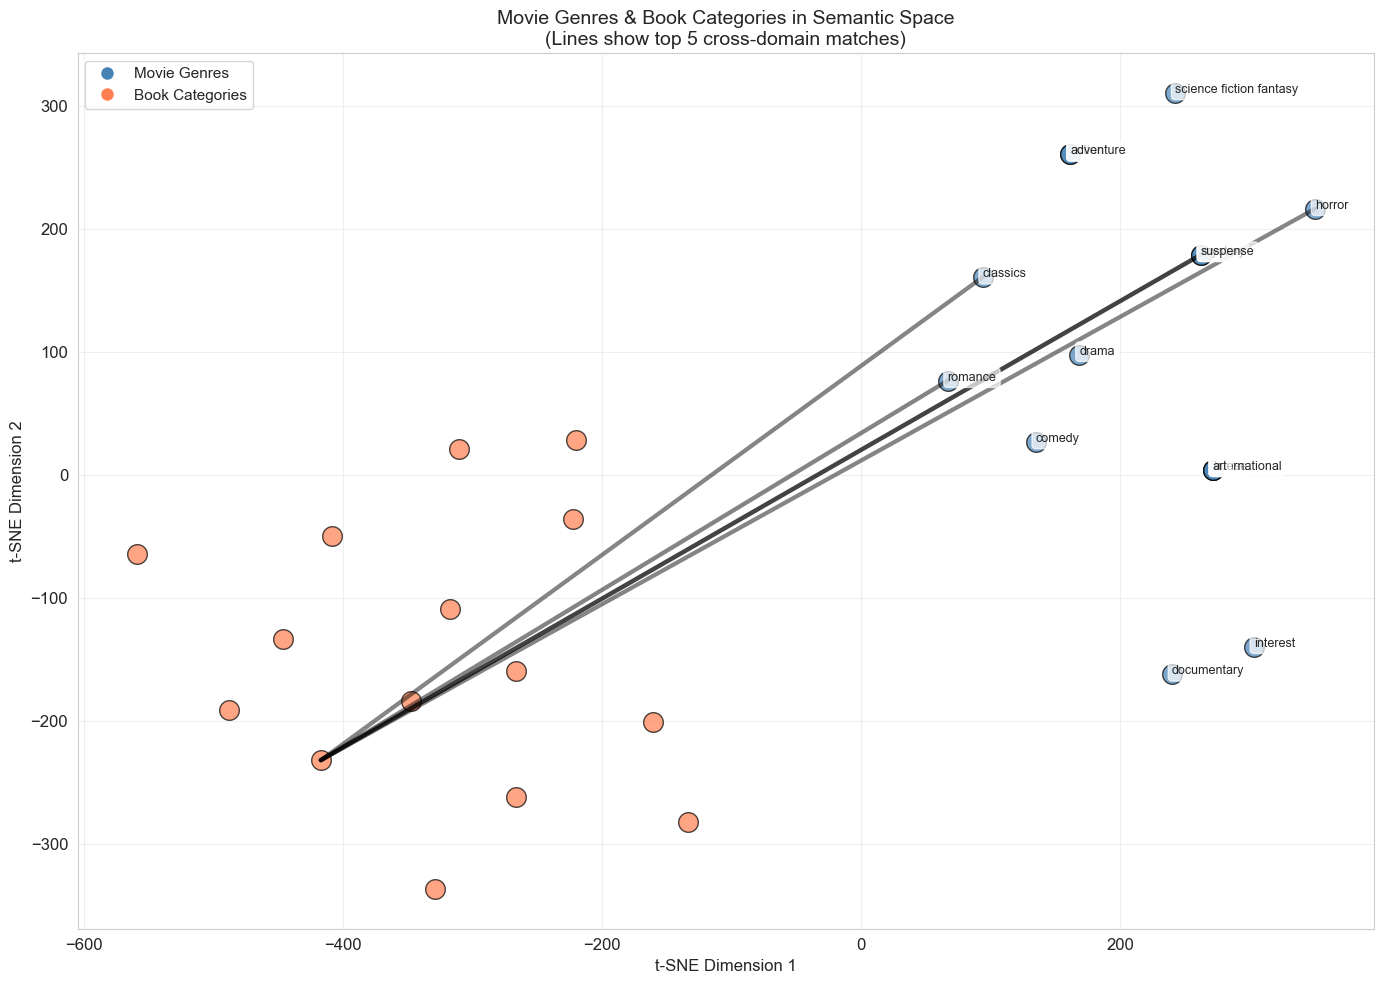


VISUALIZATIONS COMPLETE


In [35]:
# ============================================================================
# ENHANCED VISUALIZATIONS & INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("ENHANCED VISUALIZATIONS & DEEPER INSIGHTS")
print("="*80)

# ----------------------------------------------------------------------------
# 1. CROSS-DOMAIN HEATMAP WITH REAL DATA
# ----------------------------------------------------------------------------
print("\nCreating cross-domain heatmap...")

# Data cleaning functions
def clean_genres(genre_string):
    if pd.isna(genre_string):
        return []

    genre_string = str(genre_string).lower()

    replacements = {
        'action & adventure': 'action adventure',
        'science fiction & fantasy': 'science fiction fantasy',
        'mystery & suspense': 'mystery suspense',
        'art house & international': 'art house international',
        'kids & family': 'kids family'
    }

    for old, new in replacements.items():
        genre_string = genre_string.replace(old, new)

    for delimiter in [',', '&', 'and', '/']:
        genre_string = genre_string.replace(delimiter, '|')

    raw_genres = [g.strip() for g in genre_string.split('|') if g.strip()]

    final_genres = []
    for genre in raw_genres:
        if ' ' in genre and 'fiction' not in genre and 'fantasy' not in genre:
            final_genres.extend([g.strip() for g in genre.split() if len(g.strip()) > 2])
        else:
            if len(genre) > 2:
                final_genres.append(genre)

    return list(set(final_genres))

def clean_categories(category_string):
    if pd.isna(category_string) or str(category_string) == 'Unknown Category':
        return []

    cat_str = str(category_string).lower()
    cat_str = cat_str.replace('[', '').replace(']', '').replace("'", "").replace('"', '')

    categories = []
    for cat in cat_str.split(','):
        cat = cat.strip()
        if cat and 'unknown' not in cat and len(cat) > 2:
            cat = cat.replace(' & ', ' ').replace(' and ', ' ')
            categories.append(cat)

    return list(set(categories))

# Apply cleaning
movies_data['genres_cleaned'] = movies_data['genres_x'].apply(clean_genres)
unique_books = books_data.drop_duplicates(subset=['book_id']).copy()
unique_books['categories_cleaned'] = unique_books['categories_x'].apply(clean_categories)

# Get all genres and categories
all_movie_genres = []
for genres in movies_data['genres_cleaned']:
    all_movie_genres.extend(genres)

all_book_categories = []
for categories in unique_books['categories_cleaned']:
    all_book_categories.extend(categories)

# Get top 15 most frequent
from collections import Counter
top_genres = [genre for genre, count in Counter(all_movie_genres).most_common(15)]
top_categories = [category for category, count in Counter(all_book_categories).most_common(15)]

# Compute centroids
def compute_centroid_for_tag(tag, df, tag_column, embedding_array, id_array, id_column='movie_id'):
    indices = []

    for idx, row in df.iterrows():
        if tag in row[tag_column]:
            item_id = row[id_column]
            emb_idx = np.where(id_array == item_id)[0]
            if len(emb_idx) > 0:
                indices.append(emb_idx[0])

    if indices:
        centroid = np.mean(embedding_array[indices], axis=0)
        return centroid, len(indices)
    else:
        return None, 0

# Compute movie genre centroids
genre_centroids = {}
genre_counts = {}
valid_genres = []

for genre in top_genres:
    centroid, count = compute_centroid_for_tag(
        genre, movies_data, 'genres_cleaned',
        movie_emb_zero, movie_ids, 'movie_id'
    )
    if centroid is not None and count >= 5:
        genre_centroids[genre] = centroid
        genre_counts[genre] = count
        valid_genres.append(genre)

# Compute book category centroids
category_centroids = {}
category_counts = {}
valid_categories = []

for category in top_categories:
    centroid, count = compute_centroid_for_tag(
        category, unique_books, 'categories_cleaned',
        book_emb_zero, book_ids, 'book_id'
    )
    if centroid is not None and count >= 10:
        category_centroids[category] = centroid
        category_counts[category] = count
        valid_categories.append(category)

# Compute similarity matrix
similarity_matrix = np.zeros((len(valid_genres), len(valid_categories)))

for i, genre in enumerate(valid_genres):
    genre_vec = genre_centroids[genre]
    for j, category in enumerate(valid_categories):
        category_vec = category_centroids[category]
        similarity = np.dot(genre_vec, category_vec)
        similarity_matrix[i, j] = similarity

# Create the heatmap
plt.figure(figsize=(16, 12))

sns.heatmap(
    similarity_matrix,
    xticklabels=[c.title() for c in valid_categories],
    yticklabels=[g.title() for g in valid_genres],
    cmap='RdYlBu',
    annot=True,
    fmt='.2f',
    annot_kws={'size': 8},
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.title('Cross-Domain Semantic Similarity: Movie Genres vs Book Categories',
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Book Categories', fontsize=12)
plt.ylabel('Movie Genres', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('cross_domain_heatmap_real.png', dpi=150, bbox_inches='tight')
plt.show()

# Find top matches
top_n = 10
flat_indices = np.argsort(similarity_matrix.flatten())[-top_n:][::-1]
pairs = []
for idx in flat_indices:
    i = idx // len(valid_categories)
    j = idx % len(valid_categories)
    pairs.append((valid_genres[i], valid_categories[j], similarity_matrix[i, j]))

# ----------------------------------------------------------------------------
# 2. CLUSTERED HEATMAP
# ----------------------------------------------------------------------------
print("\nCreating clustered heatmap...")

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

row_linkage = linkage(pdist(similarity_matrix, metric='euclidean'), method='average')
col_linkage = linkage(pdist(similarity_matrix.T, metric='euclidean'), method='average')

plt.figure(figsize=(18, 14))
g = sns.clustermap(
    similarity_matrix,
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    xticklabels=[c.title() for c in valid_categories],
    yticklabels=[g.title() for g in valid_genres],
    cmap='RdYlBu',
    annot=True,
    fmt='.2f',
    annot_kws={'size': 7},
    linewidths=0.5,
    linecolor='gray',
    figsize=(18, 14),
    cbar_kws={'label': 'Cosine Similarity', 'orientation': 'horizontal'},
    dendrogram_ratio=0.15
)

g.ax_heatmap.set_xlabel('Book Categories', fontsize=12, labelpad=10)
g.ax_heatmap.set_ylabel('Movie Genres', fontsize=12, labelpad=10)
g.ax_heatmap.set_title('Clustered Cross-Domain Semantic Similarity\n(Movie Genres vs Book Categories)',
                       fontsize=16, pad=20)

plt.savefig('genre_category_clustermap_real.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------------------------
# 3. RADAR CHART
# ----------------------------------------------------------------------------
print("\nCreating radar chart...")

top_6_genres = valid_genres[:6]
normalized_similarities = []

for genre in top_6_genres:
    genre_idx = valid_genres.index(genre)
    genre_sims = similarity_matrix[genre_idx]
    min_val, max_val = genre_sims.min(), genre_sims.max()
    if max_val > min_val:
        normalized = (genre_sims - min_val) / (max_val - min_val)
    else:
        normalized = genre_sims * 0
    normalized_similarities.append(normalized)

fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(projection='polar'))
angles = np.linspace(0, 2*np.pi, len(valid_categories), endpoint=False).tolist()
angles += angles[:1]

for i, (genre, norms) in enumerate(zip(top_6_genres, normalized_similarities)):
    values = norms.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=genre.title(), alpha=0.7)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([c[:15].title() for c in valid_categories], fontsize=9)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)

plt.title('Semantic Profile of Movie Genres Across Book Categories\n(Normalized Similarity)',
          fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('genre_semantic_profiles_radar_real.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------------------------
# 4. NETWORK VISUALIZATION
# ----------------------------------------------------------------------------
print("\nCreating network visualization...")

try:
    import networkx as nx

    G = nx.Graph()

    for genre in valid_genres:
        G.add_node(genre, type='genre', size=genre_counts.get(genre, 10))

    for category in valid_categories:
        G.add_node(category, type='category', size=category_counts.get(category, 10))

    strong_threshold = 0.35
    for i, genre in enumerate(valid_genres):
        for j, category in enumerate(valid_categories):
            similarity = similarity_matrix[i, j]
            if similarity > strong_threshold:
                G.add_edge(genre, category, weight=similarity*5)

    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    plt.figure(figsize=(16, 12))

    genre_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'genre']
    category_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'category']

    nx.draw_networkx_nodes(G, pos, nodelist=genre_nodes,
                          node_color='steelblue', node_size=300,
                          alpha=0.8, label='Movie Genres')

    nx.draw_networkx_nodes(G, pos, nodelist=category_nodes,
                          node_color='coral', node_size=300,
                          alpha=0.8, label='Book Categories')

    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges,
                          width=[w/10 for w in weights],
                          alpha=0.4, edge_color='gray')

    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

    plt.title(f'Cross-Domain Semantic Network\n(Strong Connections > {strong_threshold})',
              fontsize=16, pad=20)
    plt.legend(scatterpoints=1, fontsize=11)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('semantic_network_real.png', dpi=150, bbox_inches='tight')
    plt.show()

except ImportError:
    print("NetworkX not installed. Skipping network visualization...")

# ----------------------------------------------------------------------------
# 5. GENRE SIMILARITY MATRIX
# ----------------------------------------------------------------------------
print("\nCreating genre similarity matrix...")

genre_similarity = np.zeros((len(valid_genres), len(valid_genres)))
for i, genre1 in enumerate(valid_genres):
    for j, genre2 in enumerate(valid_genres):
        genre_similarity[i, j] = np.dot(genre_centroids[genre1], genre_centroids[genre2])

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    genre_similarity,
    xticklabels=[g.title() for g in valid_genres],
    yticklabels=[g.title() for g in valid_genres],
    cmap='RdYlBu',
    annot=True,
    fmt='.2f',
    annot_kws={'size': 8},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    ax=ax
)

plt.title('Semantic Similarity Between Movie Genres\n(Based on Embedding Centroids)', fontsize=16, pad=20)
plt.xlabel('Movie Genres', fontsize=12)
plt.ylabel('Movie Genres', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('genre_genre_similarity_real.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------------------------
# 6. CATEGORY SIMILARITY MATRIX
# ----------------------------------------------------------------------------
print("\nCreating category similarity matrix...")

category_similarity = np.zeros((len(valid_categories), len(valid_categories)))
for i, cat1 in enumerate(valid_categories):
    for j, cat2 in enumerate(valid_categories):
        category_similarity[i, j] = np.dot(category_centroids[cat1], category_centroids[cat2])

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    category_similarity,
    xticklabels=[c.title() for c in valid_categories],
    yticklabels=[c.title() for c in valid_categories],
    cmap='RdYlBu',
    annot=True,
    fmt='.2f',
    annot_kws={'size': 8},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    ax=ax
)

plt.title('Semantic Similarity Between Book Categories\n(Based on Embedding Centroids)', fontsize=16, pad=20)
plt.xlabel('Book Categories', fontsize=12)
plt.ylabel('Book Categories', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('category_category_similarity_real.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------------------------
# 7. T-SNE PROJECTION
# ----------------------------------------------------------------------------
print("\nCreating 2D projection...")

from sklearn.manifold import TSNE

all_centroids = []
all_labels = []
all_types = []

for genre in valid_genres:
    all_centroids.append(genre_centroids[genre])
    all_labels.append(genre)
    all_types.append('Genre')

for category in valid_categories:
    all_centroids.append(category_centroids[category])
    all_labels.append(category)
    all_types.append('Category')

all_centroids = np.array(all_centroids)
tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000)
centroids_2d = tsne.fit_transform(all_centroids)

fig, ax = plt.subplots(figsize=(14, 10))
colors = {'Genre': 'steelblue', 'Category': 'coral'}

for i, (x, y) in enumerate(centroids_2d):
    typ = all_types[i]
    label = all_labels[i]
    ax.scatter(x, y, c=colors[typ], s=200, alpha=0.7, edgecolors='black', linewidth=1)

    if i < len(valid_genres):
        ax.text(x + 0.02, y + 0.02, label, fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

for genre, category, sim in pairs[:5]:
    if genre in valid_genres and category in valid_categories:
        genre_idx = all_labels.index(genre)
        cat_idx = all_labels.index(category)
        x1, y1 = centroids_2d[genre_idx]
        x2, y2 = centroids_2d[cat_idx]
        linewidth = 2 + (sim * 3)
        alpha = 0.3 + (sim * 0.5)
        ax.plot([x1, x2], [y1, y2], 'k-', alpha=alpha, linewidth=linewidth)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Movie Genres & Book Categories in Semantic Space\n(Lines show top 5 cross-domain matches)', fontsize=14)
ax.grid(True, alpha=0.3)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Movie Genres',
           markerfacecolor='steelblue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Book Categories',
           markerfacecolor='coral', markersize=10)
]
ax.legend(handles=legend_elements, loc='best', fontsize=11)

plt.tight_layout()
plt.savefig('genres_categories_tsne_real.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("VISUALIZATIONS COMPLETE")
print("="*80)